## Overview


Visual Privacy — Full Pipeline + Reporting (with Transfer Learning Suite)

Here’s the pipeline in brief, step-by-step:

## Stage 0 — Unified preamble (headless + optional inline previews)
## Stage 1 — Imports (ML stack)
## Stage 2 — Logging + output helpers (figures & tables)
## Stage 3 — Load & Clean
## Stage 4 — Group split
## Stage 5 — Exploratory correlations (Pearson/Spearman + BH–FDR)
## Stage 6 — Baselines + Group-aware model selection
## Stage 7 — Scenario weights (inverse-frequency) + weighted evaluation
## Stage 8 — Noise ceilings (ICC-like)
## Stage 9 — Transfer learning (Render ↔ VR)
## Stage 10 — R² vs ICC-like ceilings (Render-best, VR-best, Combined-best, Transfer-best)
## Stage 11 — SHAP (fast, cached) + interactions
## Stage 12 — SHAP label-permutation significance (tree models, fast)
## Stage 13 — SHAP rank stability (trees; fast)
## Stage 14 — SHAP significant-only summary (no recompute; paper-ready)
## Stage 15 — Actionable deltas from centered ALE (near-median slope × 1 SD)
## Stage 16 — Ablation (drop feature groups)
## Stage 17 — Bootstrap 95% CI for test R² (group-aware)
## Stage 18 — Uncertainty via split-conformal (90%)
## Stage 19 — Cross-modality generalization (Train→Test)
## Stage 20 — Error analysis (top under/over-predictions)

'\nVisual Privacy — Full Pipeline + Reporting (with Transfer Learning Suite)\n\nHere’s the pipeline in brief, step-by-step:\n\nPreamble – Set up headless plotting, inline previews, LaTeX/CSV aggregators, logging, helper funcs.\n\nLoad & Clean – Read render.csv/VR.csv, encode categoricals, split view to L/F/R, scenario NaNs, impute, align columns.\n\nGroup Split – Build group_id from GROUP_COLS; create grouped train/test for Render, VR, Combined.\n\nCorrelations + BH–FDR – Pearson/Spearman vs target, q-values, heatmaps, top-|r| table, feature–feature corr.\n\nBaselines – Mean, Linear, Quantile-GBR (0.5/0.1/0.9) per domain.\n\nModel Search (Group-aware) – Pipelines; randomized search across families; pick best per domain; actual-vs-pred plots.\n\n(Optional) Weights – Inverse-frequency group weights for parallel weighted runs.\n\nNoise Ceilings – ICC-like reliability ceilings per domain.\n\nTransfer Learning – XGB pretrain→finetune variants + Teacher→Student feature transfer; select best 

## Stage 0 — Unified preamble (headless + optional inline previews)

In [2]:
# =========================
# Stage 0 — Unified preamble (headless + optional inline previews)
# =========================
import os, sys, re, json, warnings
warnings.filterwarnings("ignore", category=UserWarning)
from pathlib import Path

print("[SETUP] Using Agg backend; figures will be saved to disk. "
      "Inline previews auto-enable in notebooks.", flush=True)

import matplotlib
matplotlib.use("Agg")  # headless-safe
import matplotlib.pyplot as plt
import pandas as pd  # needed here for annotations + inline HTML previews

# Output dirs
FIG_DIR = Path("figures"); TAB_DIR = Path("tables"); CSV_SUB = TAB_DIR / "csv"
for _d in (FIG_DIR, TAB_DIR, CSV_SUB): _d.mkdir(parents=True, exist_ok=True)

# Aggregates (create headers once)
__TABLE_FILE = TAB_DIR / "all_tables.tex"
if not __TABLE_FILE.exists():
    __TABLE_FILE.write_text("% Auto-generated LaTeX tables file\n% Use \\input{tables/all_tables.tex}\n\n", encoding="utf-8")

__FIG_TEX_FILE = FIG_DIR / "all_figures.tex"
if not __FIG_TEX_FILE.exists():
    __FIG_TEX_FILE.write_text("% Auto-generated LaTeX figures file\n% Use \\input{figures/all_figures.tex}\n\n", encoding="utf-8")

# Target column used across stages
TARGET = "privacy"

# Utilities
def _slug(s):
    return re.sub(r"[^a-zA-Z0-9]+", "_", str(s).strip().lower()).strip("_") or "figure"

def _no_show(*args, **kwargs):  # keep headless quiet
    pass
plt.show = _no_show

# --- Minimal fallbacks so Stage 0 can run before Stage 2 ----------------------
# If Stage 2 hasn't defined _print yet, fallback to plain print
if "_print" not in globals():
    def _print(msg: str):  # noqa: F811
        print(msg, flush=True)

# Detect notebook for inline preview
INLINE_PREVIEW = False
try:
    from IPython import get_ipython
    ip = get_ipython()
    INLINE_PREVIEW = ip is not None and ip.__class__.__name__ == "ZMQInteractiveShell"
except Exception:
    INLINE_PREVIEW = False

try:
    from IPython.display import display as _ipy_display, Image as _ipy_Image
except Exception:
    _ipy_display = None
    _ipy_Image = None

def _append_latex_figure(pdf_path: Path, caption: str, label: str = None):
    """Append a LaTeX \\figure block to figures/all_figures.tex."""
    if not caption:
        caption = pdf_path.stem.replace("_", " ")
    if label is None:
        label = f"fig:{_slug(pdf_path.stem)}"
    # Stage note if available
    stage_title = globals().get("__CURRENT_STAGE", {}).get("title", "Unstaged")
    stage_num   = globals().get("__CURRENT_STAGE", {}).get("num", 0)
    cap_text    = f"{caption} \\StageNote{{Stage {stage_num} — {stage_title}}}"
    with open(__FIG_TEX_FILE, "a", encoding="utf-8") as f:
        f.write("\\begin{figure}[t]\n\\centering\n")
        f.write(f"\\includegraphics[width=.85\\linewidth]{{{pdf_path.name}}}\n")
        f.write(f"\\caption{{{cap_text}}}\n")
        f.write(f"\\label{{{label}}}\n\\end{{figure}}\n\n")

def savefig_inline(fig, stem, caption=None, *, dpi=180, bbox_inches="tight"):
    """
    Save both PDF (LaTeX) and PNG (preview) to figures/<stem>.{pdf,png}.
    If running in a notebook, also display the PNG inline.
    Also appends a LaTeX \\figure block to figures/all_figures.tex.
    """
    stem = _slug(stem)
    pdf_path = FIG_DIR / f"{stem}.pdf"
    png_path = FIG_DIR / f"{stem}.png"

    fig.savefig(str(pdf_path), format="pdf", dpi=dpi, bbox_inches=bbox_inches)
    fig.savefig(str(png_path), format="png", dpi=dpi, bbox_inches=bbox_inches)

    if INLINE_PREVIEW and (_ipy_display is not None) and (_ipy_Image is not None):
        with open(png_path, "rb") as f:
            _ipy_display(_ipy_Image(data=f.read(), embed=True))

    _append_latex_figure(pdf_path, caption)

def save_and_tex(fig, stem, caption=None, *, dpi=180, bbox_inches="tight"):
    """Thin wrapper so later stages call one saver."""
    return savefig_inline(fig, stem, caption, dpi=dpi, bbox_inches=bbox_inches)

# --- Inline table previews (HTML) ---
try:
    from IPython.display import HTML as _ipy_HTML
except Exception:
    _ipy_HTML = None

# Optional folder for standalone HTML tables (nice to open/share)
TAB_HTML = TAB_DIR / "html"
TAB_HTML.mkdir(parents=True, exist_ok=True)

def show_table_inline(df: pd.DataFrame, caption: str = None, *, max_rows=40, max_cols=40):
    """
    Inline preview in notebooks; graceful fallback to terminal .head().
    """
    if INLINE_PREVIEW and (_ipy_display is not None) and (_ipy_HTML is not None):
        with pd.option_context("display.max_rows", max_rows, "display.max_columns", max_cols):
            html = df.to_html(index=False, border=0)
        if caption:
            html = f"<div style='font-weight:600;margin:4px 0 6px'>{caption}</div>" + html
        _ipy_display(_ipy_HTML(html))
    else:
        # Non-notebook fallback: show a compact preview in the log/terminal
        n = min(len(df), max_rows)
        _print(f"[PREVIEW] Showing first {n} rows (non-notebook mode):")
        _print(df.head(n).to_string(index=False))

def _save_table_bridge(df: pd.DataFrame, caption: str, label: str = None, csv_name: str = None, why: str = ""):
    """
    Call the real save_table if defined later in Stage 2; otherwise do a minimal fallback.
    """
    real = globals().get("save_table", None)
    if callable(real):
        return real(df, caption, label, csv_name, why)
    # Fallback: just write CSV and log a note (no LaTeX aggregation yet)
    stem = (csv_name or _slug(caption) or "table")
    csv_path = CSV_SUB / f"{stem}.csv"
    df.to_csv(csv_path, index=False, encoding="utf-8")
    _print(f"[TABLE][fallback] CSV saved → {csv_path} (LaTeX aggregation will work after Stage 2 is executed)")

def save_and_show_table(df: pd.DataFrame, caption: str, label: str = None,
                        csv_name: str = None, why: str = "", *,
                        max_rows=40, max_cols=40):
    """
    Save (LaTeX + CSV) via save_table when available; otherwise CSV-only fallback.
    Also write an .html copy, and show inline if possible.
    """
    # Persist via bridge (uses real save_table after Stage 2; otherwise fallback)
    _save_table_bridge(df, caption, label, csv_name, why)

    # Save a portable HTML copy (nice for quick sharing)
    stem = csv_name or _slug(caption) or "table"
    html_path = TAB_HTML / f"{stem}.html"
    html_path.write_text(df.to_html(index=False, border=0), encoding="utf-8")
    _print(f"[TABLE] HTML saved → {html_path}")

    # Inline preview (notebook only / or terminal fallback)
    show_table_inline(df, caption, max_rows=max_rows, max_cols=max_cols)


[SETUP] Using Agg backend; figures will be saved to disk. Inline previews auto-enable in notebooks.


## Stage 1 — Imports (ML stack)

In [3]:
# =========================
# Stage 1 — Imports (ML stack)
# =========================
print("[SETUP] Initializing runtime…", flush=True)
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GroupKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# RMSE helper (compat across sklearn versions)
try:
    from sklearn.metrics import root_mean_squared_error as _rmse
    def RMSE(y, yhat): return float(_rmse(y, yhat))
except Exception:
    def RMSE(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))

# XGBoost & SHAP
from xgboost import XGBRegressor
import shap

# Stats & search distributions
from scipy.stats import pearsonr, spearmanr
from scipy.stats import randint, loguniform, uniform


[SETUP] Initializing runtime…


c:\Users\naima\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Stage 2 — Logging + output helpers (figures & tables)

In [4]:
# =========================
# Stage 2 — Logging + output helpers (figures & tables)
# =========================
def _script_stem():
    try:
        return Path(__file__).stem
    except Exception:
        return "session"

LOG_FILE = Path(f"terminal+{_script_stem()}.txt")

class TeeLogger:
    """Mirror stdout/stderr to terminal and a persistent log file."""
    def __init__(self, path):
        self.fh = open(path, "w", encoding="utf-8")
    def write(self, s):
        sys.__stdout__.write(s); self.fh.write(s); self.fh.flush()
    def flush(self):
        sys.__stdout__.flush(); self.fh.flush()
    def isatty(self): return False

sys.stdout = TeeLogger(LOG_FILE); sys.stderr = sys.stdout
print(f"[SETUP] Terminal will also be saved to: {LOG_FILE.resolve()}")

def _print(msg: str): print(msg, flush=True)
def stage_note(msg: str): _print(f"[NOTE ] {msg}")

# Stage context for captions
__STAGE_COUNTER = 0
__CURRENT_STAGE = {"num": 0, "title": "", "why": ""}

def begin_stage(title: str, why: str = ""):
    """Announce a new stage and store context for captions."""
    global __STAGE_COUNTER, __CURRENT_STAGE
    __STAGE_COUNTER += 1
    __CURRENT_STAGE["num"] = __STAGE_COUNTER
    __CURRENT_STAGE["title"] = title.strip()
    __CURRENT_STAGE["why"] = (why or "").strip()
    line = "=" * 72
    _print(f"\n{line}\n[STAGE {__STAGE_COUNTER}] {__CURRENT_STAGE['title']}\n{line}")
    if __CURRENT_STAGE["why"]: _print(f"[WHY ] {__CURRENT_STAGE['why']}")

# Tables aggregate helpers
__TABLE_HEADER_WRITTEN = __TABLE_FILE.exists()
__TABLE_INDEX = TAB_DIR / "all_tables.txt"
__TABLE_INDEX_HEADER_WRITTEN = __TABLE_INDEX.exists()

def _ensure_table_header():
    global __TABLE_HEADER_WRITTEN, __TABLE_INDEX_HEADER_WRITTEN
    if not __TABLE_HEADER_WRITTEN:
        with open(__TABLE_FILE, "w", encoding="utf-8") as f:
            f.write("% Auto-generated LaTeX tables file\n% Use \\input{tables/all_tables.tex}\n\n")
        __TABLE_HEADER_WRITTEN = True
        _print(f"[TABLE] Created LaTeX aggregate → {__TABLE_FILE}")
    if not __TABLE_INDEX_HEADER_WRITTEN:
        with open(__TABLE_INDEX, "w", encoding="utf-8") as f:
            f.write("# All tables index (human-readable)\n# [Stage] Caption | label=... | csv=...\n\n")
        __TABLE_INDEX_HEADER_WRITTEN = True
        _print(f"[TABLE] Created plaintext index → {__TABLE_INDEX}")

def save_table(df: pd.DataFrame, caption: str, label: str = None, csv_name: str = None, why: str = ""):
    """
    Persist a DataFrame as:
      • LaTeX table appended into tables/all_tables.tex (caption includes Stage Note)
      • CSV under tables/csv/
      • plaintext index entry (Stage, caption, label, csv path)
    Empty DataFrames are skipped with a note.
    """
    assert isinstance(df, pd.DataFrame)
    if df.empty:
        stage_note(f"[TABLE][SKIP] '{caption}' — empty DataFrame.")
        return
    _ensure_table_header()
    if not caption or not str(caption).strip(): caption = "Table (no caption)"
    if label is None: label = f"tab:{_slug(caption) or 'table'}"
    stem = csv_name or _slug(caption) or "table"
    csv_path = CSV_SUB / f"{stem}.csv"

    # Stage note + optional WHY
    stage_title = __CURRENT_STAGE.get("title","Unstaged"); stage_num = __CURRENT_STAGE.get("num",0)
    if why or __CURRENT_STAGE.get("why",""): _print(f"[WHY  ] {why or __CURRENT_STAGE.get('why','')}")
    cap = f"{caption} \\StageNote{{Stage {stage_num} — {stage_title}}}"

    # LaTeX block
    with open(__TABLE_FILE, "a", encoding="utf-8") as f:
        f.write("\\begin{table}[ht]\n\\centering\n")
        f.write(df.to_latex(index=False, escape=True))
        f.write(f"\n\\caption{{{cap}}}\n\\label{{{label}}}\n\\end{{table}}\n\n")

    # CSV + plaintext index
    df.to_csv(csv_path, index=False, encoding="utf-8"); _print(f"[TABLE] CSV saved → {csv_path}")
    with open(__TABLE_INDEX,"a",encoding="utf-8") as f:
        f.write(f"[Stage {stage_num}] {caption} | label={label} | csv={csv_path.name}\n")


## Stage 3 — Load & Clean

In [5]:
# =========================
# Stage 3 — Load & Clean
# =========================
begin_stage("Load & Clean", "Harmonize Render/VR, encode categories, handle scenario-aware NaNs.")

# Load raw
vr_raw = pd.read_csv("VR.csv")
render_raw = pd.read_csv("render.csv")
vr_raw["Source"] = "VR"; render_raw["Source"] = "Render"

def _split_view_col(s):
    """
    'view' is a 3-char code (L/F/R). Fill missing with 'G' (neutral), then map to {G:0, S:1, B:2}.
    """
    s = "" if pd.isna(s) else str(s)
    s = (s + "GGG")[:3]
    return s[0], s[1], s[2]

def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Robust cleaning:
      - drop rows with missing target
      - categorical → numeric coding
      - decompose 'view' into (L/F/R) and map levels
      - scenario-aware NaN injection for hidden sides
      - mean-imputation for numeric columns
    """
    d = data.dropna(subset=[TARGET]).copy()
    d[TARGET] = d[TARGET].replace({'v-high':5,'high':4,'medium':3,'low':2,'v-low':1})

    d["sex"] = d.get("sex", np.nan).replace({"Female":0,"Male":1})
    d["age"] = d.get("age", np.nan).replace({'46-60':53,'21-30':25.5,'31-45':38,'over 60':65})
    d["edu"] = d.get("edu", np.nan).replace({'University education':3,'University Education':3,
                                             'Secondary education':2,'Elementary education':1,'Elementary Education':1})

    # split 'view' into L/F/R if present
    if "view" in d.columns:
        vL, vF, vR = zip(*d["view"].map(_split_view_col))
        d["view(L)"] = pd.Series(vL).replace({'B':2,'S':1,'G':0})
        d["view(F)"] = pd.Series(vF).replace({'B':2,'S':1,'G':0})
        d["view(R)"] = pd.Series(vR).replace({'B':2,'S':1,'G':0})
        d.drop(columns=["view"], inplace=True)
    else:
        d["view(L)"]=0; d["view(F)"]=0; d["view(R)"]=0

    # space category
    if "space category" in d.columns:
        d["space category"] = d["space category"].replace({'Bedroom':1,'Living Room':0})
    else:
        d["space category"] = 0.5

    # scenario-aware NaNs: if sill height > 0.3, balcony view is irrelevant
    for S in ["R","L","F"]:
        sh_col = f'sill height({S})'
        bc_col = f'balcony({S})'
        if sh_col in d.columns and bc_col in d.columns:
            d.loc[d[sh_col] > 0.3, bc_col] = np.nan
    if 'sill height(M)' in d.columns and 'balcony' in d.columns:
        d.loc[d['sill height(M)']>0.3, 'balcony'] = np.nan

    # If a side is not visible, nullify its side-specific predictors
    for S in ["R","L","F"]:
        vs = f"view({S})"
        if vs in d.columns:
            mask = d[vs] < 2  # not 'B'
            for c in [f"curtain({S})",f"window width({S})",f"building height({S})",
                      f"sill height({S})",f"balcony({S})"]:
                if c in d.columns:
                    d.loc[mask, c] = np.nan

    # numeric mean imputation
    num = d.select_dtypes(include=[np.number]).columns
    d[num] = d[num].fillna(d[num].mean())
    return d

vr = clean_data(vr_raw); render = clean_data(render_raw)

# Align columns across sets (ensures identical feature matrix)
missing_in_render = [c for c in vr.columns if c not in render.columns]
for c in missing_in_render:
    render[c] = vr[c].mean() if pd.api.types.is_numeric_dtype(vr[c]) else (
        vr[c].mode().iloc[0] if not vr[c].mode().empty else 0
    )
render = render[vr.columns]


## Stage 4 — Group split

In [6]:
# =========================
# Stage 4 — Group split
# =========================
begin_stage("Group split", "Create group-aware train/test for each modality and combined.")

GROUP_COLS = [
    'balcony','balcony(L)','balcony(F)','balcony(R)',
    'curtain(L)','curtain(F)','curtain(R)','sight height(M)','street width(M)',
    'window width(M)','sill height(M)','building height(L)','building height(F)',
    'building height(R)','window width(L)','window width(F)','window width(R)',
    'sill height(L)','sill height(F)','sill height(R)'
]

def _safe_group_id(df, cols):
    cols = [c for c in cols if c in df.columns]
    return df[cols].astype(str).agg('_'.join, axis=1)

render["group_id"] = _safe_group_id(render, GROUP_COLS)
vr["group_id"]     = _safe_group_id(vr, GROUP_COLS)

def split_by_group(df):
    gids = df["group_id"].unique()
    g_tr, g_te = train_test_split(gids, test_size=0.2, random_state=42)
    tr = df[df.group_id.isin(g_tr)].drop(columns=["group_id","Source"], errors="ignore")
    te = df[df.group_id.isin(g_te)].drop(columns=["group_id","Source"], errors="ignore")
    return tr, te

train_render, test_render = split_by_group(render)
train_vr,     test_vr     = split_by_group(vr)
train_combined = pd.concat([train_render, train_vr], ignore_index=True)
test_combined  = pd.concat([test_render,  test_vr],  ignore_index=True)


## Stage 5 — Exploratory correlations (Pearson/Spearman + BH–FDR)

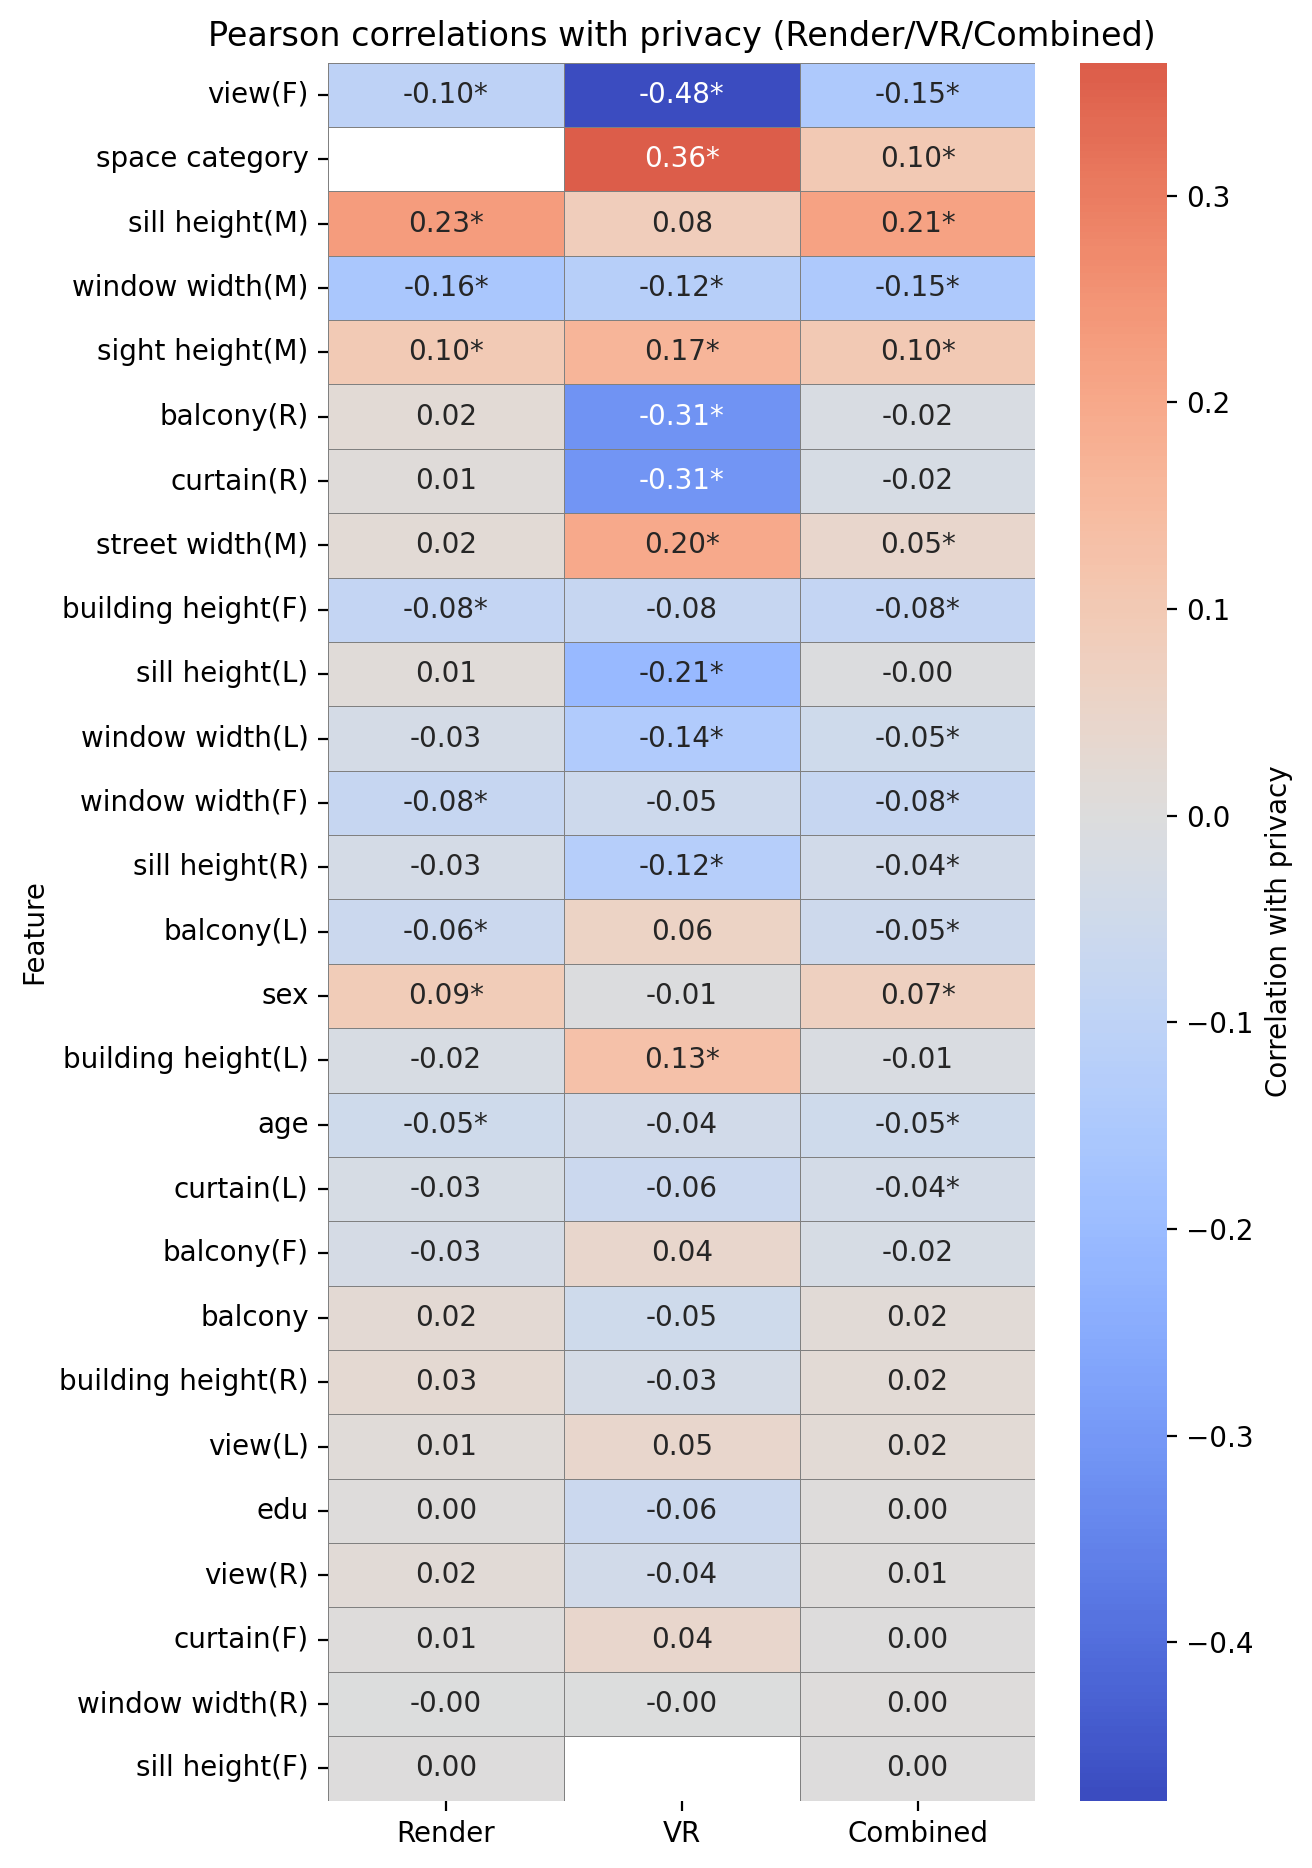

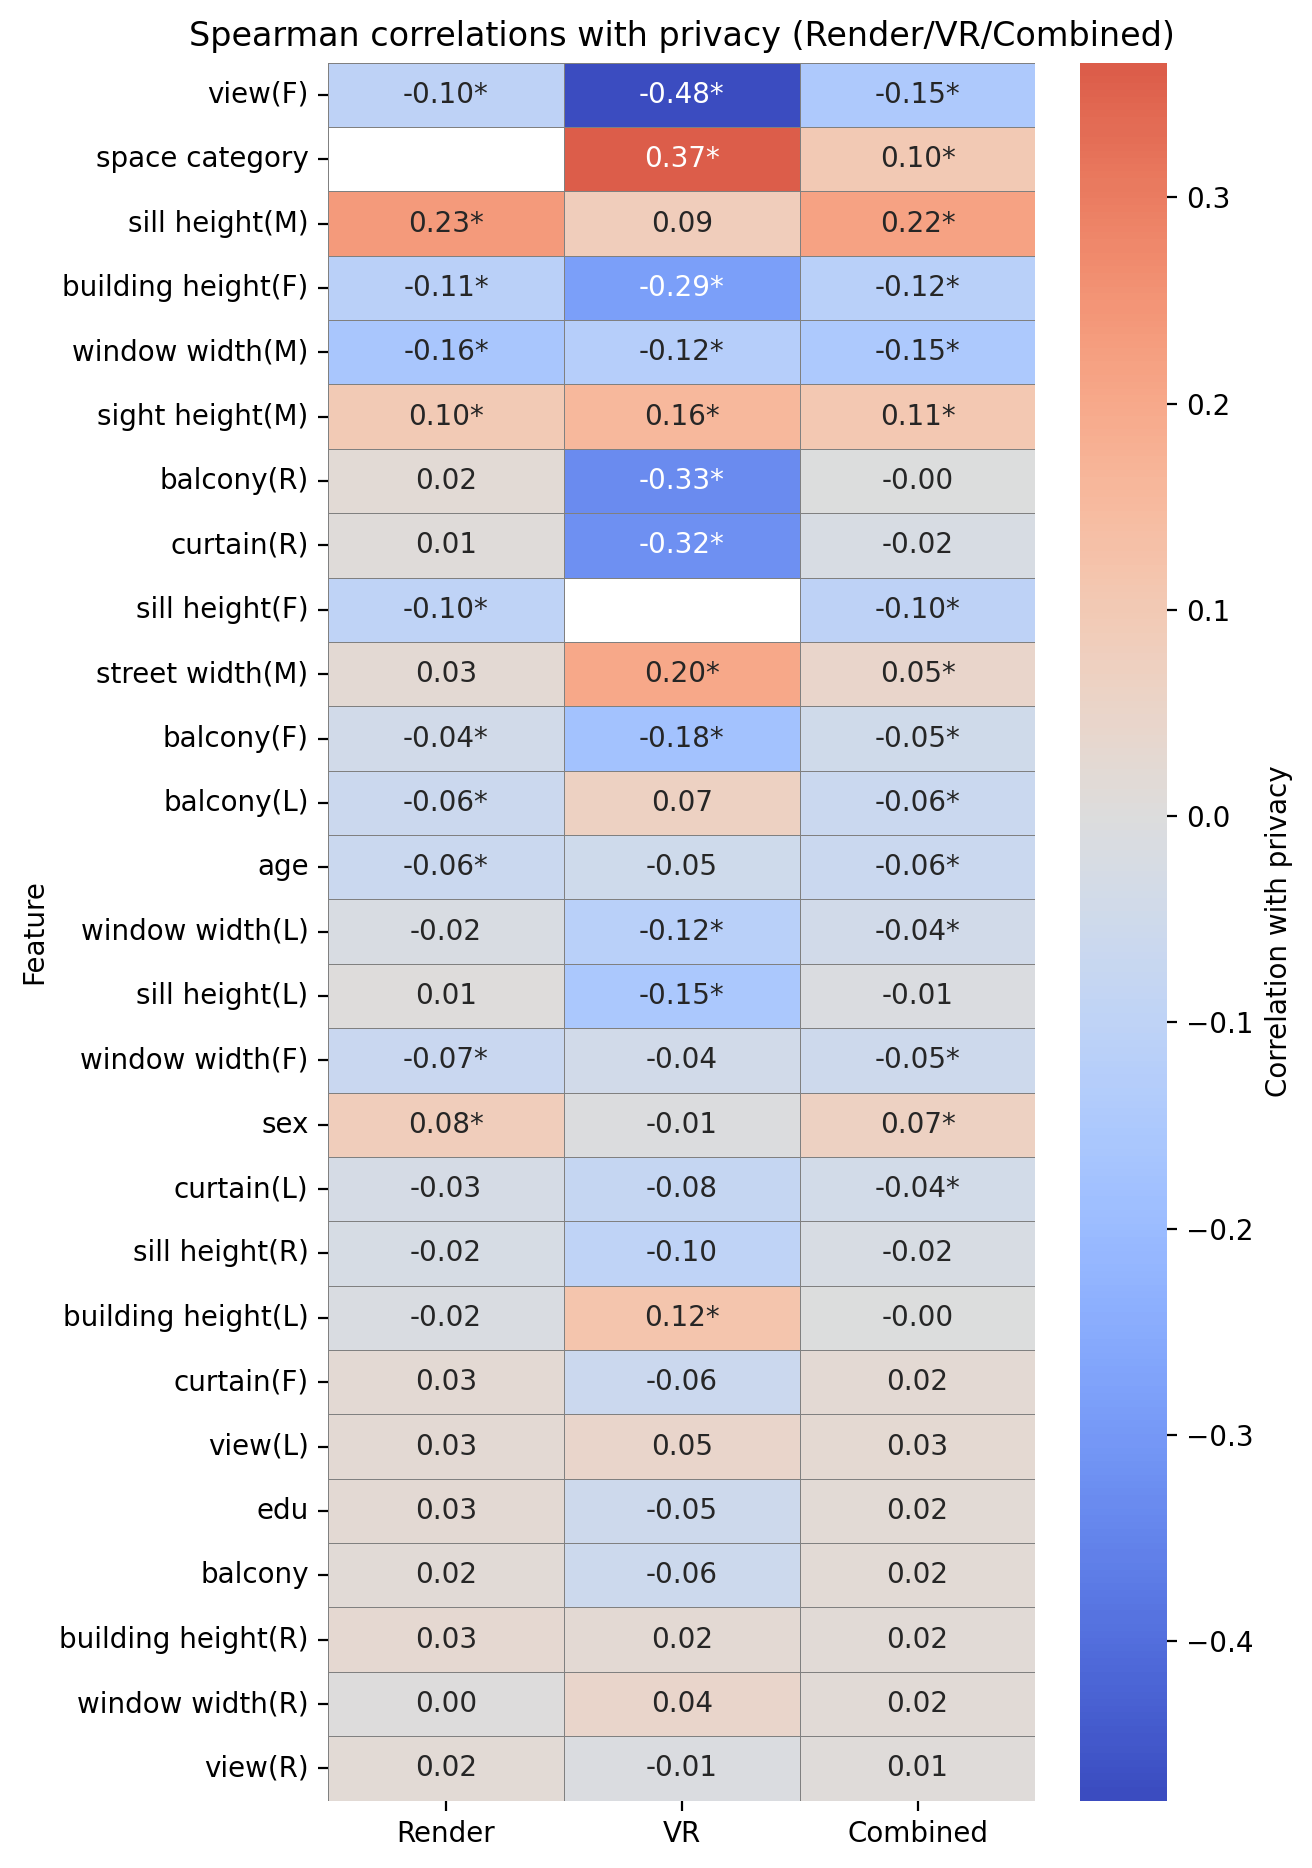

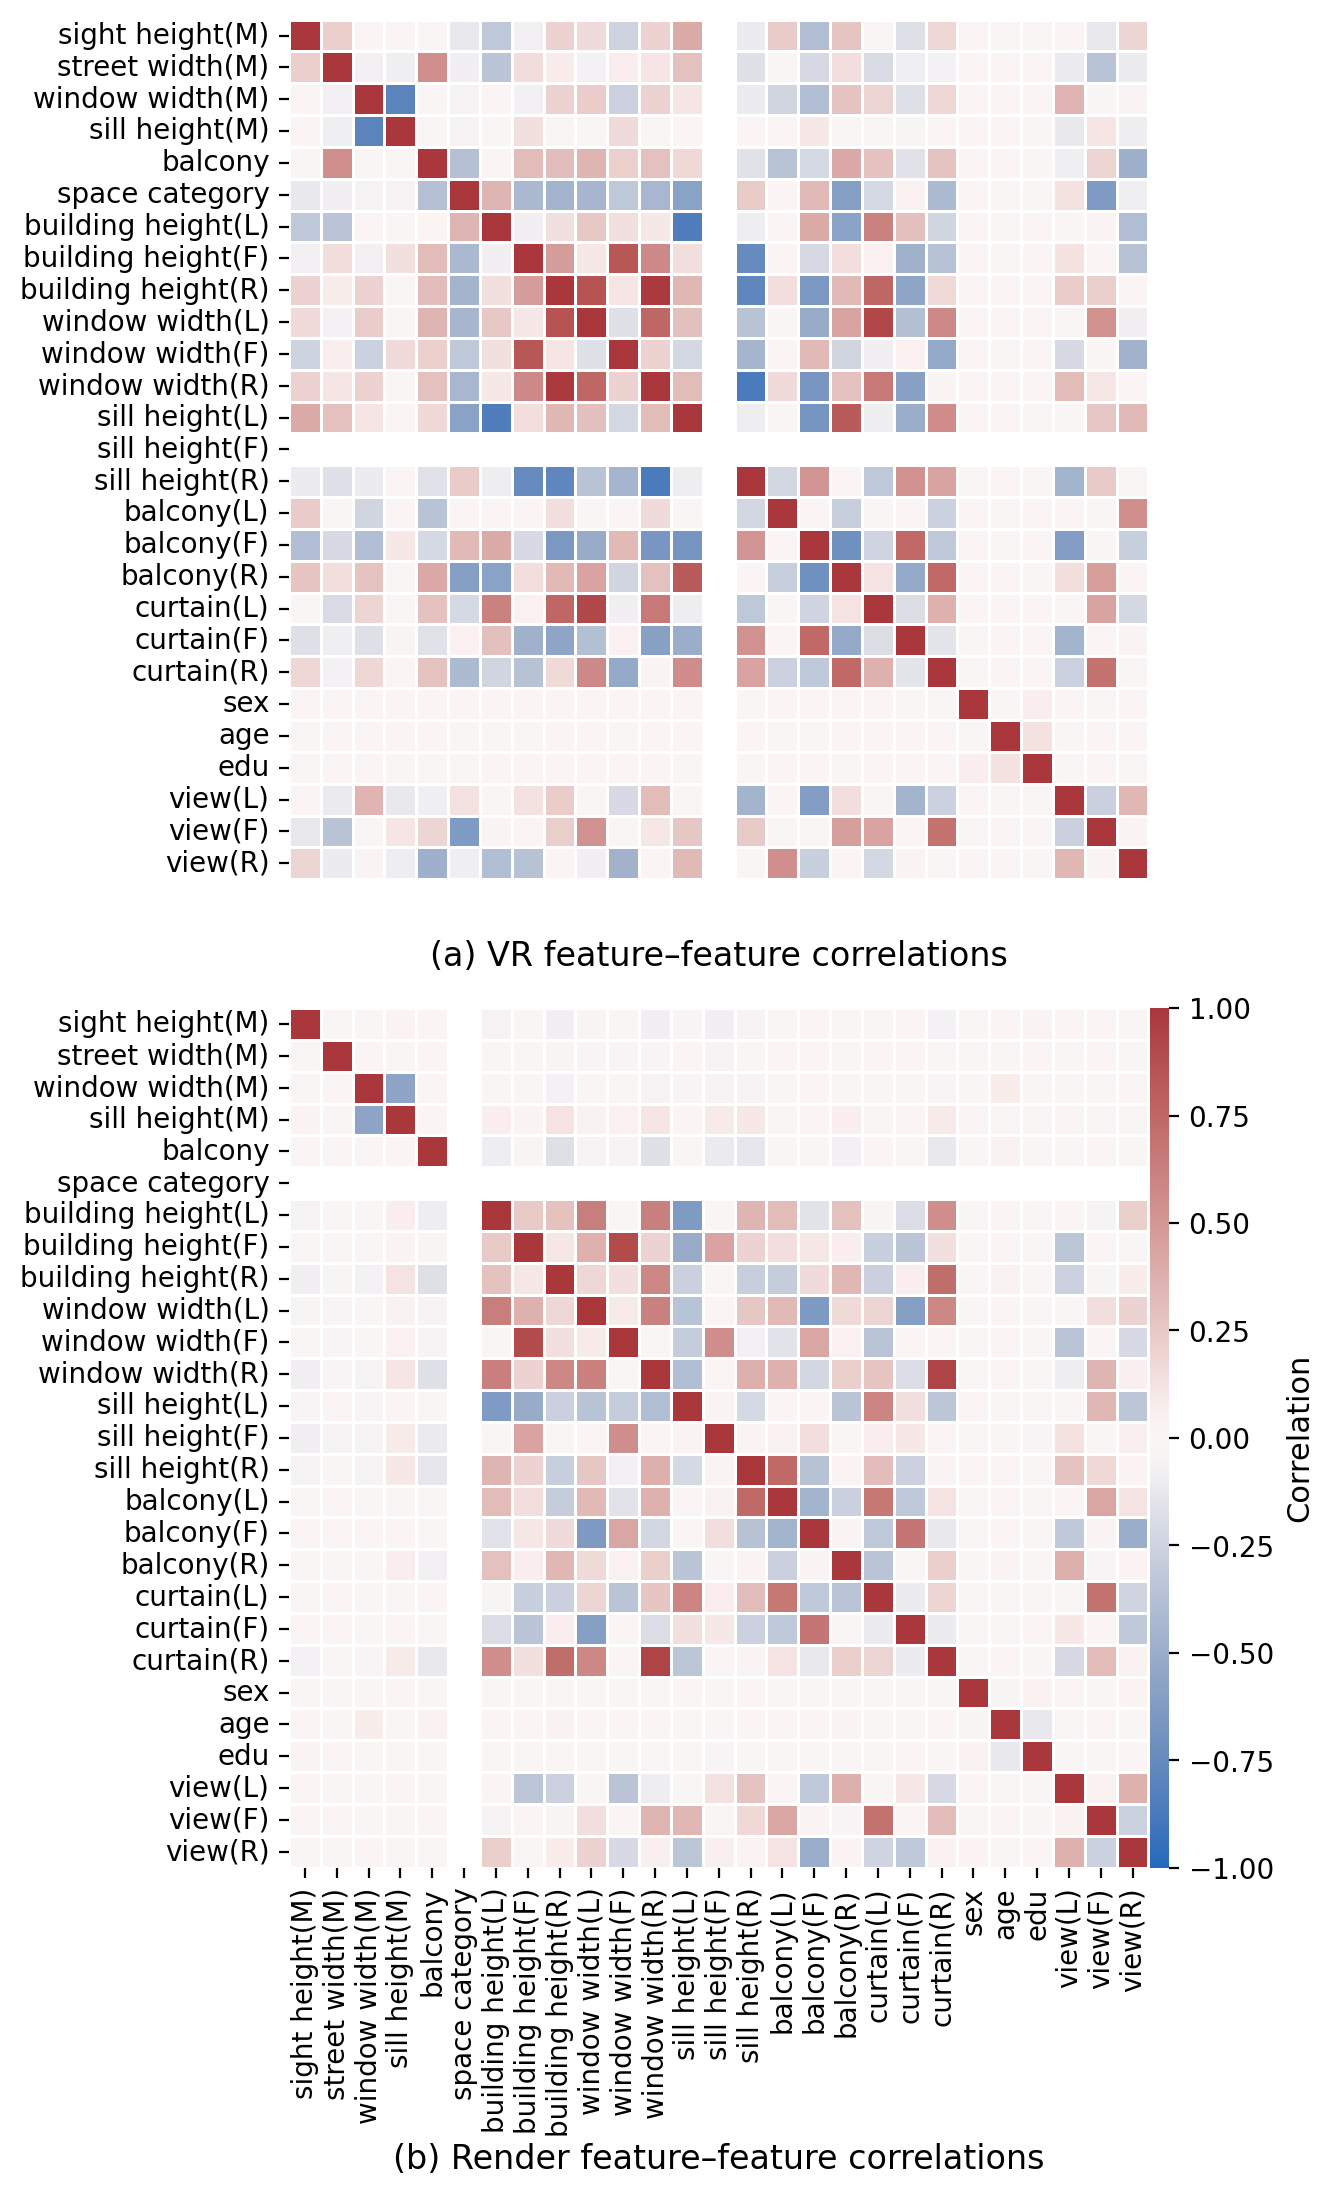

In [7]:
# =========================
# Stage 5 — Exploratory correlations (Pearson/Spearman + BH–FDR)
# =========================
begin_stage(
    "Exploratory correlations (Pearson/Spearman + BH–FDR)",
    "Linear and rank-based marginal signals per modality; BH–FDR controls multiplicity."
)

def _is_num(s):
    return pd.api.types.is_numeric_dtype(s)

def _bh_fdr(pvals):
    """Benjamini–Hochberg FDR (vectorized; stable)."""
    p = np.asarray(pvals, dtype=float)
    if p.size == 0:
        return p
    n = p.size
    order = np.argsort(p)
    p_sorted = p[order]
    ranks = np.arange(1, n + 1, dtype=float)
    q_sorted = p_sorted * n / ranks
    q_sorted = np.minimum.accumulate(q_sorted[::-1])[::-1]
    q_sorted = np.clip(q_sorted, 0, 1)
    q = np.empty_like(q_sorted)
    q[order] = q_sorted
    return q

def _corr_with_privacy(df, target=TARGET):
    rows = []
    if target not in df.columns:
        return pd.DataFrame()
    num_cols = [c for c in df.columns if c != target and _is_num(df[c])]
    for col in num_cols:
        sub = pd.DataFrame({"x": df[col], "y": df[target]}).dropna()
        if len(sub) < 3:
            rows.append({"Feature": col, "pearson_r": np.nan, "pearson_p": np.nan,
                         "spearman_rho": np.nan, "spearman_p": np.nan})
            continue
        try:
            r, p = pearsonr(sub["x"], sub["y"])
        except Exception:
            r, p = np.nan, np.nan
        try:
            rho, pp = spearmanr(sub["x"], sub["y"])
        except Exception:
            rho, pp = np.nan, np.nan
        rows.append({"Feature": col, "pearson_r": r, "pearson_p": p,
                     "spearman_rho": rho, "spearman_p": pp})
    return pd.DataFrame(rows)

# Compute correlations per modality and combined
render_corr = _corr_with_privacy(render)
vr_corr     = _corr_with_privacy(vr)
comb_corr   = _corr_with_privacy(pd.concat([render, vr], ignore_index=True))

# BH–FDR q-values
for dfc in (render_corr, vr_corr, comb_corr):
    if dfc is not None and not dfc.empty:
        dfc["pearson_q"]  = _bh_fdr(dfc["pearson_p"].fillna(1.0).values)
        dfc["spearman_q"] = _bh_fdr(dfc["spearman_p"].fillna(1.0).values)

def _merge3(a, b, c, suffixes=("Render", "VR", "Combined")):
    if (a is None or a.empty) and (b is None or b.empty) and (c is None or c.empty):
        return pd.DataFrame()
    A = (a.add_suffix(f"_{suffixes[0]}") if a is not None and not a.empty else pd.DataFrame())
    B = (b.add_suffix(f"_{suffixes[1]}") if b is not None and not b.empty else pd.DataFrame())
    C = (c.add_suffix(f"_{suffixes[2]}") if c is not None and not c.empty else pd.DataFrame())
    for X, suf in [(A, suffixes[0]), (B, suffixes[1]), (C, suffixes[2])]:
        if not X.empty and f"Feature_{suf}" in X.columns:
            X.rename(columns={f"Feature_{suf}": "Feature"}, inplace=True)
    m = None
    for X in (A, B, C):
        if X is not None and not X.empty:
            m = X if m is None else m.merge(X, on="Feature", how="outer")
    if m is None:
        return pd.DataFrame()
    cols = [
        "Feature",
        "pearson_r_Render","pearson_p_Render","pearson_q_Render",
        "spearman_rho_Render","spearman_p_Render","spearman_q_Render",
        "pearson_r_VR","pearson_p_VR","pearson_q_VR",
        "spearman_rho_VR","spearman_p_VR","spearman_q_VR",
        "pearson_r_Combined","pearson_p_Combined","pearson_q_Combined",
        "spearman_rho_Combined","spearman_p_Combined","spearman_q_Combined"
    ]
    cols = [c for c in cols if c in m.columns] + (["Feature"] if "Feature" not in cols else [])
    cols = list(dict.fromkeys(cols))  # dedupe, preserve order
    return m.loc[:, cols]

corr_all = _merge3(render_corr, vr_corr, comb_corr)

# Save master correlation table
if not corr_all.empty:
    save_and_show_table(
        corr_all.round(3),
        "Correlations with privacy (Pearson/Spearman) with BH–FDR q-values — Render / VR / Combined",
        "tab:corr_privacy",
        "corr_with_privacy",
        why="Linear and rank-based marginal associations; FDR controls for multiple testing."
    )

# -------- Plotting helpers --------
def _heatmap(values_df, q_df, title, out_stem):
    """Create a heatmap and save via our figure saver."""
    if values_df is None or values_df.empty:
        return

    # Decide annotations
    n_cells = int(values_df.shape[0] * max(1, values_df.shape[1]))
    annot = None; fmt = ""
    if n_cells <= 400:
        annot = values_df.copy().astype(object)
        for i in values_df.index:
            for j in values_df.columns:
                qv = q_df.loc[i, j] if (q_df is not None and (i in q_df.index) and (j in q_df.columns)) else np.nan
                try:
                    annot.loc[i, j] = f"{float(values_df.loc[i, j]):.2f}{'*' if (pd.notna(qv) and qv < 0.05) else ''}"
                except Exception:
                    annot.loc[i, j] = ""
        annot = annot.values
    elif n_cells <= 1600:
        if q_df is not None and not q_df.empty:
            annot = pd.DataFrame("", index=values_df.index, columns=values_df.columns)
            cr = values_df.index.intersection(q_df.index)
            cc = values_df.columns.intersection(q_df.columns)
            annot.loc[cr, cc] = np.where((q_df.loc[cr, cc] < 0.05), "*", "")
            annot = annot.values

    fig = plt.figure(figsize=(6.5, max(2.5, 0.35 * len(values_df))))
    ax  = sns.heatmap(
        values_df, annot=annot, fmt=fmt, cmap="coolwarm", center=0.0,
        linewidths=0.3, linecolor="gray", cbar_kws={"label": "Correlation with privacy"}
    )
    for coll in ax.collections:
        try: coll.set_rasterized(True)
        except Exception: pass

    plt.title(title)
    plt.tight_layout()
    save_and_tex(fig, out_stem, title, dpi=200, bbox_inches="tight")
    plt.close(fig)

def _feature_feature_corr(df, drop_cols=("privacy","group_id","Source")):
    keep = [c for c in df.columns if c not in drop_cols and _is_num(df[c])]
    if len(keep) == 0:
        return pd.DataFrame()
    return df[keep].corr()

def _pivot(which="pearson"):
    if corr_all.empty:
        return pd.DataFrame(), pd.DataFrame()
    if which == "pearson":
        cols_v = [("pearson_r_Render","Render"),("pearson_r_VR","VR"),("pearson_r_Combined","Combined")]
        cols_q = [("pearson_q_Render","Render"),("pearson_q_VR","VR"),("pearson_q_Combined","Combined")]
    else:
        cols_v = [("spearman_rho_Render","Render"),("spearman_rho_VR","VR"),("spearman_rho_Combined","Combined")]
        cols_q = [("spearman_q_Render","Render"),("spearman_q_VR","VR"),("spearman_q_Combined","Combined")]
    def _mk(cols):
        use = [(c,new) for c,new in cols if c in corr_all.columns]
        if not use:
            return pd.DataFrame()
        df = corr_all[["Feature"]+[c for c,_ in use]].set_index("Feature")
        df.columns = [new for _,new in use]
        # optional: order features by mean |value|
        df = df.reindex(df.abs().mean(axis=1).sort_values(ascending=False).index)
        return df
    return _mk(cols_v), _mk(cols_q)

# ---- Build Pearson/Spearman heatmaps (keep Pearson in main text) ----
pearson_vals, pearson_qs   = _pivot("pearson")
spearman_vals, spearman_qs = _pivot("spearman")

if not pearson_vals.empty:
    _heatmap(
        pearson_vals, pearson_qs,
        "Pearson correlations with privacy (Render/VR/Combined)",
        "corr_privacy_pearson_heatmap"
    )

# Appendix (optional): Spearman
if not spearman_vals.empty:
    _heatmap(
        spearman_vals, spearman_qs,
        "Spearman correlations with privacy (Render/VR/Combined)",
        "corr_privacy_spearman_heatmap"
    )

# ---- Feature–feature correlation matrices (VR vs Render) ----
corr_ff_vr     = _feature_feature_corr(vr)
corr_ff_render = _feature_feature_corr(render)

if not corr_ff_vr.empty and not corr_ff_render.empty:
    from matplotlib.gridspec import GridSpec
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    fig = plt.figure(figsize=(12, 12), dpi=180)
    gs  = GridSpec(2, 2, width_ratios=[30, 1], height_ratios=[1, 1], wspace=0.02, hspace=0.15)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])

    # (a) VR — no colorbar
    h1 = sns.heatmap(
        corr_ff_vr, ax=ax1, vmin=-1, vmax=1, cmap="vlag",
        cbar=False, square=True, linewidths=0.4
    )
    ax1.set_title("(a) VR feature–feature correlations", y=-0.12)
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
    ax1.set_xlabel("")
    ax1.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    for coll in h1.collections:
        try: coll.set_rasterized(True)
        except Exception: pass

    # Create a slim colorbar axis *before* drawing the Render heatmap
    cax = inset_axes(
        ax2, width="2.2%", height="100%",
        loc="lower left",
        bbox_to_anchor=(1.002, 0.0, 1, 1),  # make smaller (e.g., 1.000) to get even closer
        bbox_transform=ax2.transAxes,
        borderpad=0
    )

    # (b) Render — uses the slim cbar axis
    h2 = sns.heatmap(
        corr_ff_render, ax=ax2, vmin=-1, vmax=1, cmap="vlag",
        cbar_ax=cax, cbar=True, square=True, linewidths=0.4
    )
    ax2.set_title("(b) Render feature–feature correlations", y=-0.37)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
    for coll in h2.collections:
        try: coll.set_rasterized(True)
        except Exception: pass

    cax.set_ylabel("Correlation", fontsize=11)
    fig.tight_layout()
    save_and_tex(fig, "feature_feature_corr_VR_vs_Render",
                 "Feature–feature correlations (VR vs Render)", dpi=200, bbox_inches="tight")
    plt.close(fig)

# ---- Top-|r| summary table (orientation only; Pearson) ----
def _top_abs(dfc, r_col, q_col, k=15, tag="DATA"):
    if dfc is None or dfc.empty:
        return pd.DataFrame()
    d = dfc.loc[:, ["Feature", r_col, q_col]].copy().dropna()
    if d.empty:
        return pd.DataFrame()
    d["abs"] = d[r_col].abs()
    d.sort_values("abs", ascending=False, inplace=True)
    return d.head(k).rename(columns={r_col: f"{tag}_r", q_col: f"{tag}_q"})[["Feature", f"{tag}_r", f"{tag}_q"]]

tops = []
t = _top_abs(render_corr, "pearson_r", "pearson_q", tag="Render")
if not t.empty: tops.append(t)
t = _top_abs(vr_corr, "pearson_r", "pearson_q", tag="VR")
if not t.empty: tops.append(t)
t = _top_abs(comb_corr, "pearson_r", "pearson_q", tag="Combined")
if not t.empty: tops.append(t)

if tops:
    top_tbl = tops[0]
    for t in tops[1:]:
        top_tbl = top_tbl.merge(t, on="Feature", how="outer")
    save_table(
        top_tbl.round(3),
        "Top |Pearson r| with privacy (BH–FDR q shown) — per modality",
        "tab:corr_top_abs",
        "corr_top_abs",
        why="Highlights strongest linear associations before modeling; for orientation only."
    )


## Stage 6 — Baselines + Group-aware model selection

In [8]:
# =========================
# Stage 6 — Baselines + Group-aware model selection
# =========================
begin_stage(
    "Baselines + Group-aware model selection",
    "Quick baselines, then GroupKFold RandomizedSearchCV per family; "
    "report test metrics and plots."
)

# ---------- Baselines ----------
def eval_baselines(train, test, prefix):
    from sklearn.ensemble import GradientBoostingRegressor  # local import ok
    Xtr, ytr = train.drop(columns=[TARGET]), train[TARGET]
    Xte, yte = test.drop(columns=[TARGET]),  test[TARGET]
    rows = []

    # Mean baseline
    ypred = np.full_like(yte.to_numpy(), float(ytr.mean()), dtype=float)
    rows.append(("Mean baseline",
                 RMSE(yte, ypred), mean_absolute_error(yte, ypred), r2_score(yte, ypred)))

    # Linear Regression
    lr = LinearRegression().fit(Xtr, ytr)
    ypred = lr.predict(Xte)
    rows.append(("Linear Regression",
                 RMSE(yte, ypred), mean_absolute_error(yte, ypred), r2_score(yte, ypred)))

    # Quantile-GBR (median + tails)
    for alpha, name in [(0.5, "GBR-Quantile-0.5 (median)"),
                        (0.1, "GBR-Quantile-0.1"),
                        (0.9, "GBR-Quantile-0.9")]:
        gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, random_state=42).fit(Xtr, ytr)
        ypred = gbr.predict(Xte)
        rows.append((name,
                     RMSE(yte, ypred), mean_absolute_error(yte, ypred), r2_score(yte, ypred)))

    df = pd.DataFrame(rows, columns=["Model","RMSE","MAE","R2"]).round(3)
    save_and_show_table(df, f"Baselines on {prefix}",
                        f"tab:base_{_slug(prefix)}", f"baseline_{_slug(prefix)}")
    return df

_ = eval_baselines(train_render,   test_render,   "Render")
_ = eval_baselines(train_vr,       test_vr,       "VR")
_ = eval_baselines(train_combined, test_combined, "Combined")

# ---------- Candidate families ----------
MODELS = {
    'XGBoost Regressor': XGBRegressor(random_state=42, tree_method="hist", eval_metric="rmse", n_jobs=-1),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'SVR': SVR(),
    'KNN Regressor': KNeighborsRegressor(),
    'Linear Regression': LinearRegression(),
    'Huber Regression': HuberRegressor()
}

# Parameter search spaces
PARAMS = {
    'XGBoost Regressor': {
        'regressor__n_estimators': [300, 500],
        'regressor__learning_rate': [0.03, 0.05, 0.08],
        'regressor__max_depth': [4,5,6],
        'regressor__subsample': [0.8, 0.9, 1.0],
        'regressor__colsample_bytree': [0.8, 0.9, 1.0]
    },
    'Random Forest Regressor': {
        'regressor__n_estimators': randint(200, 700),
        'regressor__max_depth': [None] + list(range(5, 31, 5)),
        'regressor__min_samples_split': randint(2, 12),
        'regressor__max_features': ['sqrt', 'log2', None],
        'regressor__bootstrap': [True, False],
    },
    'Gradient Boosting Regressor': {
        'regressor__n_estimators': [300, 500],
        'regressor__learning_rate': [0.03, 0.05, 0.08],
        'regressor__max_depth': randint(2, 8),
        'regressor__subsample': uniform(0.7, 0.3),
    },
    'Decision Tree Regressor': {
        'regressor__max_depth': [None] + list(range(5, 31, 5)),
        'regressor__min_samples_split': randint(2, 12),
        'regressor__min_samples_leaf': randint(1, 6),
    },
    'SVR': {
        'regressor__C': loguniform(1e-2, 1e2),
        'regressor__epsilon': loguniform(1e-3, 1e0),
        'regressor__kernel': ['linear', 'rbf'],
        'regressor__gamma': ['scale', 'auto'],
    },
    'KNN Regressor': {
        'regressor__n_neighbors': randint(3, 30),
        'regressor__weights': ['uniform', 'distance'],
        'regressor__p': [1, 2],
    },
    'Linear Regression': {},  # nothing to tune
    'Huber Regression': { 'regressor__epsilon': [1.2, 1.5, 2.0] }
}

TREEY = {'Decision Tree Regressor','Random Forest Regressor','Gradient Boosting Regressor','XGBoost Regressor'}

def mkpipe(name, model):
    """Scale only non-tree models."""
    if name in TREEY:
        return Pipeline([('regressor', model)])
    elif name in {'Huber Regression', 'SVR', 'KNN Regressor', 'Linear Regression'}:
        return Pipeline([('scaler', StandardScaler()), ('regressor', model)])
    else:
        return Pipeline([('regressor', model)])

def groups_from_groupcols(df, group_cols=GROUP_COLS):
    cols = [c for c in group_cols if c in df.columns]
    return df[cols].astype(str).agg('_'.join, axis=1).values

def _fmt_params(d):
    if not d: return "(fixed)"
    return ", ".join(f"{k.split('__')[-1]}={v}" for k,v in d.items())

def _filter_param_space(estimator, space):
    """Drop grid keys that the pipeline does not expose (prevents set_params errors)."""
    if not space:
        return {}
    valid = set(estimator.get_params().keys())
    filtered, dropped = {}, []
    for k, v in space.items():
        if k in valid: filtered[k] = v
        else: dropped.append(k)
    if dropped:
        _print("[SEARCH][WARN] Dropping unsupported params: " + ", ".join(sorted(dropped)))
    return filtered

def _fit_search(pipe, name, X, y, groups, param_spaces):
    """Group-aware randomized search (n_iter=40). Retries single-threaded if parallelism fails."""
    n_groups = len(np.unique(groups))
    n_splits = max(2, min(5, n_groups))
    cv = GroupKFold(n_splits=n_splits)

    space = _filter_param_space(pipe, param_spaces.get(name, {}) or {})
    if not space:
        _print(f"[SEARCH] {name}: fixed evaluation (no hyperparameters).")
        pipe.fit(X, y)
        class _Shim:
            best_estimator_ = pipe
            best_params_ = {}
        return _Shim()

    search = RandomizedSearchCV(
        pipe, param_distributions=space,
        n_iter=40, cv=cv, n_jobs=-1,
        scoring='neg_mean_squared_error', random_state=42,
        error_score='raise'
    )

    try:
        search.fit(X, y, groups=groups)
    except Exception as e:
        try:
            _print(f"[SEARCH][WARN] {name}: retrying with n_jobs=1 due to error: {e}")
            search = RandomizedSearchCV(
                pipe, param_distributions=space,
                n_iter=40, cv=cv, n_jobs=1,
                scoring='neg_mean_squared_error', random_state=42,
                error_score='raise'
            )
            search.fit(X, y, groups=groups)
        except Exception as ee:
            raise ee

    _print(f"[SEARCH][DONE] {name}: best params = {_fmt_params(search.best_params_)}")
    return search

def evaluate_groupaware(models, params, train, test, tag="DATA"):
    """
    Run group-aware search, evaluate each best model on the holdout test,
    save an ordered performance table and diagnostic plots.
    """
    groups_train = groups_from_groupcols(train, GROUP_COLS)
    Xtr, ytr = train.drop(columns=[TARGET]), train[TARGET]
    Xte, yte = test.drop(columns=[TARGET]),  test[TARGET]
    rows = []; best_map = {}

    for name, model in models.items():
        _print(f"[TRAIN] {tag}: {name} — Group-aware CV search…")
        pipe = mkpipe(name, model)
        search = _fit_search(pipe, name, Xtr, ytr, groups_train, params)
        best = search.best_estimator_; best_map[name] = best

        ypred = best.predict(Xte)
        rmse = RMSE(yte, ypred); mae = mean_absolute_error(yte, ypred); r2 = r2_score(yte, ypred)
        _print(f"[EVAL] {tag}: {name} — Test RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")
        rows.append({"Model": name,
                     "BestParams": _fmt_params(search.best_params_) if getattr(search, "best_params_", None) else "(fixed)",
                     "RMSE": rmse, "MAE": mae, "R2": r2})

        # # ---- Actual vs Predicted plot (FIXED: pass FIGURE, not a path) ----
        # fig = plt.figure(figsize=(5,5))
        # sns.scatterplot(x=yte, y=ypred, s=18)
        # lim = [min(float(np.min(yte)), float(np.min(ypred))),
        #        max(float(np.max(yte)), float(np.max(ypred)))]
        # plt.plot(lim, lim, ls="--")
        # plt.xlim(lim); plt.ylim(lim)
        # plt.xlabel("Actual"); plt.ylabel("Predicted")
        # plt.title(f"{tag}: {name} — Actual vs Predicted")
        # plt.tight_layout()
        # save_and_tex(
        #     fig,
        #     f"{_slug(tag)}_{_slug(name)}_pred_vs_actual",
        #     f"{tag}/{name}: Predictions vs ground truth (GroupKFold; diagonal is perfect).",
        #     dpi=200, bbox_inches="tight"
        # )
        # plt.close(fig)

    df = pd.DataFrame(rows).sort_values("R2", ascending=False)
    save_and_show_table(
        df.assign(RMSE=lambda d: d.RMSE.round(3),
                  MAE=lambda d: d.MAE.round(3),
                  R2=lambda d: d.R2.round(3)),
        f"Model performance on {tag} (GroupKFold; sorted by R²)",
        f"tab:perf_{_slug(tag)}", f"perf_{_slug(tag)}",
        why="Group-aware CV prevents scenario leakage; test R² used for ranking."
    )
    return df, best_map

# Run the selection on all domains
res_render, best_render = evaluate_groupaware(MODELS, PARAMS, train_render,   test_render,   tag="Render")
res_vr,     best_vr     = evaluate_groupaware(MODELS, PARAMS, train_vr,       test_vr,       tag="VR")
res_comb,   best_comb   = evaluate_groupaware(MODELS, PARAMS, train_combined, test_combined, tag="Combined")

def best_name_and_est(res_df, best_map):
    row = res_df.iloc[0]
    return row["Model"], best_map[row["Model"]]

name_r_best, est_r_best = best_name_and_est(res_render, best_render)
name_v_best, est_v_best = best_name_and_est(res_vr,     best_vr)
name_c_best, est_c_best = best_name_and_est(res_comb,   best_comb)


## Stage 7 — Scenario weights (inverse-frequency) + weighted evaluation

In [9]:
# =========================
# Stage 7 — Scenario weights (inverse-frequency) + weighted evaluation
# =========================
begin_stage(
    "Scenario weights (inverse-frequency) + weighted evaluation",
    "Down-weight over-represented scenarios; re-run baselines/selection in parallel."
)

# ---- Group hashing + counts -------------------------------------------------
def _ghash(df, cols=GROUP_COLS):
    cols = [c for c in cols if c in df.columns]
    if not cols:
        # Fallback: every row is its own group
        return pd.Series(np.arange(len(df)), index=df.index).astype(str)
    return df[cols].astype(str).agg('_'.join, axis=1)

# Frequency tables from the *full* cleaned datasets (reflect global prevalence)
render_counts = _ghash(render, GROUP_COLS).value_counts()
vr_counts     = _ghash(vr,     GROUP_COLS).value_counts()

def group_equal_weights(df, counts):
    g = _ghash(df, GROUP_COLS)
    # inverse-frequency; guard against missing keys and zero division
    w = g.map(lambda k: 1.0 / max(1, int(counts.get(k, 1)))).astype(float).to_numpy()
    # normalize for stability (mean ~ 1.0)
    return w / np.mean(w)

# Train/test weights
w_render_tr = group_equal_weights(train_render, render_counts)
w_vr_tr     = group_equal_weights(train_vr,     vr_counts)
w_comb_tr   = np.concatenate([w_render_tr, w_vr_tr])

w_render_te = group_equal_weights(test_render, render_counts)
w_vr_te     = group_equal_weights(test_vr,     vr_counts)
w_comb_te   = np.concatenate([w_render_te, w_vr_te])

stage_note("Weights computed for optional parallel runs; primary selection remains unweighted.")

# ---- Safe sample_weight plumbing -------------------------------------------
from inspect import signature

def _accepts_sample_weight(estimator) -> bool:
    try:
        return 'sample_weight' in signature(estimator.fit).parameters
    except Exception:
        return False

def _fit_params_for_pipeline(pipe, sample_weight):
    """Hand sample_weight only to final regressor if it supports it."""
    if sample_weight is None:
        return {}
    try:
        reg = pipe.named_steps.get('regressor', None)
        if reg is not None and _accepts_sample_weight(reg):
            return {'regressor__sample_weight': sample_weight}
    except Exception:
        pass
    return {}

# ---- Weighted baselines -----------------------------------------------------
def eval_baselines_weighted(train, test, prefix, sw_tr=None, sw_te=None):
    from sklearn.ensemble import GradientBoostingRegressor
    Xtr, ytr = train.drop(columns=[TARGET]), train[TARGET]
    Xte, yte = test.drop(columns=[TARGET]),  test[TARGET]
    rows = []

    # Mean baseline (weighted on train)
    mu = np.average(ytr, weights=sw_tr) if sw_tr is not None else float(ytr.mean())
    ypred = np.full_like(yte.to_numpy(), float(mu), dtype=float)
    rmse = np.sqrt(mean_squared_error(yte, ypred, sample_weight=sw_te))
    mae  = mean_absolute_error(yte, ypred, sample_weight=sw_te)
    r2   = r2_score(yte, ypred, sample_weight=sw_te)
    rows.append(("Mean baseline (w)", rmse, mae, r2))

    # Linear Regression
    lr = LinearRegression()
    fit_params = {'sample_weight': sw_tr} if _accepts_sample_weight(lr) and sw_tr is not None else {}
    lr.fit(Xtr, ytr, **fit_params)
    ypred = lr.predict(Xte)
    rows.append(("Linear Regression (w)",
                 np.sqrt(mean_squared_error(yte, ypred, sample_weight=sw_te)),
                 mean_absolute_error(yte, ypred, sample_weight=sw_te),
                 r2_score(yte, ypred, sample_weight=sw_te)))

    # Quantile-GBR (median + tails)
    for alpha, name in [(0.5,"GBR-Quantile-0.5 (median)"), (0.1,"GBR-Quantile-0.1"), (0.9,"GBR-Quantile-0.9")]:
        gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, random_state=42)
        fit_params = {'sample_weight': sw_tr} if _accepts_sample_weight(gbr) and sw_tr is not None else {}
        gbr.fit(Xtr, ytr, **fit_params)
        ypred = gbr.predict(Xte)
        rows.append((name + " (w)",
                     np.sqrt(mean_squared_error(yte, ypred, sample_weight=sw_te)),
                     mean_absolute_error(yte, ypred, sample_weight=sw_te),
                     r2_score(yte, ypred, sample_weight=sw_te)))

    df = pd.DataFrame(rows, columns=["Model","RMSE","MAE","R2"]).round(3)
    save_and_show_table(df, f"Weighted baselines on {prefix}",
                        f"tab:base_w_{_slug(prefix)}", f"baseline_w_{_slug(prefix)}")
    return df

_ = eval_baselines_weighted(train_render,   test_render,   "Render",   w_render_tr, w_render_te)
_ = eval_baselines_weighted(train_vr,       test_vr,       "VR",       w_vr_tr,     w_vr_te)
_ = eval_baselines_weighted(train_combined, test_combined, "Combined", w_comb_tr,   w_comb_te)

# ---- Weighted model selection (parallel to unweighted) ----------------------
def evaluate_groupaware_weighted(models, params, train, test, tag="DATA (weighted)", sw_tr=None, sw_te=None):
    groups_train = _ghash(train, GROUP_COLS).values  # same grouping as unweighted
    Xtr, ytr = train.drop(columns=[TARGET]), train[TARGET]
    Xte, yte = test.drop(columns=[TARGET]),  test[TARGET]
    rows = []; best_map = {}

    for name, model in models.items():
        _print(f"[TRAIN][W] {tag}: {name} — Group-aware CV search (weighted)…")
        pipe = mkpipe(name, model)
        fit_params = _fit_params_for_pipeline(pipe, sw_tr)

        n_groups = len(np.unique(groups_train))
        n_splits = max(2, min(5, n_groups))
        cv = GroupKFold(n_splits=n_splits)

        space = _filter_param_space(pipe, PARAMS.get(name, {}) or {})
        if not space:
            _print(f"[SEARCH] {name}: fixed evaluation (no hyperparameters).")
            pipe.fit(Xtr, ytr, **fit_params)
            best = pipe; best_params = {}
        else:
            search = RandomizedSearchCV(
                pipe, param_distributions=space,
                n_iter=40, cv=cv, n_jobs=-1,
                scoring='neg_mean_squared_error', random_state=42,
                error_score='raise'
            )
            try:
                search.fit(Xtr, ytr, groups=groups_train, **fit_params)
            except Exception as e:
                _print(f"[SEARCH][WARN] {name}: retrying with n_jobs=1 due to error: {e}")
                search = RandomizedSearchCV(
                    pipe, param_distributions=space,
                    n_iter=40, cv=cv, n_jobs=1,
                    scoring='neg_mean_squared_error', random_state=42,
                    error_score='raise'
                )
                search.fit(Xtr, ytr, groups=groups_train, **fit_params)

            best = search.best_estimator_; best_params = search.best_params_

        best_map[name] = best
        ypred = best.predict(Xte)
        rmse = np.sqrt(mean_squared_error(yte, ypred, sample_weight=sw_te))
        mae  = mean_absolute_error(yte, ypred, sample_weight=sw_te)
        r2   = r2_score(yte, ypred, sample_weight=sw_te)
        _print(f"[EVAL][W] {tag}: {name} — Test RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")
        rows.append({"Model": name,
                     "BestParams": _fmt_params(best_params) if best_params else "(fixed)",
                     "RMSE": rmse, "MAE": mae, "R2": r2})

        # fig = plt.figure(figsize=(5,5))
        # sns.scatterplot(x=yte, y=ypred, s=18)
        # lim = [min(float(np.min(yte)), float(np.min(ypred))),
        #        max(float(np.max(yte)), float(np.max(ypred)))]
        # plt.plot(lim, lim, ls="--"); plt.xlim(lim); plt.ylim(lim)
        # plt.xlabel("Actual"); plt.ylabel("Predicted")
        # plt.title(f"{tag}: {name} — Actual vs Predicted (weighted)")
        # plt.tight_layout()
        # save_and_tex(
        #     fig,
        #     f"{_slug(tag)}_{_slug(name)}_pred_vs_actual",
        #     f"{tag}/{name}: Predictions vs ground truth (GroupKFold; diagonal is perfect).",
        #     dpi=200, bbox_inches="tight"
        # )
        # plt.close(fig)

    df = pd.DataFrame(rows).sort_values("R2", ascending=False)
    save_and_show_table(
        df.assign(RMSE=lambda d: d.RMSE.round(3),
                  MAE=lambda d: d.MAE.round(3),
                  R2=lambda d: d.R2.round(3)),
        f"Model performance on {tag} (GroupKFold; weighted; sorted by R²)",
        f"tab:perf_w_{_slug(tag)}", f"perf_w_{_slug(tag)}",
        why="Weights reduce dominance of frequent scenarios; metrics computed with sample_weight."
    )
    return df, best_map

# Run weighted selection (parallel, optional)
res_render_w, best_render_w = evaluate_groupaware_weighted(MODELS, PARAMS, train_render,   test_render,
                                                           tag="Render (weighted)",
                                                           sw_tr=w_render_tr, sw_te=w_render_te)
res_vr_w,     best_vr_w     = evaluate_groupaware_weighted(MODELS, PARAMS, train_vr,       test_vr,
                                                           tag="VR (weighted)",
                                                           sw_tr=w_vr_tr,     sw_te=w_vr_te)
res_comb_w,   best_comb_w   = evaluate_groupaware_weighted(MODELS, PARAMS, train_combined, test_combined,
                                                           tag="Combined (weighted)",
                                                           sw_tr=w_comb_tr,   sw_te=w_comb_te)


## Stage 8 — Noise ceilings (ICC-like)

In [10]:
# =========================
# Stage 8 — Noise ceilings (ICC-like)
# =========================
begin_stage(
    "Noise ceilings (ICC-like)",
    "Upper bound on explainable variance per scenario; compare achieved R² to ceilings."
)

def noise_ceiling_icc_like(df_with_gid: pd.DataFrame) -> float:
    """
    ICC-like ceiling using group_id as 'target scenario'.
    Returns np.nan if insufficient groups/df shape. Clipped to [-1, 1] for stability.
    """
    d = df_with_gid
    if "group_id" not in d.columns or TARGET not in d.columns:
        return np.nan
    grp = d.groupby("group_id")[TARGET]
    n_groups = grp.ngroups; n = len(d)
    if n_groups < 2 or n <= n_groups:
        return np.nan

    m = grp.size().values            # per-group counts
    k_bar = float(m.mean())          # average replicates per group
    ybar = float(d[TARGET].mean())

    ss_between = ((grp.mean() - ybar)**2 * m).sum()
    ss_within  = grp.apply(lambda s: ((s - float(s.mean()))**2).sum()).sum()

    ms_between = ss_between / (n_groups - 1) if n_groups > 1 else 0.0
    ms_within  = ss_within  / (n - n_groups) if (n - n_groups) > 0 else 0.0

    # One-way random effects ICC(1,k)-like upper bound
    icc = (ms_between - ms_within) / (ms_between + (k_bar - 1.0) * ms_within + 1e-12)
    return float(np.clip(icc, -1.0, 1.0))

# Ceilings by domain (requires render/vr to still have group_id — they do after Stage 4)
render_icc = noise_ceiling_icc_like(render)
vr_icc     = noise_ceiling_icc_like(vr)
comb_icc   = noise_ceiling_icc_like(pd.concat([render, vr], ignore_index=True))

df_icc = pd.DataFrame({
    "Domain": ["Render","VR","Combined"],
    "ICC_like_ceiling": [
        round(render_icc, 3) if np.isfinite(render_icc) else np.nan,
        round(vr_icc,     3) if np.isfinite(vr_icc)     else np.nan,
        round(comb_icc,   3) if np.isfinite(comb_icc)   else np.nan
    ]
})

# Optionally compare to achieved R^2 (max across models) if previous tables are in scope
def _max_r2_safe(df_or_none):
    try:
        return float(np.nanmax(df_or_none["R2"].values))
    except Exception:
        return np.nan

compare_rows = []
compare_rows.append({
    "Domain": "Render",
    "Best_R2_unweighted": _max_r2_safe(globals().get("res_render")),
    "Best_R2_weighted":   _max_r2_safe(globals().get("res_render_w"))
})
compare_rows.append({
    "Domain": "VR",
    "Best_R2_unweighted": _max_r2_safe(globals().get("res_vr")),
    "Best_R2_weighted":   _max_r2_safe(globals().get("res_vr_w"))
})
compare_rows.append({
    "Domain": "Combined",
    "Best_R2_unweighted": _max_r2_safe(globals().get("res_comb")),
    "Best_R2_weighted":   _max_r2_safe(globals().get("res_comb_w"))
})
df_compare = pd.DataFrame(compare_rows)

# Merge if available
try:
    df_icc_out = df_icc.merge(df_compare, on="Domain", how="left")
except Exception:
    df_icc_out = df_icc.copy()

save_and_show_table(
    df_icc_out,
    "ICC-like ceilings by domain (with best achieved R² if available)",
    "tab:icc_domains", "icc_domains",
    why="Upper bound on explainable variance; compare achieved R² to this ceiling."
)


## Stage 9 — Transfer learning (Render ↔ VR)

In [11]:
# =========================
# Stage 9 — Transfer learning (Render ↔ VR)
# =========================
begin_stage(
    "Transfer learning (Render ↔ VR)",
    "Compare VR-only baseline vs. several transfer strategies using XGBoost and teacher→student feature transfer."
)

from sklearn.base import clone

def _fit_eval(estimator, train_df, test_df):
    """
    Fit clone(estimator) on train_df; evaluate on test_df; return (rmse, mae, r2, fitted_model).
    """
    Xtr, ytr = train_df.drop(columns=[TARGET]), train_df[TARGET]
    Xte, yte = test_df.drop(columns=[TARGET]), test_df[TARGET]
    m = clone(estimator).fit(Xtr, ytr)
    yhat = m.predict(Xte)
    return RMSE(yte, yhat), mean_absolute_error(yte, yhat), r2_score(yte, yhat), m

def _xgb_pretrain_then_finetune(train_df, test_df, pretrain_df, *,
                                pre_n_estimators=300, pre_lr=0.05,
                                ft_n_estimators=150,  ft_lr=0.02,
                                max_depth=5, subsample=0.9, colsample=0.8):
    """
    Transfer with XGBRegressor:
      1) Pretrain on 'pretrain_df'
      2) Fine-tune on 'train_df'
      3) Evaluate on 'test_df'
    Assumes aligned feature columns across domains (ensured earlier).
    """
    Xtr, ytr  = train_df.drop(columns=[TARGET]), train_df[TARGET]
    Xte, yte  = test_df.drop(columns=[TARGET]),  test_df[TARGET]
    Xpre, ypre= pretrain_df.drop(columns=[TARGET]), pretrain_df[TARGET]

    # 1) Pretrain
    base = XGBRegressor(
        n_estimators=pre_n_estimators, learning_rate=pre_lr, max_depth=max_depth,
        subsample=subsample, colsample_bytree=colsample,
        random_state=42, tree_method="hist", eval_metric="rmse", n_jobs=-1
    )
    base.fit(Xpre, ypre)

    # 2) Fine-tune (continue training from base booster)
    ft = XGBRegressor(
        n_estimators=ft_n_estimators, learning_rate=ft_lr, max_depth=max_depth,
        subsample=subsample, colsample_bytree=colsample,
        random_state=42, tree_method="hist", eval_metric="rmse", n_jobs=-1
    )
    ft.fit(Xtr, ytr, xgb_model=base.get_booster())

    yhat = ft.predict(Xte)
    rmse = RMSE(yte, yhat); mae = mean_absolute_error(yte, yhat); r2 = r2_score(yte, yhat)
    return rmse, mae, r2, ft

def _teacher_feature_transfer(render_train_df, vr_train_df, vr_test_df, student_estimator):
    """
    Teacher→Student feature transfer:
      1) Train teacher on Render(train) (XGB).
      2) Teacher predicts on VR(train/test); append as 'teacher_pred'.
      3) Train student (clone of 'student_estimator' == VR-best family) on augmented VR(train), eval on augmented VR(test).
    """
    # Teacher on Render(train)
    X_r, y_r = render_train_df.drop(columns=[TARGET]), render_train_df[TARGET]
    teacher = XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        subsample=0.9, colsample_bytree=0.8, random_state=42,
        tree_method="hist", eval_metric="rmse", n_jobs=-1
    ).fit(X_r, y_r)

    # Augment VR with teacher predictions
    def _augment_with_teacher(d):
        X = d.drop(columns=[TARGET]).copy()
        X["teacher_pred"] = teacher.predict(X)
        y = d[TARGET]
        return X, y

    Xtr_vr_aug, ytr_vr = _augment_with_teacher(vr_train_df)
    Xte_vr_aug, yte_vr = _augment_with_teacher(vr_test_df)

    student = clone(student_estimator).fit(Xtr_vr_aug, ytr_vr)
    yhat = student.predict(Xte_vr_aug)
    rmse = RMSE(yte_vr, yhat); mae = mean_absolute_error(yte_vr, yhat); r2 = r2_score(yte_vr, yhat)
    return rmse, mae, r2, student

# --- Baseline from VR search (est_v_best, name_v_best from Stage 6) ---
rmse_base, mae_base, r2_base, VR_BASELINE_MODEL = _fit_eval(est_v_best, train_vr, test_vr)
stage_note(f"VR baseline = {name_v_best} (from search) → R²={r2_base:.3f}, RMSE={rmse_base:.3f}, MAE={mae_base:.3f}")

# (A) Render → VR
rmse_trA, mae_trA, r2_trA, TRANSFER_A_MODEL = _xgb_pretrain_then_finetune(
    train_df=train_vr, test_df=test_vr, pretrain_df=train_render
)

# (B) Render+VR → VR
pre_comb = pd.concat([train_render, train_vr], ignore_index=True)
rmse_trB, mae_trB, r2_trB, TRANSFER_B_MODEL = _xgb_pretrain_then_finetune(
    train_df=train_vr, test_df=test_vr, pretrain_df=pre_comb
)

# (C) Two-stage: Render → (Render+VR) → VR
def _xgb_two_stage(train_df, test_df, pretrain_df_stage1, pretrain_df_stage2):
    # Stage 1: pretrain on Render
    X1, y1 = pretrain_df_stage1.drop(columns=[TARGET]), pretrain_df_stage1[TARGET]
    base = XGBRegressor(
        n_estimators=200, learning_rate=0.06, max_depth=5,
        subsample=0.9, colsample_bytree=0.8, random_state=42,
        tree_method="hist", eval_metric="rmse", n_jobs=-1
    ).fit(X1, y1)

    # Stage 2: continue on (Render+VR)
    X2, y2 = pretrain_df_stage2.drop(columns=[TARGET]), pretrain_df_stage2[TARGET]
    mid = XGBRegressor(
        n_estimators=150, learning_rate=0.04, max_depth=5,
        subsample=0.9, colsample_bytree=0.8, random_state=42,
        tree_method="hist", eval_metric="rmse", n_jobs=-1
    ).fit(X2, y2, xgb_model=base.get_booster())

    # Stage 3: final fine-tune on VR
    Xtr, ytr = train_df.drop(columns=[TARGET]), train_df[TARGET]
    Xte, yte = test_df.drop(columns=[TARGET]), test_df[TARGET]
    final_ft = XGBRegressor(
        n_estimators=120, learning_rate=0.02, max_depth=5,
        subsample=0.9, colsample_bytree=0.8, random_state=42,
        tree_method="hist", eval_metric="rmse", n_jobs=-1
    ).fit(Xtr, ytr, xgb_model=mid.get_booster())
    yhat = final_ft.predict(Xte)
    return RMSE(yte, yhat), mean_absolute_error(yte, yhat), r2_score(yte, yhat), final_ft

rmse_trC, mae_trC, r2_trC, TRANSFER_C2_MODEL = _xgb_two_stage(
    train_df=train_vr, test_df=test_vr,
    pretrain_df_stage1=train_render, pretrain_df_stage2=pre_comb
)

# (D) Teacher→Student feature transfer (teacher on Render; student = VR-best family)
rmse_trD, mae_trD, r2_trD, TRANSFER_D_MODEL = _teacher_feature_transfer(
    render_train_df=train_render,
    vr_train_df=train_vr,
    vr_test_df=test_vr,
    student_estimator=est_v_best  # SAME family/pipeline as VR baseline → fair comparison
)

# --- Collect all results ---
df_transfer = pd.DataFrame([
    {"Setup": f"VR-only baseline ({name_v_best})",     "RMSE": rmse_base, "MAE": mae_base, "R2": r2_base},
    {"Setup": "Transfer A: Render→VR (XGB)",           "RMSE": rmse_trA,  "MAE": mae_trA,  "R2": r2_trA},
    {"Setup": "Transfer B: Render+VR→VR (XGB)",        "RMSE": rmse_trB,  "MAE": mae_trB,  "R2": r2_trB},
    {"Setup": "Transfer C: Render→(Render+VR)→VR",     "RMSE": rmse_trC,  "MAE": mae_trC,  "R2": r2_trC},
    {"Setup": "Transfer D: Teacher feature (Render→VR student=VR-best)",
                                                     "RMSE": rmse_trD,  "MAE": mae_trD,  "R2": r2_trD},
]).round(3)

# Optional: a simple blend between VR-best and best transfer
best_pure_transfer_idx = int(np.argmax([r2_trA, r2_trB, r2_trC, r2_trD]))
best_pure_name  = ["A","B","C","D"][best_pure_transfer_idx]
best_pure_model = [TRANSFER_A_MODEL, TRANSFER_B_MODEL, TRANSFER_C2_MODEL, TRANSFER_D_MODEL][best_pure_transfer_idx]

Xte_blend = test_vr.drop(columns=[TARGET])
yte_blend = test_vr[TARGET].values

def _predict_for_blend(model, train_df, test_df, is_teacher_student=False):
    if not is_teacher_student:
        m = clone(model).fit(train_df.drop(columns=[TARGET]), train_df[TARGET])
        return m.predict(test_df.drop(columns=[TARGET]))
    # rebuild teacher feature for the blend path
    X_r, y_r = train_render.drop(columns=[TARGET]), train_render[TARGET]
    teacher = XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        subsample=0.9, colsample_bytree=0.8, random_state=42,
        tree_method="hist", eval_metric="rmse", n_jobs=-1
    ).fit(X_r, y_r)
    def _aug(d):
        X = d.drop(columns=[TARGET]).copy()
        X["teacher_pred"] = teacher.predict(X)
        y = d[TARGET]
        return X, y
    Xtr_aug, ytr_aug = _aug(train_df); Xte_aug, _ = _aug(test_df)
    m = clone(model).fit(Xtr_aug, ytr_aug)
    return m.predict(Xte_aug)

# Predictions for blend
yhat_vrbest = clone(VR_BASELINE_MODEL).fit(
    train_vr.drop(columns=[TARGET]), train_vr[TARGET]
).predict(Xte_blend)

if best_pure_name != "D":
    yhat_best_transfer = clone(best_pure_model).fit(
        train_vr.drop(columns=[TARGET]), train_vr[TARGET]
    ).predict(Xte_blend)
else:
    yhat_best_transfer = _predict_for_blend(TRANSFER_D_MODEL, train_vr, test_vr, is_teacher_student=True)

yhat_blend = 0.5 * yhat_vrbest + 0.5 * yhat_best_transfer
r2_blend   = r2_score(yte_blend, yhat_blend)
rmse_blend = RMSE(yte_blend, yhat_blend)
mae_blend  = mean_absolute_error(yte_blend, yhat_blend)

df_transfer = pd.concat([df_transfer, pd.DataFrame([{
    "Setup": f"Blend 50/50: VR-best + best-transfer({best_pure_name})",
    "RMSE": rmse_blend, "MAE": mae_blend, "R2": r2_blend
}])], ignore_index=True).round(3)

# Save + inline preview
save_and_show_table(
    df_transfer,
    "Transfer options vs VR-best baseline (VR test)",
    "tab:transfer_vr", "transfer_vr",
    why="All transfer strategies compared against the VR-best model from search; blend is a simple reference."
)

# Pick the best *transfer* variant (exclude baseline & optional blend)
transfer_rows = df_transfer[~df_transfer["Setup"].str.startswith("VR-only baseline")]
transfer_rows = transfer_rows[~transfer_rows["Setup"].str.startswith("Blend 50/50")]

best_idx = int(transfer_rows["R2"].astype(float).values.argmax())
BEST_TRANSFER_RMSE = float(transfer_rows.iloc[best_idx]["RMSE"])
BEST_TRANSFER_MAE  = float(transfer_rows.iloc[best_idx]["MAE"])
BEST_TRANSFER_R2   = float(transfer_rows.iloc[best_idx]["R2"])
BEST_TRANSFER_SETUP= transfer_rows.iloc[best_idx]["Setup"]

# Resolve concrete model and a readable tag
setup_to_model = {
    "Transfer A: Render→VR (XGB)"                             : TRANSFER_A_MODEL,
    "Transfer B: Render+VR→VR (XGB)"                          : TRANSFER_B_MODEL,
    "Transfer C: Render→(Render+VR)→VR"                       : TRANSFER_C2_MODEL,
    "Transfer D: Teacher feature (Render→VR student=VR-best)" : TRANSFER_D_MODEL,
}
BEST_TRANSFER_MODEL = setup_to_model[BEST_TRANSFER_SETUP]
BEST_TRANSFER_TAG   = "transfer:" + (
    "Render→VR" if "Render→VR (XGB)" in BEST_TRANSFER_SETUP and "Render+VR" not in BEST_TRANSFER_SETUP else
    "Render+VR→VR" if "Render+VR→VR" in BEST_TRANSFER_SETUP else
    "Render→(Render+VR)→VR" if "(Render+VR)→VR" in BEST_TRANSFER_SETUP else
    "TeacherFeature(Render→VR student=VR-best)"
)

stage_note(
    f"Best transfer = {BEST_TRANSFER_TAG} | "
    f"R²={BEST_TRANSFER_R2:.3f}, RMSE={BEST_TRANSFER_RMSE:.3f}, MAE={BEST_TRANSFER_MAE:.3f}."
)


## Stage 10 — R² vs ICC-like ceilings (Render-best, VR-best, Combined-best, Transfer-best)

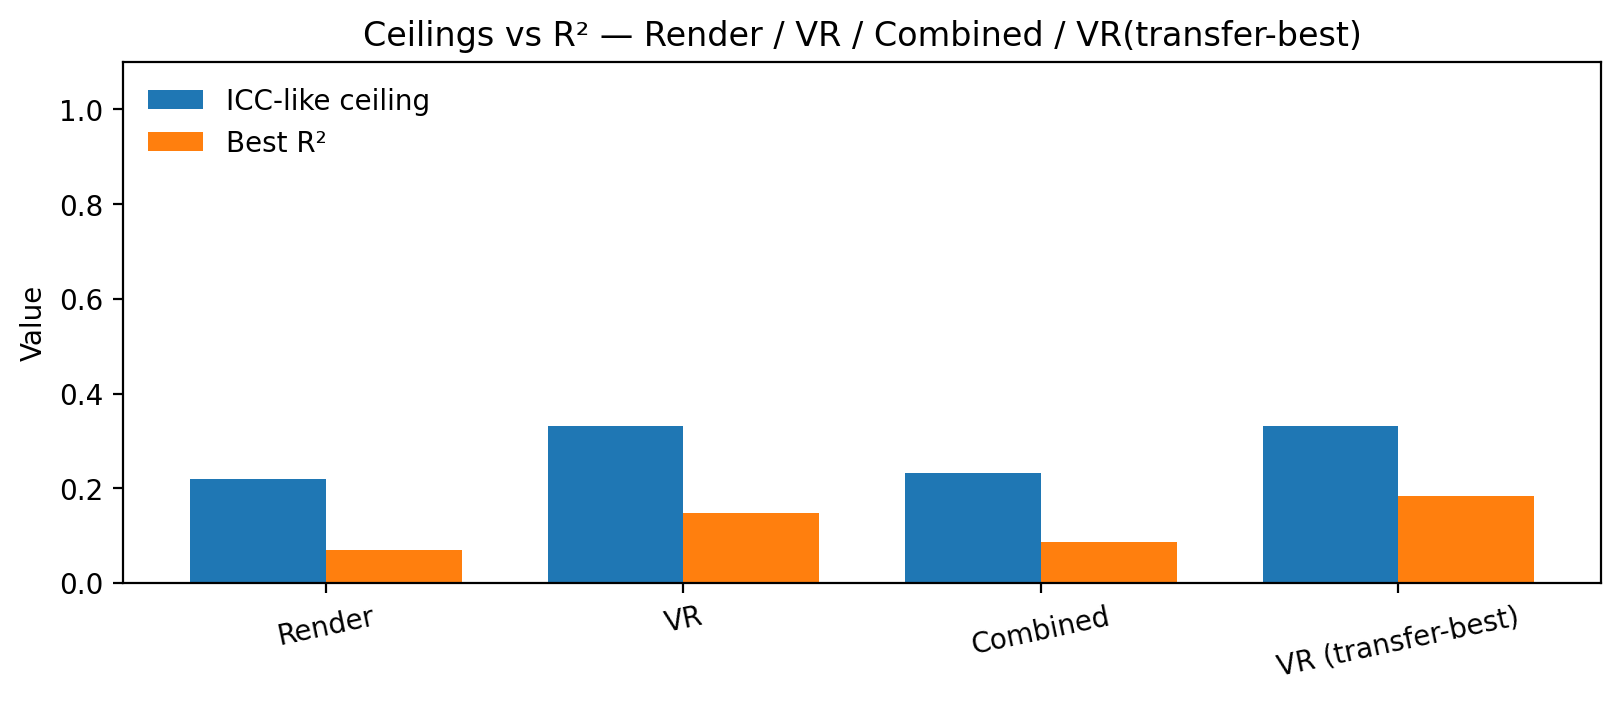

In [12]:
# =========================
# Stage 10 — R² vs ICC-like ceilings (Render-best, VR-best, Combined-best, Transfer-best)
# =========================
begin_stage(
    "R² vs ICC-like ceilings",
    "How much of the reliable variance each model captures on its domain."
)

# Best R² from earlier stages (robust to missing vars)
def _best_r2_safe(df_or_none):
    try:
        return float(np.nanmax(df_or_none["R2"].values))
    except Exception:
        return np.nan

best_r2_render = _best_r2_safe(globals().get("res_render"))
best_r2_vr     = _best_r2_safe(globals().get("res_vr"))
best_r2_comb   = _best_r2_safe(globals().get("res_comb"))
r2_transfer    = float(globals().get("BEST_TRANSFER_R2", np.nan))

def _frac(r2, icc):
    return (r2 / icc) if (icc is not None and np.isfinite(icc) and icc > 0) else np.nan

df_ceiling = pd.DataFrame({
    "Model": ["Render-best", "VR-best", "Combined-best", "VR(transfer-best)"],
    "Ceiling_domain": ["Render", "VR", "Combined", "VR"],
    "ICC_like_ceiling": [
        round(render_icc,3) if np.isfinite(render_icc) else np.nan,
        round(vr_icc,3)     if np.isfinite(vr_icc)     else np.nan,
        round(comb_icc,3)   if np.isfinite(comb_icc)   else np.nan,
        round(vr_icc,3)     if np.isfinite(vr_icc)     else np.nan
    ],
    "R2": [
        None if not np.isfinite(best_r2_render) else round(best_r2_render,3),
        None if not np.isfinite(best_r2_vr)     else round(best_r2_vr,3),
        None if not np.isfinite(best_r2_comb)   else round(best_r2_comb,3),
        None if not np.isfinite(r2_transfer)    else round(r2_transfer,3),
    ]
})

df_ceiling["ExplainedFraction_of_Ceiling"] = [
    round(_frac(best_r2_render, render_icc),3) if np.isfinite(render_icc) else np.nan,
    round(_frac(best_r2_vr,     vr_icc),3)     if np.isfinite(vr_icc)     else np.nan,
    round(_frac(best_r2_comb,   comb_icc),3)   if np.isfinite(comb_icc)   else np.nan,
    round(_frac(r2_transfer,    vr_icc),3)     if np.isfinite(vr_icc)     else np.nan
]

save_and_show_table(
    df_ceiling,
    "R² vs ICC-like ceilings (Render-best, VR-best, Combined-best, Transfer-best)",
    "tab:ceiling_vs_r2_all",
    "ceiling_vs_r2_all",
    why="R² expressed relative to reliability ceiling; useful context for performance headroom."
)

# ----- Bar chart: Ceilings vs R² -----
pairs = [
    ("Render",            render_icc, best_r2_render),
    ("VR",                vr_icc,     best_r2_vr),
    ("Combined",          comb_icc,   best_r2_comb),
    ("VR (transfer-best)",vr_icc,     r2_transfer),
]

# Prepare data (replace NaN with 0.0 for plotting, keep labels intact)
labels = [p[0] for p in pairs]
ceil_v = [0.0 if not (np.isfinite(p[1]) and p[1] >= 0) else float(p[1]) for p in pairs]
r2_v   = [0.0 if not np.isfinite(p[2]) else float(p[2]) for p in pairs]

x = np.arange(len(labels))
w = 0.38

fig = plt.figure(figsize=(8.2, 3.6), dpi=180)
plt.bar(x - w/2, ceil_v, width=w, label="ICC-like ceiling")
plt.bar(x + w/2, r2_v,   width=w, label="Best R²")
plt.xticks(x, labels, rotation=12, ha="center")
ymax = max([1.0] + ceil_v + r2_v) * 1.10
plt.ylim(0, ymax)
plt.ylabel("Value")
plt.title("Ceilings vs R² — Render / VR / Combined / VR(transfer-best)")
plt.legend(loc="upper left", frameon=False)
plt.tight_layout()

save_and_tex(
    fig,
    "ceilings_vs_r2_all",
    "ICC-like ceilings vs achieved R² for Render-best, VR-best, Combined-best, and VR(transfer-best).",
    dpi=200, bbox_inches="tight"
)
plt.close(fig)


## Stage 11 — SHAP (fast, cached) + interactions

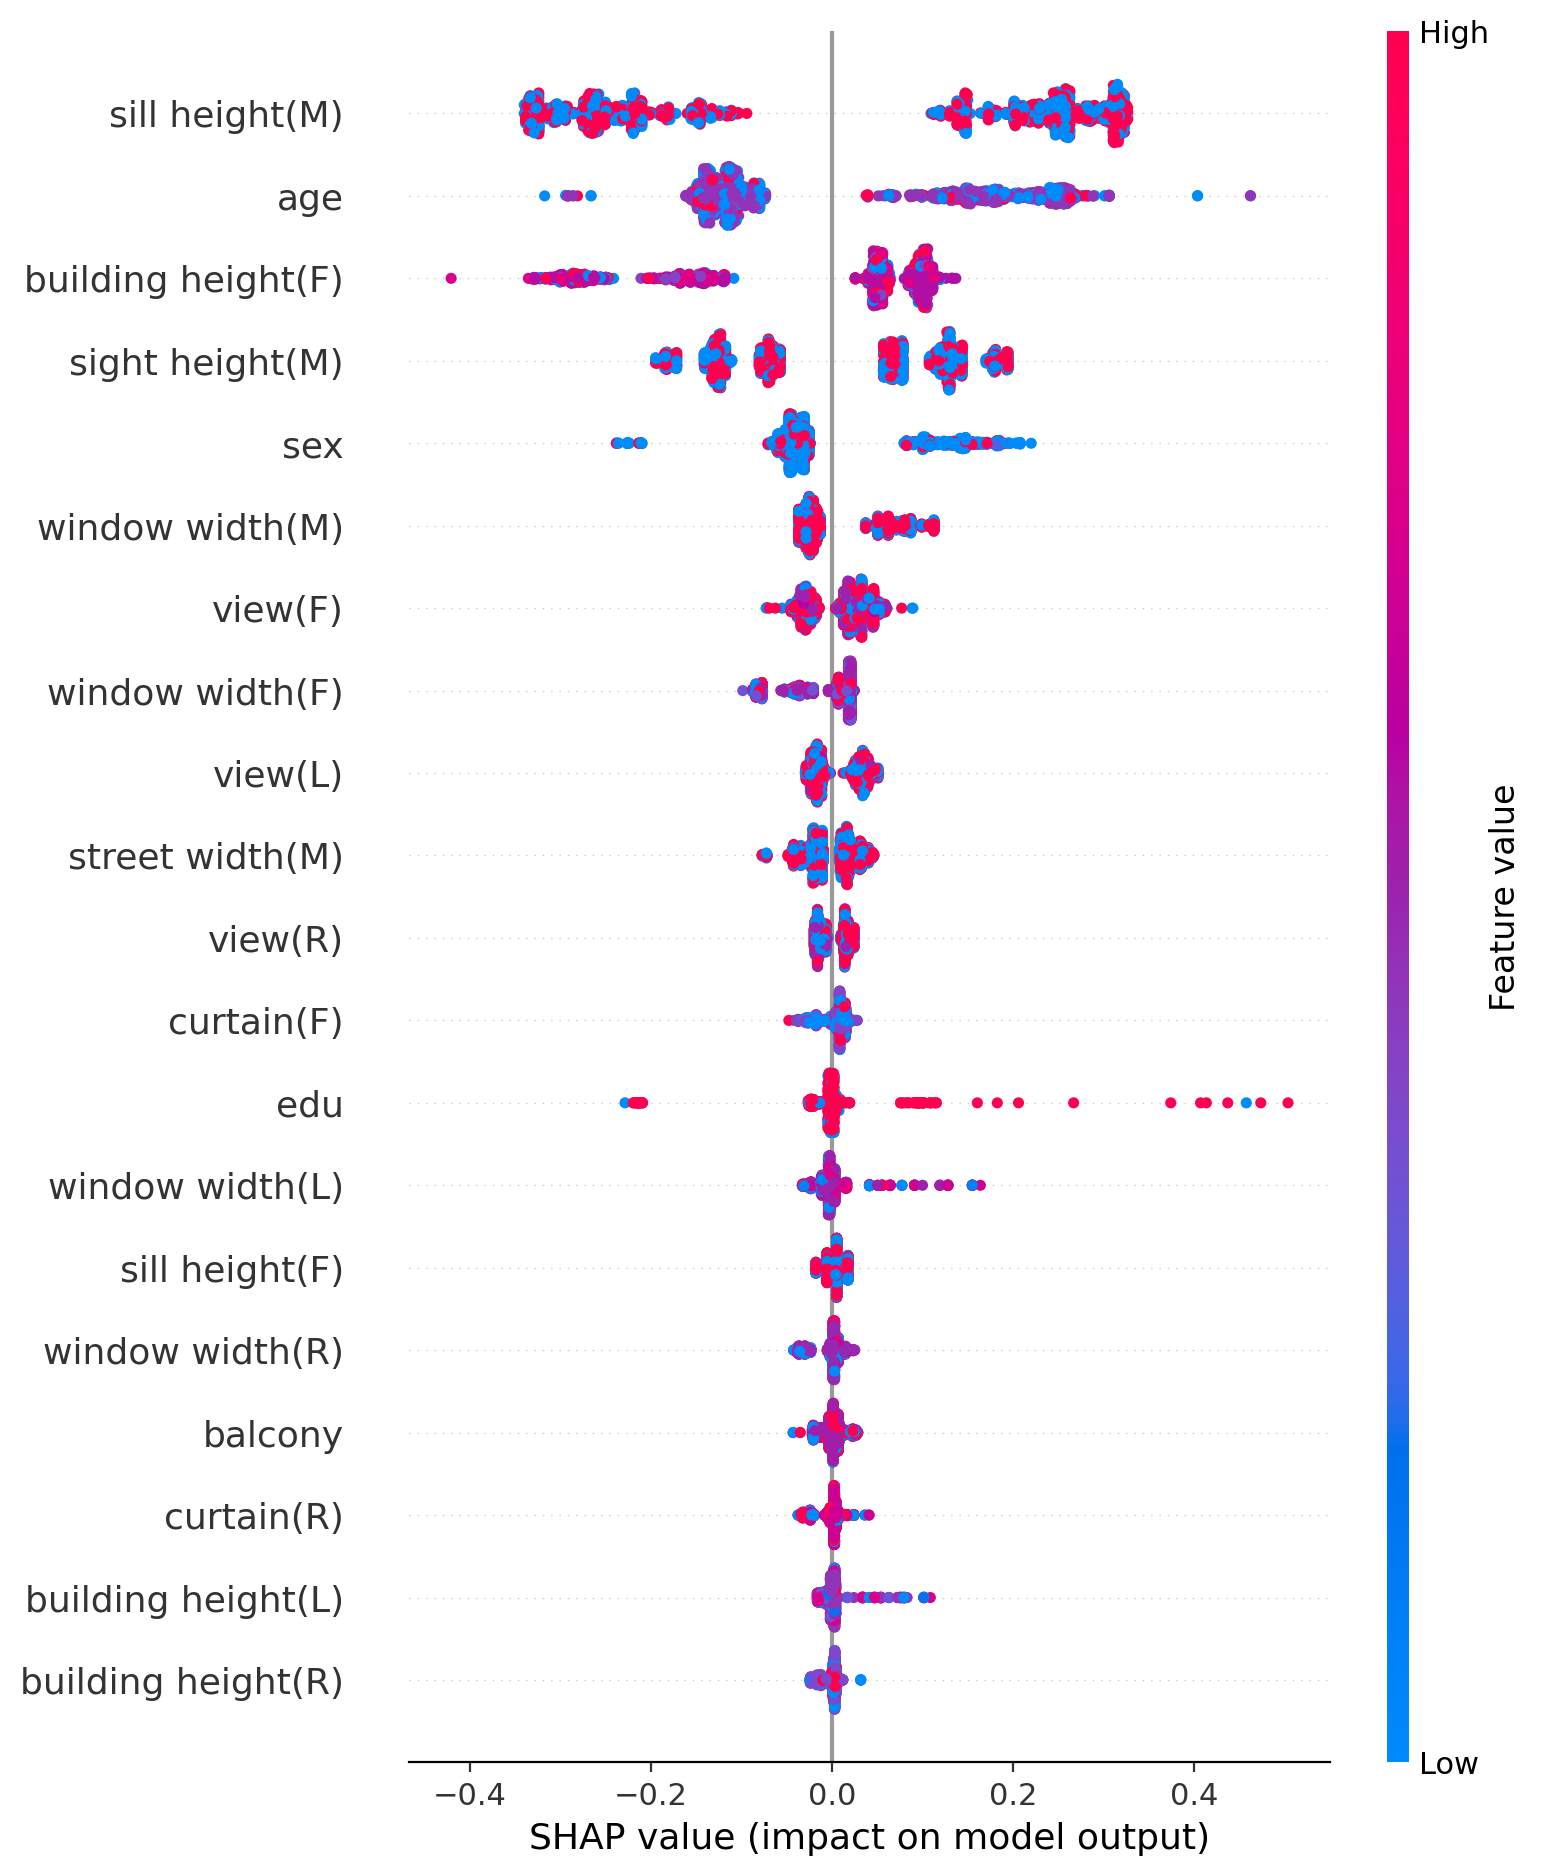

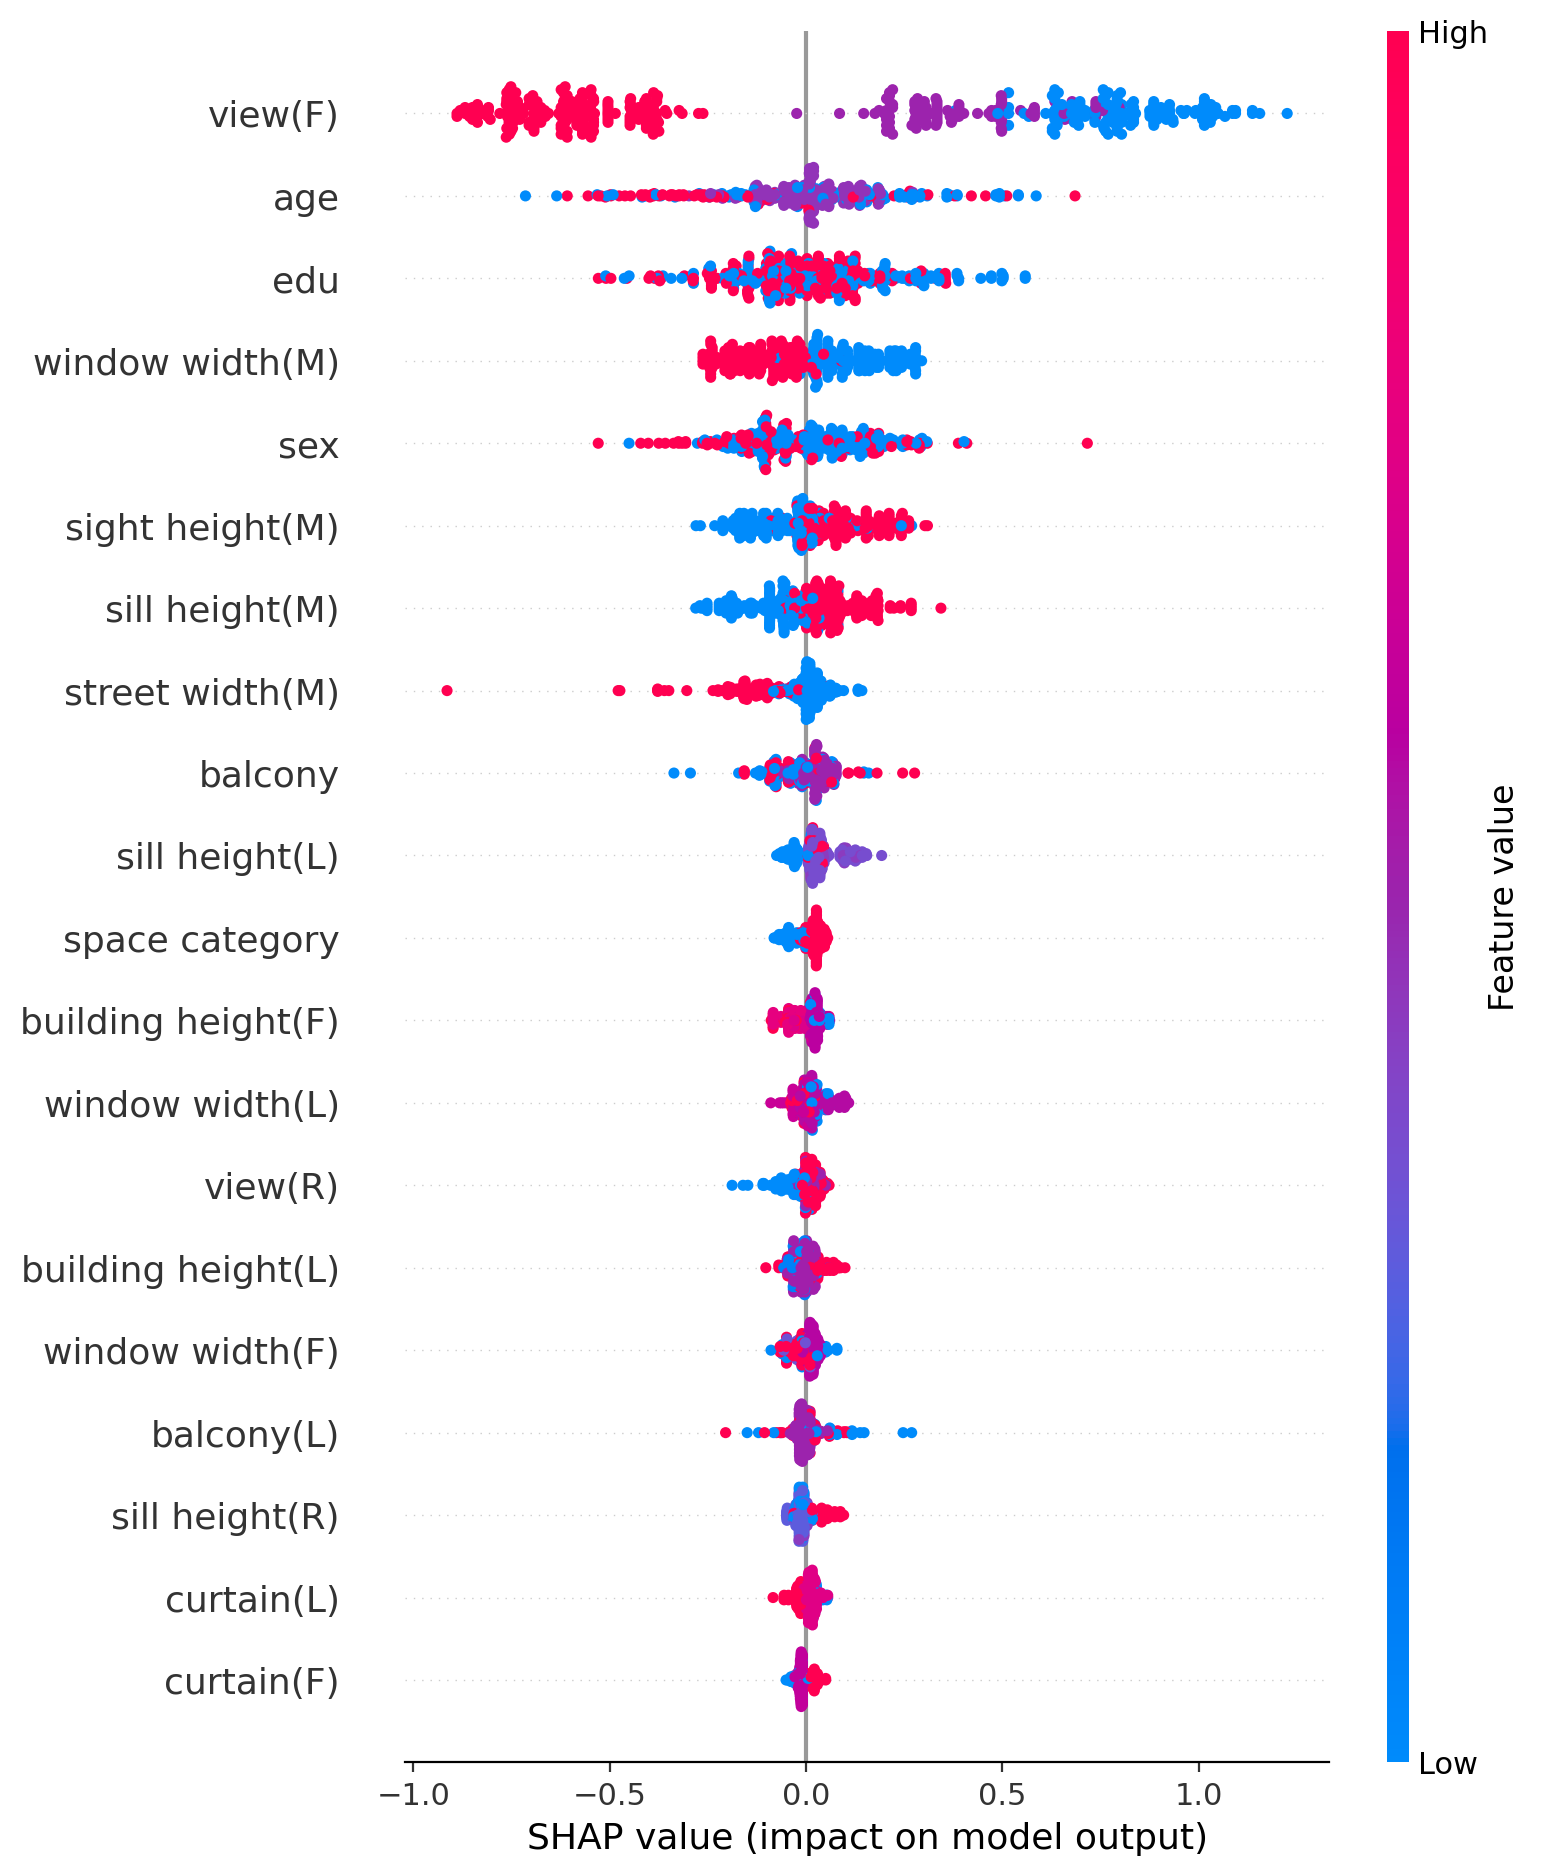

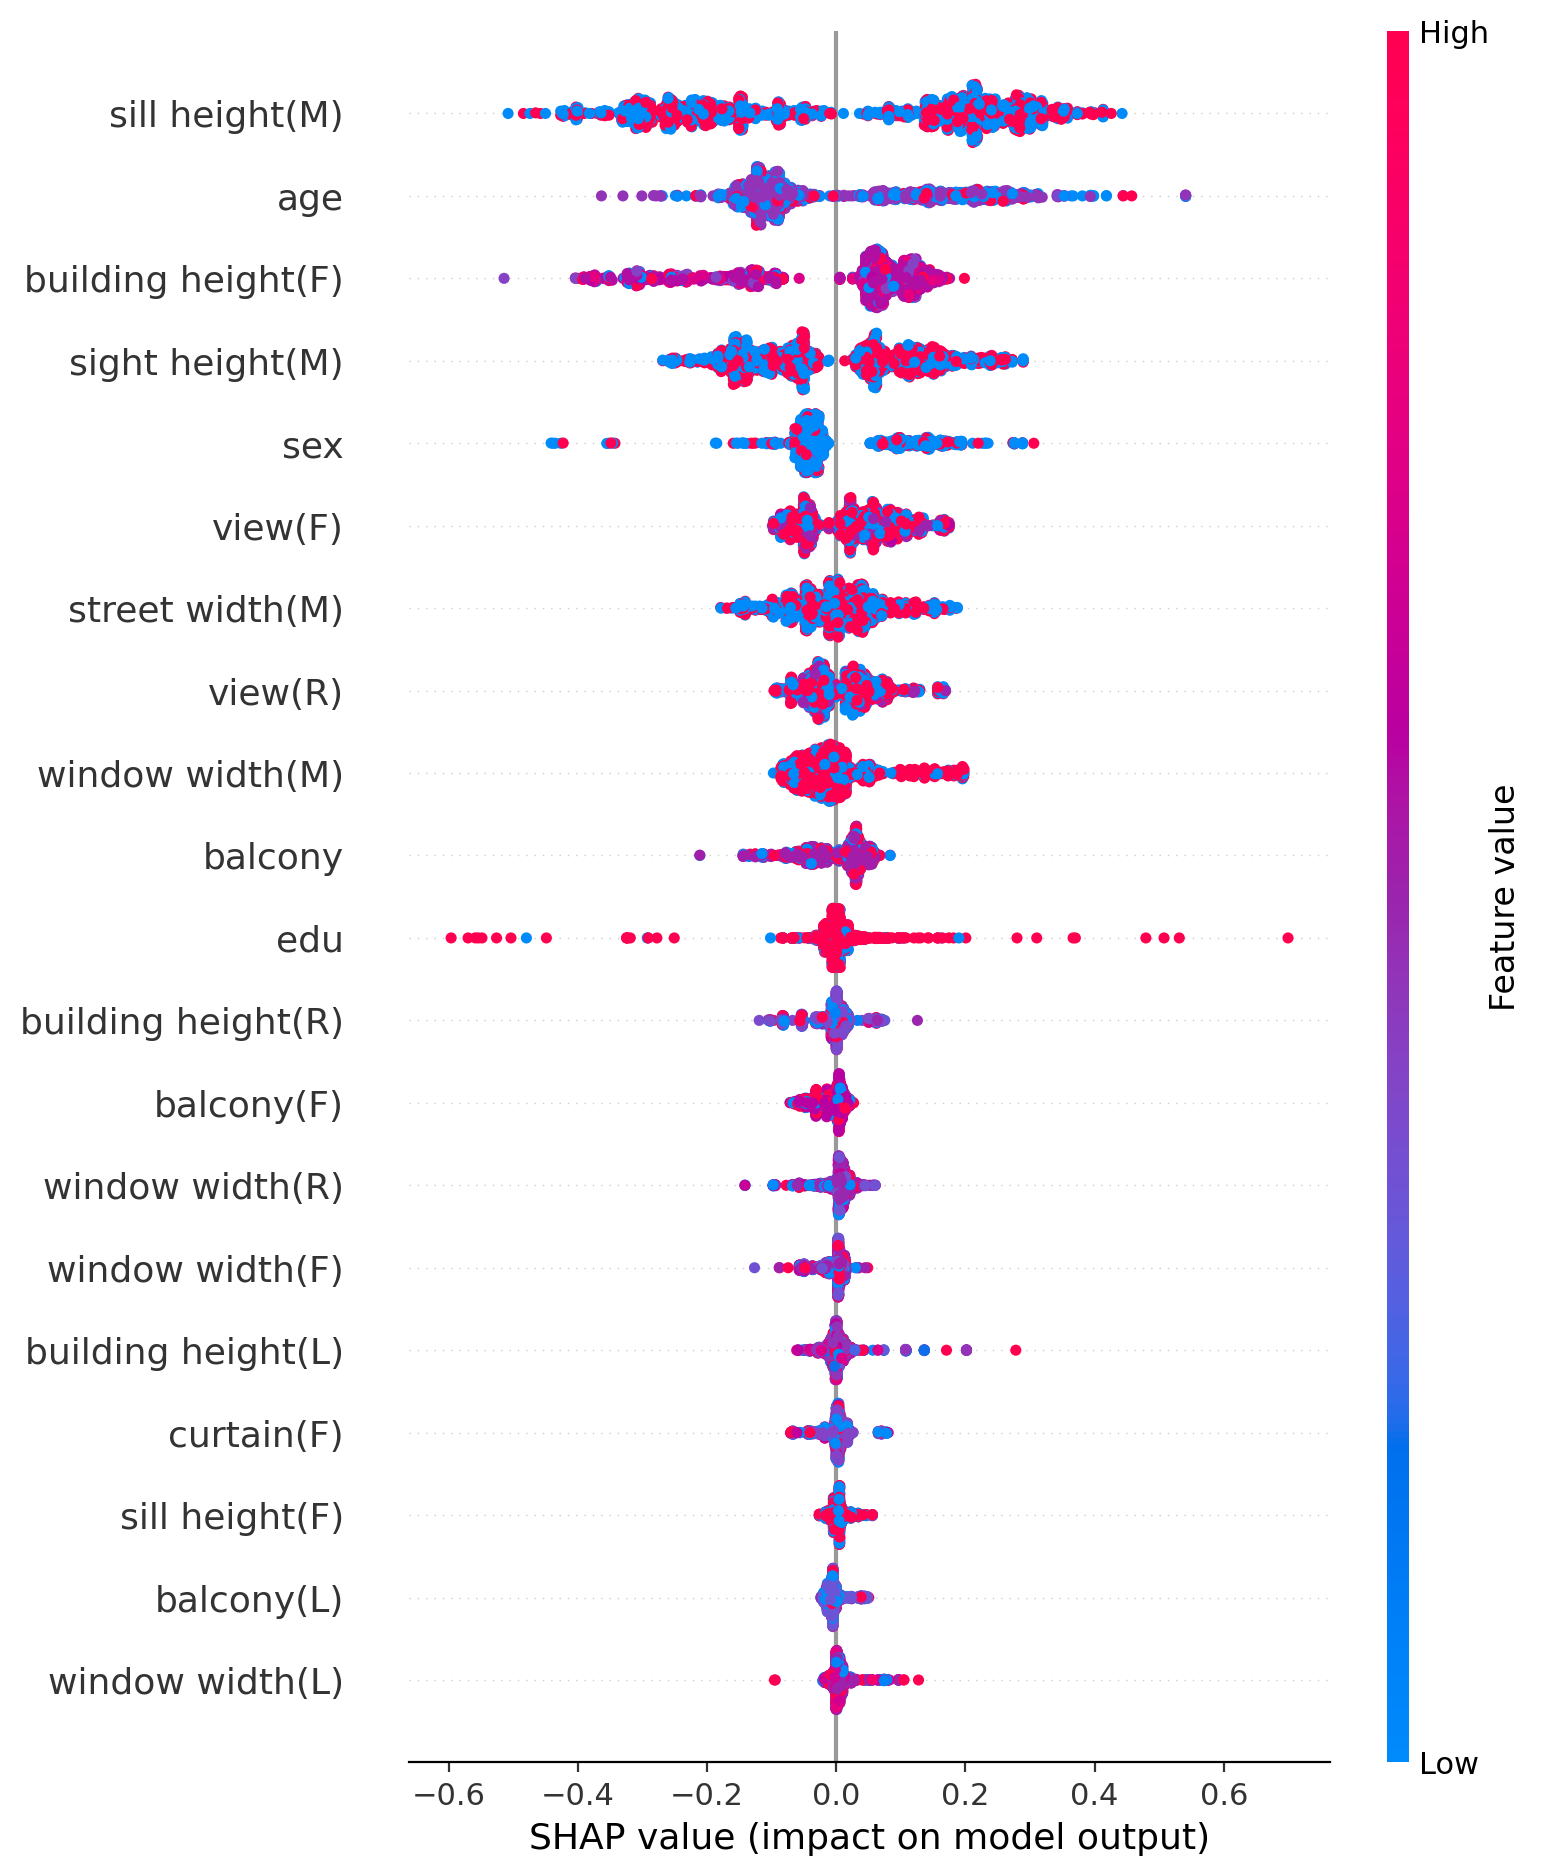

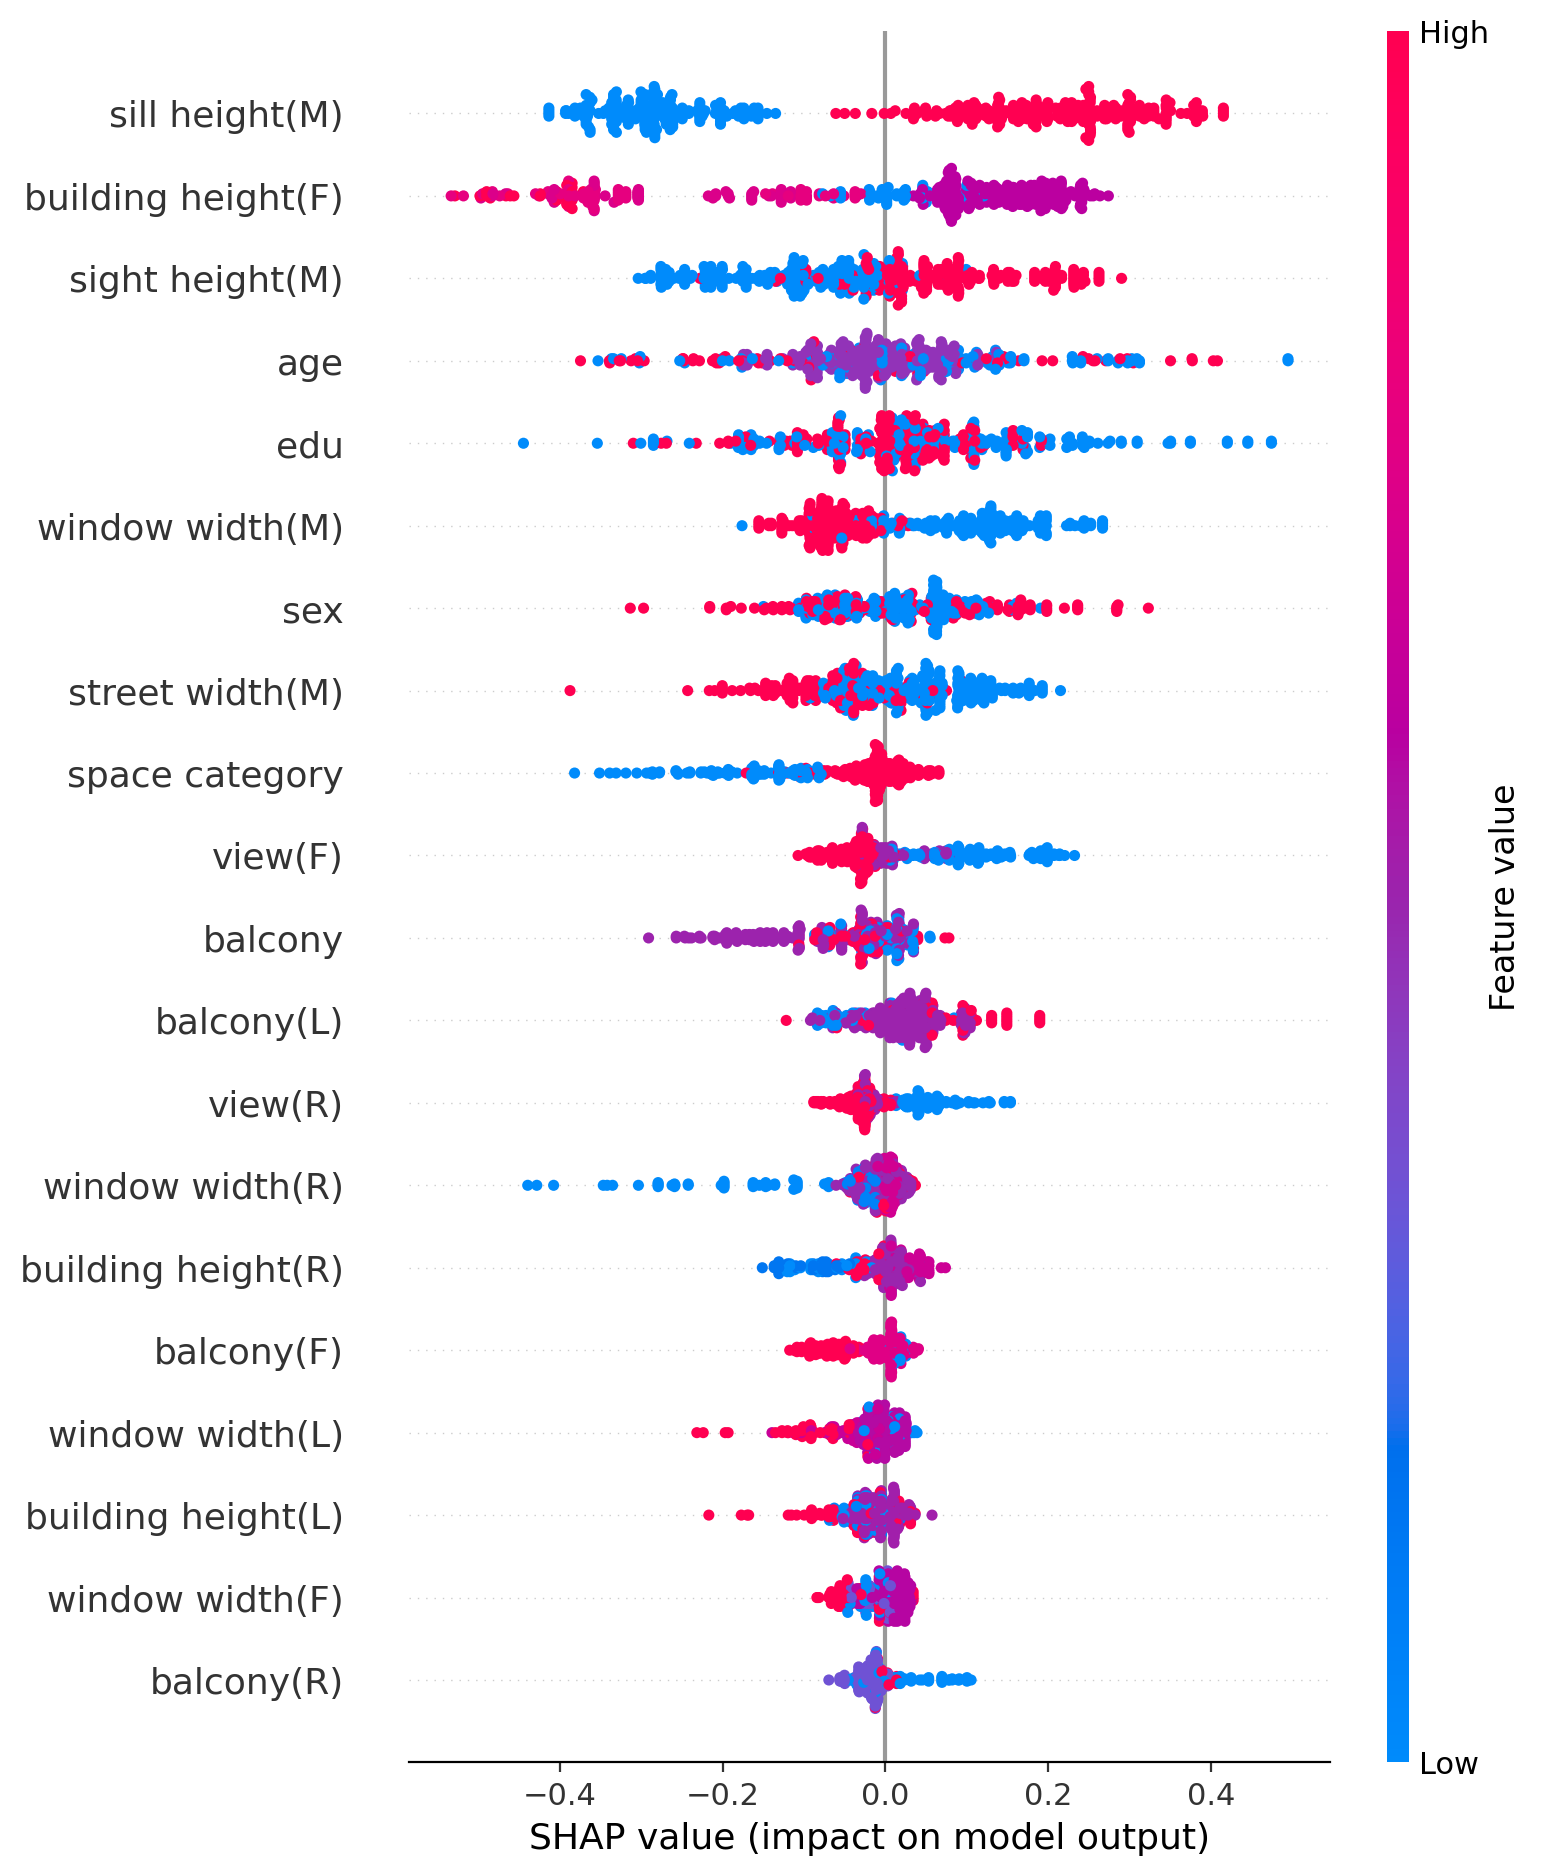

In [ ]:
# =========================
# Stage 11 — SHAP (fast, cached) + interactions
# =========================
begin_stage(
    "SHAP (fast, cached) + interactions",
    "Trees: fast contribs; Linear: closed-form; Kernel: bounded. Caches SHAP for later reuse."
)

# -------- Helpers (fast paths + cache) ---------------------------------------
def _is_tree_regressor(est):
    m = est.named_steps['regressor'] if isinstance(est, Pipeline) and 'regressor' in est.named_steps else est
    return isinstance(m, (DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor, XGBRegressor))

def _is_linear(est):
    m = est.named_steps['regressor'] if isinstance(est, Pipeline) and 'regressor' in est.named_steps else est
    return isinstance(m, (LinearRegression, HuberRegressor))

def _tree_regressor_from(est):
    return est.named_steps['regressor'] if hasattr(est, "named_steps") and 'regressor' in est.named_steps else est

EXPLAINER_CACHE = {}  # id(model) -> shap.TreeExplainer
SHAP_CACHE      = {}  # tag -> {"X": DataFrame, "sv": np.ndarray}

def shap_cache_put(key: str, X_df: pd.DataFrame, shap_vals: np.ndarray):
    SHAP_CACHE[key] = {"X": X_df.reset_index(drop=True).copy(),
                       "sv": np.asarray(shap_vals)}

def shap_cache_get(key: str):
    return SHAP_CACHE.get(key, None)

def _safe_sample_df(df: pd.DataFrame, n: int | None, seed: int = 42) -> pd.DataFrame:
    if n is None or len(df) <= n:
        return df
    return df.sample(n=n, random_state=seed).reset_index(drop=True)

def _fast_tree_shap_values(reg, X_df: pd.DataFrame, use_pred_contribs: bool = True):
    """
    Ultra-fast SHAP for trees. XGBoost: booster.pred(pred_contribs=True).
    Else: shap.TreeExplainer(..., check_additivity=False).
    Returns (n_rows x n_feats).
    """
    # XGBoost fast path
    if use_pred_contribs and hasattr(reg, "get_booster"):
        try:
            import xgboost as xgb
            dmat = xgb.DMatrix(np.asarray(X_df, dtype=np.float32))
            sv = reg.get_booster().predict(dmat, pred_contribs=True, approx_contribs=True)
            if sv.shape[1] == X_df.shape[1] + 1:  # last column is bias
                sv = sv[:, :-1]
            return sv
        except Exception as e:
            stage_note(f"[SHAP][XGB fast] fell back: {e}")

    # Generic tree path
    expl = EXPLAINER_CACHE.get(id(reg))
    if expl is None:
        expl = shap.TreeExplainer(reg, feature_perturbation="tree_path_dependent")
        EXPLAINER_CACHE[id(reg)] = expl
    sv = expl.shap_values(X_df, check_additivity=False)
    if isinstance(sv, list):
        sv = sv[0]
    return sv

def explain_with_shap_any(
    estimator, X: pd.DataFrame, tag: str,
    top_k=20,
    do_interactions=True, top_inter=15, inter_feat_cap=60,
    summary_rows=2000,              # cap for summary plot
    cache_rows=None,                # None = cache full X; or int to cap cached rows
    random_state=42
):
    """
    Computes SHAP (fast), saves: top-k importances, summary plot, and optional interactions.
    Caches SHAP for reuse by later stages (significant-only plots).
    """
    X_full = X.astype(np.float32, copy=False)

    # --- SHAP values (compute once; cache) ---
    if _is_tree_regressor(estimator):
        reg = _tree_regressor_from(estimator)
        X_cache = _safe_sample_df(X_full, cache_rows, random_state)
        sv_full = _fast_tree_shap_values(reg, X_cache, use_pred_contribs=True)
        shap_cache_put(tag, X_cache, sv_full)
        X_for_imp = X_cache
        sv_for_imp = sv_full
    elif _is_linear(estimator):
        base = _tree_regressor_from(estimator) if _is_linear(estimator) else estimator
        try:
            expl = shap.LinearExplainer(base, X_full, feature_dependence="independent")
        except TypeError:
            expl = shap.LinearExplainer(base, X_full)
        sv_full = expl.shap_values(X_full)
        shap_cache_put(tag, X_full, sv_full)
        X_for_imp = X_full
        sv_for_imp = sv_full
    else:
        # Kernel is slow → bound X for both cache and plotting; don't overcache huge arrays
        X_bound = _safe_sample_df(X_full, min(2000, len(X_full)), random_state)
        bg      = _safe_sample_df(X_bound, min(200, len(X_bound)), random_state)
        expl    = shap.KernelExplainer(lambda z: estimator.predict(pd.DataFrame(z, columns=X_bound.columns)), bg)
        sv_full = expl.shap_values(X_bound, nsamples=min(100 * X_bound.shape[1], 2000))
        shap_cache_put(tag, X_bound, sv_full)
        X_for_imp = X_bound
        sv_for_imp = sv_full

    # --- Importances table (top-k by mean|SHAP|) ---
    mean_abs = np.abs(sv_for_imp).mean(axis=0)
    imp = (pd.DataFrame({"Feature": X_for_imp.columns, "mean_abs_SHAP": mean_abs})
           .sort_values("mean_abs_SHAP", ascending=False).head(top_k))
    save_and_show_table(
        imp,
        f"Top {top_k} SHAP |values| — {tag}",
        f"tab:shap_imp_{_slug(tag)}",
        f"shap_imp_{_slug(tag)}"
    )

    # --- Summary plot (sample rows only for viz) ---
    cached = shap_cache_get(tag)
    X_sum  = cached["X"]
    sv_sum = cached["sv"]
    X_small = _safe_sample_df(X_sum, summary_rows, random_state)
    if len(X_small) != len(X_sum):
        # align SHAP rows to sampled X_small via index
        idx = X_small.index.to_numpy()
        sv_plot = sv_sum[idx, :]
    else:
        sv_plot = sv_sum

    plt.close('all')
    plt.figure(figsize=(7, 4))
    shap.summary_plot(sv_plot, X_small, show=False, plot_type="dot",
                      max_display=min(top_k, X_small.shape[1]))
    fig = plt.gcf(); plt.tight_layout()
    save_and_tex(fig, f"{_slug(tag)}_shap_summary", f"{tag}: SHAP summary (dot)",
                 dpi=200, bbox_inches="tight")
    plt.close(fig)

    # --- Interactions (trees only; bounded) ---
    if do_interactions and _is_tree_regressor(estimator):
        try:
            reg = _tree_regressor_from(estimator)
            if X_for_imp.shape[1] <= inter_feat_cap:
                expl = EXPLAINER_CACHE.get(id(reg)) or shap.TreeExplainer(reg)
                X_inter = _safe_sample_df(X_for_imp, min(2000, len(X_for_imp)), random_state)
                inter = expl.shap_interaction_values(X_inter)
                if isinstance(inter, list): inter = inter[0]
                M = np.abs(inter).mean(axis=0)
                pairs=[]; p = M.shape[0]
                for i in range(p):
                    for j in range(i+1, p):
                        pairs.append((X_for_imp.columns[i], X_for_imp.columns[j], float(M[i,j])))
                dfp = (pd.DataFrame(pairs, columns=["Feature_A","Feature_B","mean_abs_inter"])
                         .sort_values("mean_abs_inter", ascending=False).head(top_inter))
                save_and_show_table(
                    dfp,
                    f"Top {top_inter} SHAP interactions — {tag}",
                    f"tab:shap_inter_{_slug(tag)}",
                    f"shap_inter_{_slug(tag)}"
                )
        except Exception as e:
            stage_note(f"[SHAP][WARN] Interactions failed for {tag}: {e}")

    return list(imp["Feature"])

# ---- Design matrices (as before) ----
X_render_all = pd.concat([train_render, test_render], ignore_index=True).drop(columns=[TARGET])
X_vr_all     = pd.concat([train_vr,     test_vr    ], ignore_index=True).drop(columns=[TARGET])
X_comb_all   = pd.concat([train_combined, test_combined], ignore_index=True).drop(columns=[TARGET])

# ---- Run (cache full for trees; bounded for kernel) ----
top_r = explain_with_shap_any(est_r_best, X_render_all, tag="Render_best",   top_k=20, cache_rows=None)
top_v = explain_with_shap_any(est_v_best, X_vr_all,     tag="VR_best",       top_k=20, cache_rows=None)
top_c = explain_with_shap_any(est_c_best, X_comb_all,   tag="Combined_best", top_k=20, cache_rows=None)

# Transfer-best on VR (handle TeacherFeature)
X_vr_for_transfer = X_vr_all.copy()
if "TeacherFeature" in str(globals().get("BEST_TRANSFER_TAG", "")):
    X_r, y_r = train_render.drop(columns=[TARGET]), train_render[TARGET]
    _teacher = XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        subsample=0.9, colsample_bytree=0.8, random_state=42,
        tree_method="hist", eval_metric="rmse", n_jobs=-1
    ).fit(X_r, y_r)
    X_vr_for_transfer["teacher_pred"] = _teacher.predict(X_vr_for_transfer)

transfer_slug = _slug(BEST_TRANSFER_TAG.replace("transfer:", "")) if "BEST_TRANSFER_TAG" in globals() else "transfer"
top_t = explain_with_shap_any(BEST_TRANSFER_MODEL, X_vr_for_transfer,
                              tag=f"VR_{transfer_slug}", top_k=20, cache_rows=None)



## Stage 12 — SHAP label-permutation significance (tree models, fast)

In [14]:

# =========================
# Stage 12 — SHAP label-permutation significance (tree models, fast)
# =========================
begin_stage(
    "SHAP label-permutation significance",
    "Refit per permutation, compute mean|SHAP|; BH–FDR across features."
)

from sklearn.base import clone

# Tunables
_SHAP_SIG_B         = 100
_SHAP_SIG_TOP_M     = 30
_SHAP_SIG_ROW_CAP   = 5000
_SHAP_SIG_SEED      = 42

def _mean_abs_shap_for(estimator, X):
    """Fast mean|SHAP| for trees."""
    reg = _tree_regressor_from(estimator)
    sv  = _fast_tree_shap_values(reg, X, use_pred_contribs=True)
    return np.abs(sv).mean(axis=0)

def shap_permutation_significance(
    estimator, train_df, test_df, *,
    target=TARGET, tag="DATA",
    B=_SHAP_SIG_B, top_M=_SHAP_SIG_TOP_M,
    row_cap=_SHAP_SIG_ROW_CAP, rng_seed=_SHAP_SIG_SEED
):
    rng = np.random.default_rng(rng_seed)

    # Build matrices
    Xtr = train_df.drop(columns=[target]).astype(np.float32, copy=False)
    ytr = train_df[target].to_numpy()
    Xte = test_df.drop(columns=[target]).astype(np.float32, copy=False)
    X_all = pd.concat([Xtr, Xte], axis=0, ignore_index=True)

    # Optional cap for SHAP computations
    if (row_cap is not None) and (len(X_all) > row_cap):
        X_all = X_all.sample(n=row_cap, random_state=rng_seed).reset_index(drop=True)

    # Observed fit + SHAP
    obs_est = clone(estimator).fit(Xtr, ytr)
    mean_abs_obs = _mean_abs_shap_for(obs_est, X_all)
    features = X_all.columns.to_list()

    # Select top-M by observed importance
    order = np.argsort(mean_abs_obs)[::-1]
    top_idx = order[:min(top_M, len(order))]
    top_feats = [features[i] for i in top_idx]
    obs_vals_top = mean_abs_obs[top_idx]

    # Null distribution
    null_vals = np.zeros((len(top_feats), B), dtype=float)
    for b in range(B):
        y_perm = rng.permutation(ytr)
        est_b = clone(estimator).fit(Xtr, y_perm)
        mean_abs_b = _mean_abs_shap_for(est_b, X_all)
        null_vals[:, b] = mean_abs_b[top_idx]
        if (b+1) % max(1, B//5) == 0:
            stage_note(f"[SHAP-PERM] {tag}: {b+1}/{B} permutations…")

    # One-sided p; BH–FDR q
    p_vals = (1.0 + (null_vals >= obs_vals_top.reshape(-1,1)).sum(axis=1)) / (1.0 + B)
    q_vals = _bh_fdr(p_vals)

    out = (pd.DataFrame({
            "Feature": top_feats,
            "SHAP_mean_abs_obs": obs_vals_top,
            "p_value": p_vals,
            "q_value": q_vals
        })
        .sort_values("q_value", ascending=True)
        .reset_index(drop=True)
        .assign(SHAP_mean_abs_obs=lambda d: d.SHAP_mean_abs_obs.round(6),
                p_value=lambda d: d.p_value.round(4),
                q_value=lambda d: d.q_value.round(4))
    )

    save_and_show_table(
        out,
        f"SHAP permutation significance (B={B}, top-M={len(top_feats)}) — {tag}",
        f"tab:shap_pvals_{_slug(tag)}",
        f"shap_pvals_{_slug(tag)}",
        why="Label-permutation null with model refit per permutation; BH–FDR controls multiplicity."
    )
    return out

# -------- Run significance for tree best-estimators --------
df_sig_render   = shap_permutation_significance(est_r_best, train_render,   test_render,   tag="Render_best") \
                  if _is_tree_regressor(est_r_best) else None
df_sig_vr       = shap_permutation_significance(est_v_best, train_vr,       test_vr,       tag="VR_best") \
                  if _is_tree_regressor(est_v_best) else None
df_sig_combined = shap_permutation_significance(est_c_best, train_combined, test_combined, tag="Combined_best") \
                  if _is_tree_regressor(est_c_best) else None

# Transfer-best (augment if TeacherFeature)
tag_transfer = f"VR_{_slug(BEST_TRANSFER_TAG.replace('transfer:',''))}"
if _is_tree_regressor(BEST_TRANSFER_MODEL):
    if "TeacherFeature" in str(BEST_TRANSFER_TAG):
        X_r, y_r = train_render.drop(columns=[TARGET]), train_render[TARGET]
        _teacher = XGBRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=5,
            subsample=0.9, colsample_bytree=0.8, random_state=42,
            tree_method="hist", eval_metric="rmse", n_jobs=-1
        ).fit(X_r, y_r)
        train_aug = train_vr.copy();   test_aug = test_vr.copy()
        train_aug["teacher_pred"] = _teacher.predict(train_aug.drop(columns=[TARGET]))
        test_aug["teacher_pred"]  = _teacher.predict(test_aug.drop(columns=[TARGET]))
        df_sig_transfer = shap_permutation_significance(BEST_TRANSFER_MODEL, train_aug, test_aug, tag=tag_transfer)
    else:
        df_sig_transfer = shap_permutation_significance(BEST_TRANSFER_MODEL, train_vr, test_vr, tag=tag_transfer)
else:
    df_sig_transfer = None
    stage_note("Transfer-best is not a tree model — skipping SHAP permutation significance.")



## Stage 13 — SHAP rank stability (trees; fast)

In [15]:

# =========================
# Stage 13 — SHAP rank stability (trees; fast)
# =========================
begin_stage(
    "SHAP rank stability (trees)",
    "Bootstrap feature-rank stability; mean and std of SHAP-based ranks."
)

def shap_rank_stability(estimator, X: pd.DataFrame, B=100, tag="DATA", seed=42, row_cap=None, top_k=30):
    if row_cap is not None and len(X) > row_cap:
        X = X.sample(n=row_cap, random_state=seed).reset_index(drop=True)

    reg = _tree_regressor_from(estimator)
    # One full SHAP pass (fast) & cache if not present
    sv0 = _fast_tree_shap_values(reg, X, use_pred_contribs=True)
    if shap_cache_get(tag) is None:
        shap_cache_put(tag, X, sv0)

    rng = np.random.default_rng(seed)
    ranks = []
    for b in range(int(B)):
        idx = rng.integers(0, len(X), size=len(X))
        v   = _fast_tree_shap_values(reg, X.iloc[idx], use_pred_contribs=True)
        ma  = np.abs(v).mean(axis=0)
        ranks.append(pd.Series(ma, index=X.columns).rank(ascending=False, method="average"))
        if (b+1) % max(1, B//5) == 0:
            stage_note(f"[SHAP-RANK] {tag}: {b+1}/{B} bootstraps…")

    R = pd.concat(ranks, axis=1)
    out = (pd.DataFrame({"Feature": X.columns,
                         "RankMean": R.mean(axis=1).values,
                         "RankStd":  R.std(axis=1, ddof=1).values})
           .sort_values("RankMean", ascending=True).reset_index(drop=True))

    save_and_show_table(
        out.head(top_k).assign(RankMean=lambda d: d.RankMean.round(2),
                               RankStd=lambda d: d.RankStd.round(2)),
        f"SHAP rank stability (bootstrap B={B}) — {tag}",
        f"tab:shap_rank_{_slug(tag)}",
        f"shap_rank_{_slug(tag)}",
        why="Lower RankMean = higher average importance; RankStd quantifies stability."
    )
    return out

# Run stability (reuse X_* and transfer augmentation above)
if _is_tree_regressor(est_r_best): _ = shap_rank_stability(est_r_best, X_render_all, B=100, tag="Render_best")
if _is_tree_regressor(est_v_best): _ = shap_rank_stability(est_v_best, X_vr_all,     B=100, tag="VR_best")
if _is_tree_regressor(est_c_best): _ = shap_rank_stability(est_c_best, X_comb_all,   B=100, tag="Combined_best")
if _is_tree_regressor(BEST_TRANSFER_MODEL):
    X_vr_rs = X_vr_for_transfer  # already augmented if TeacherFeature
    _ = shap_rank_stability(BEST_TRANSFER_MODEL, X_vr_rs, B=100, tag=tag_transfer)
else:
    stage_note("Transfer-best is not a tree model — skipping SHAP rank stability.")



## Stage 14 — SHAP significant-only summary (no recompute; paper-ready)

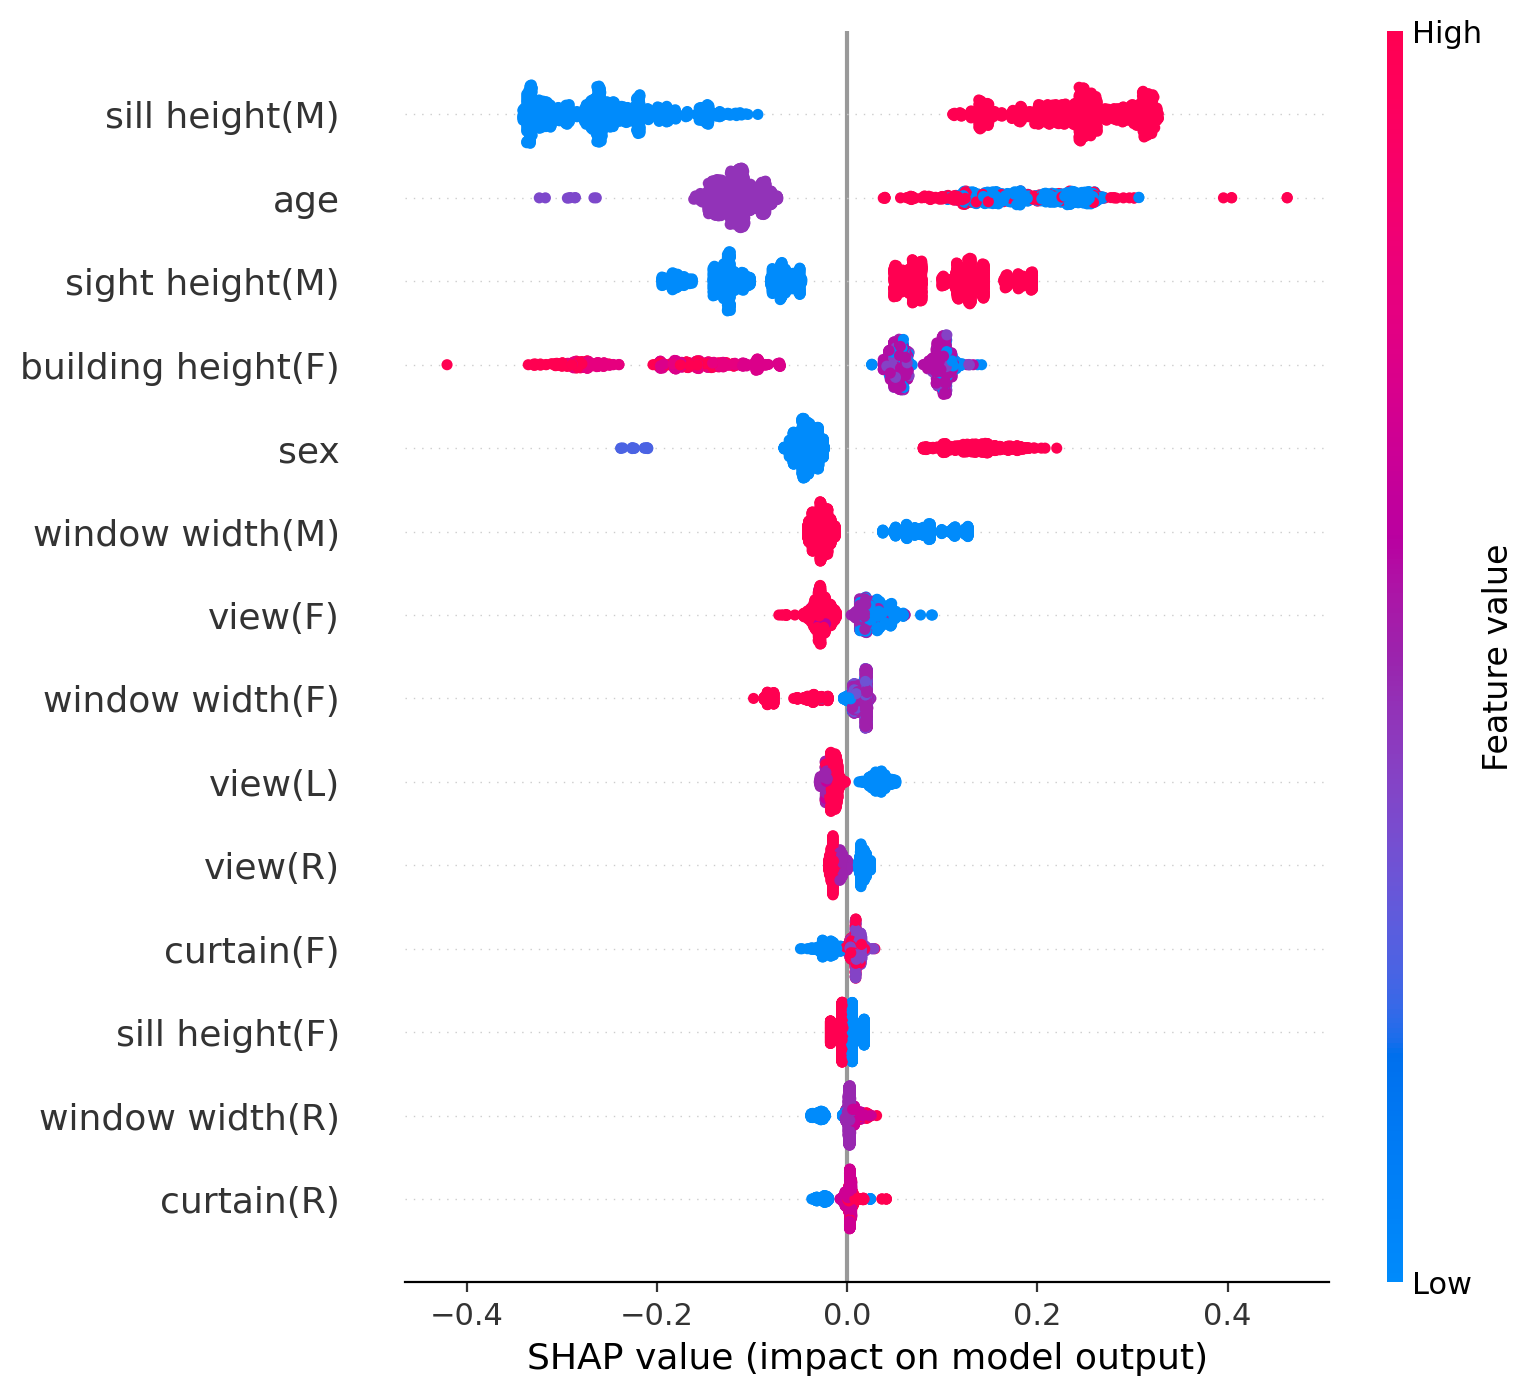

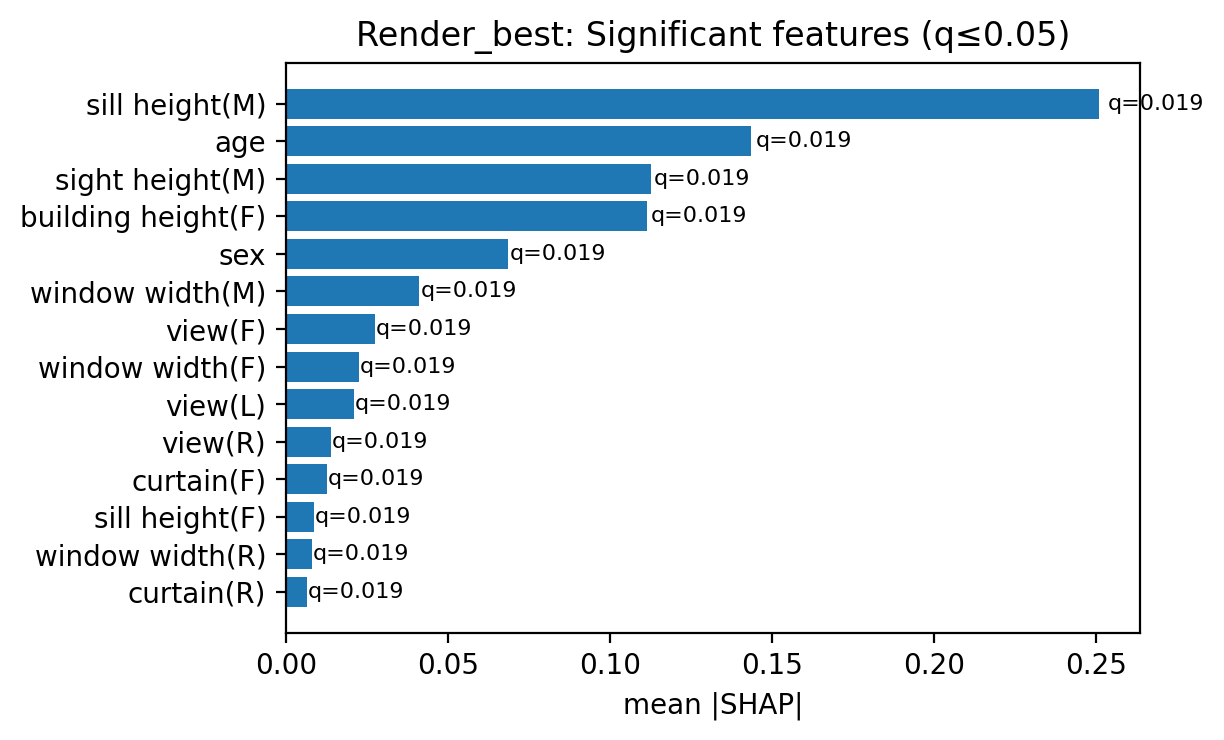

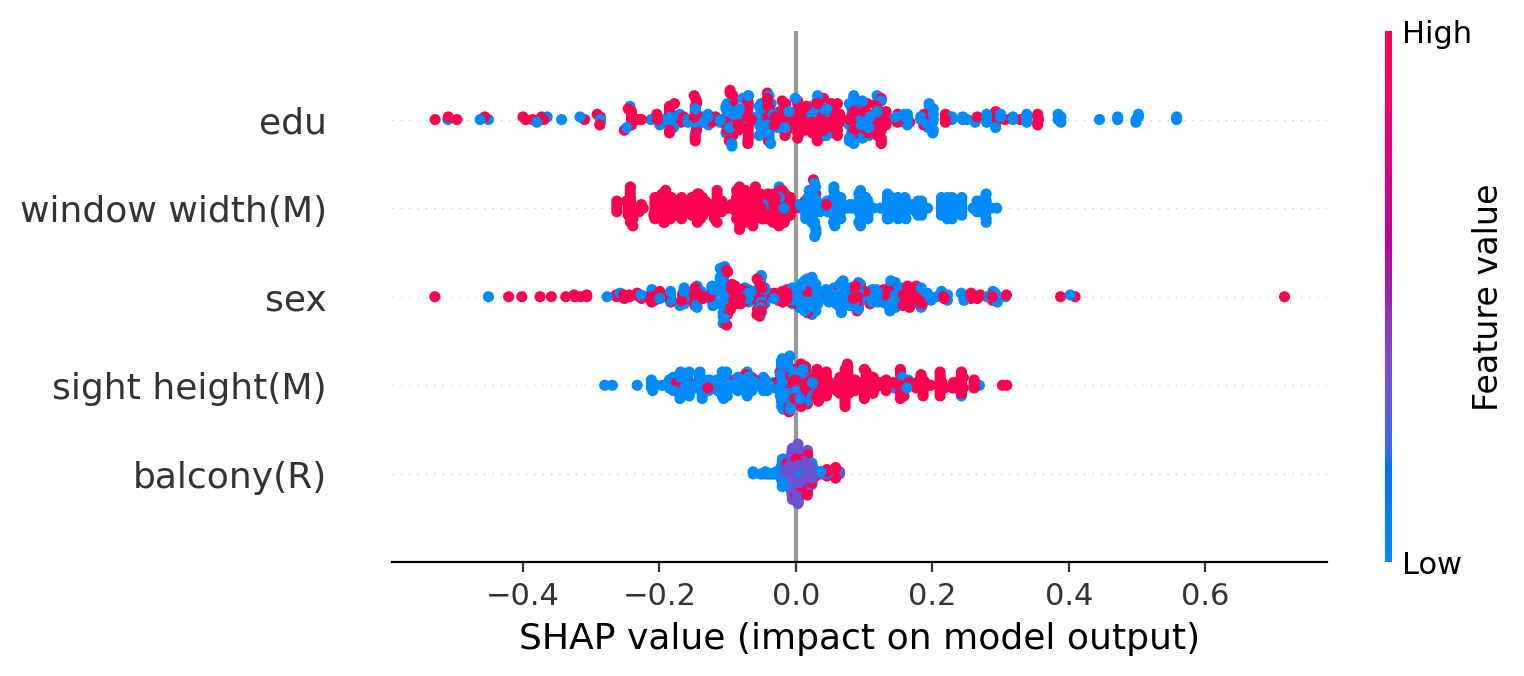

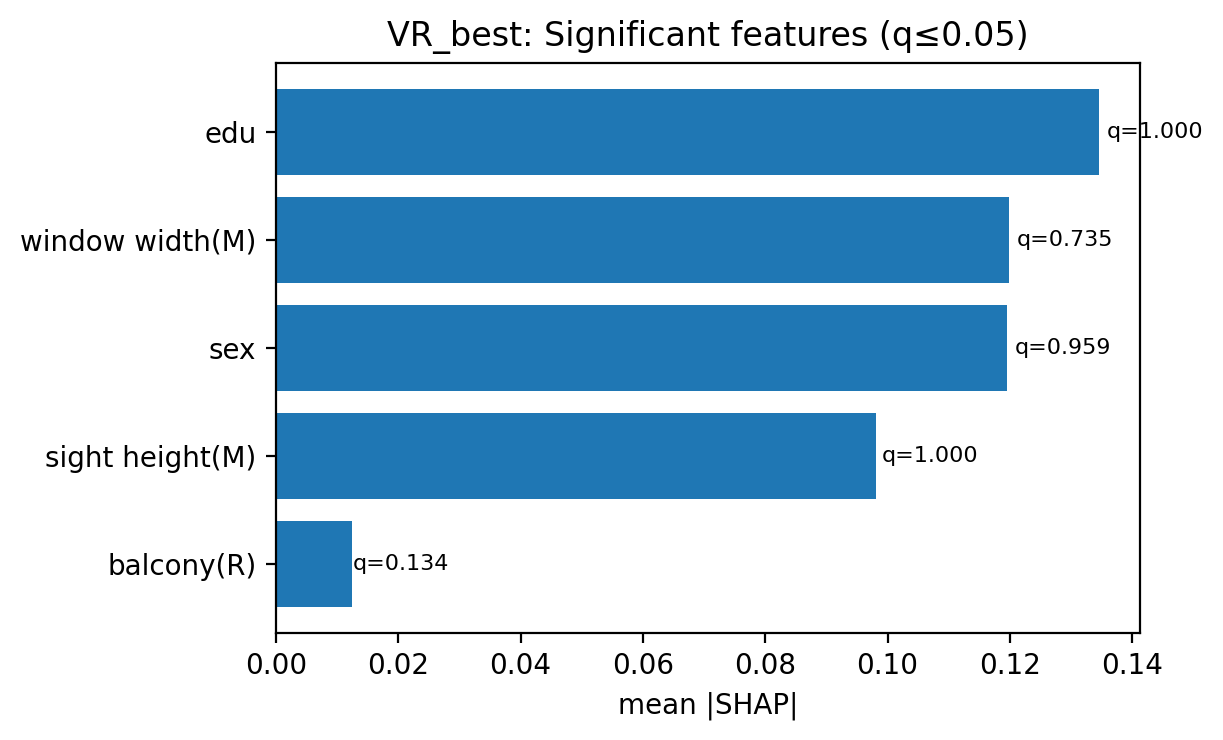

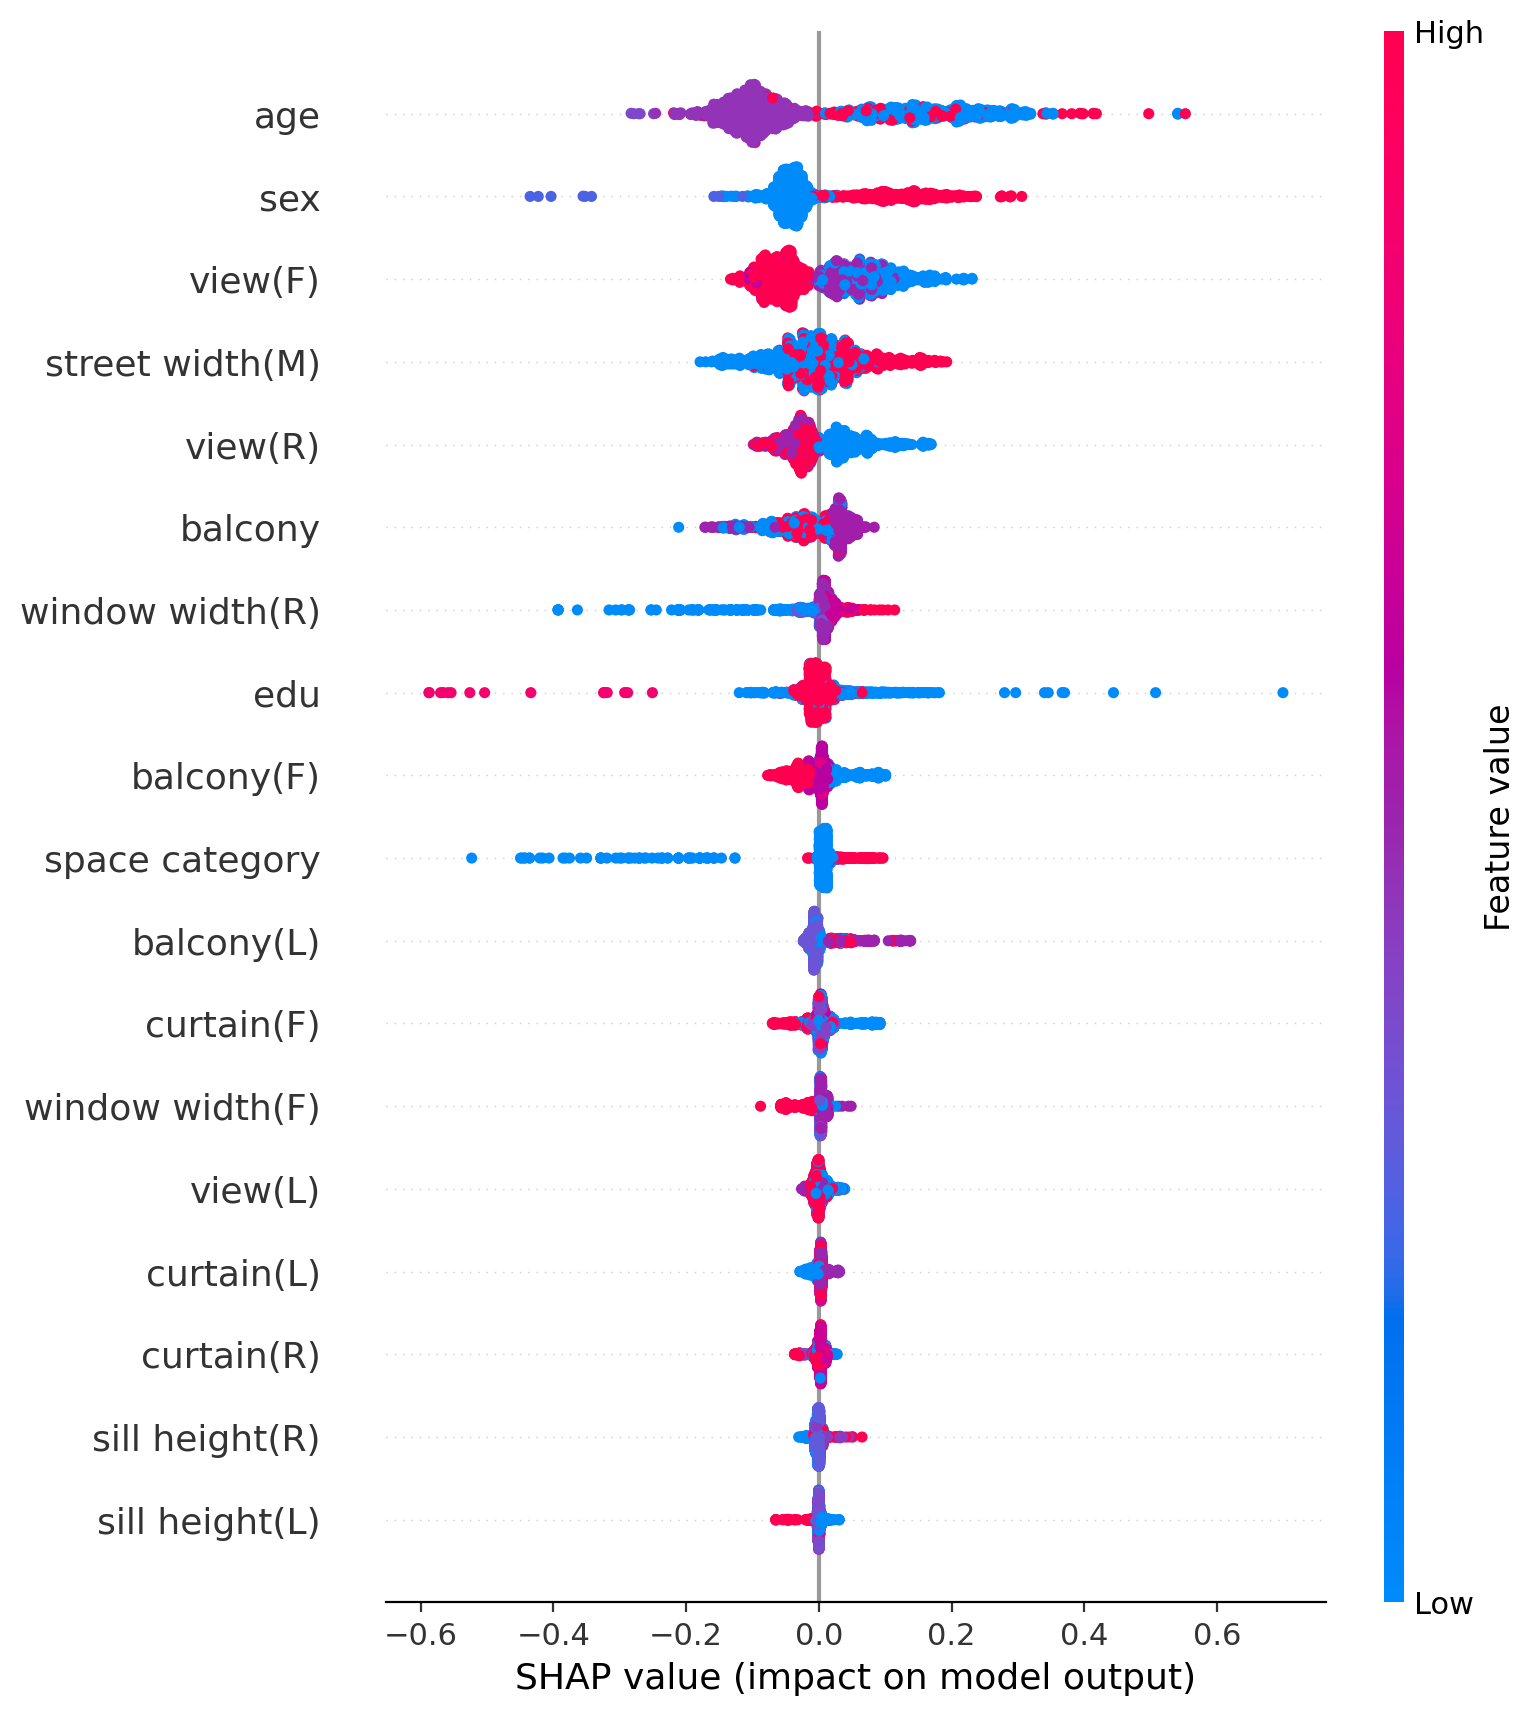

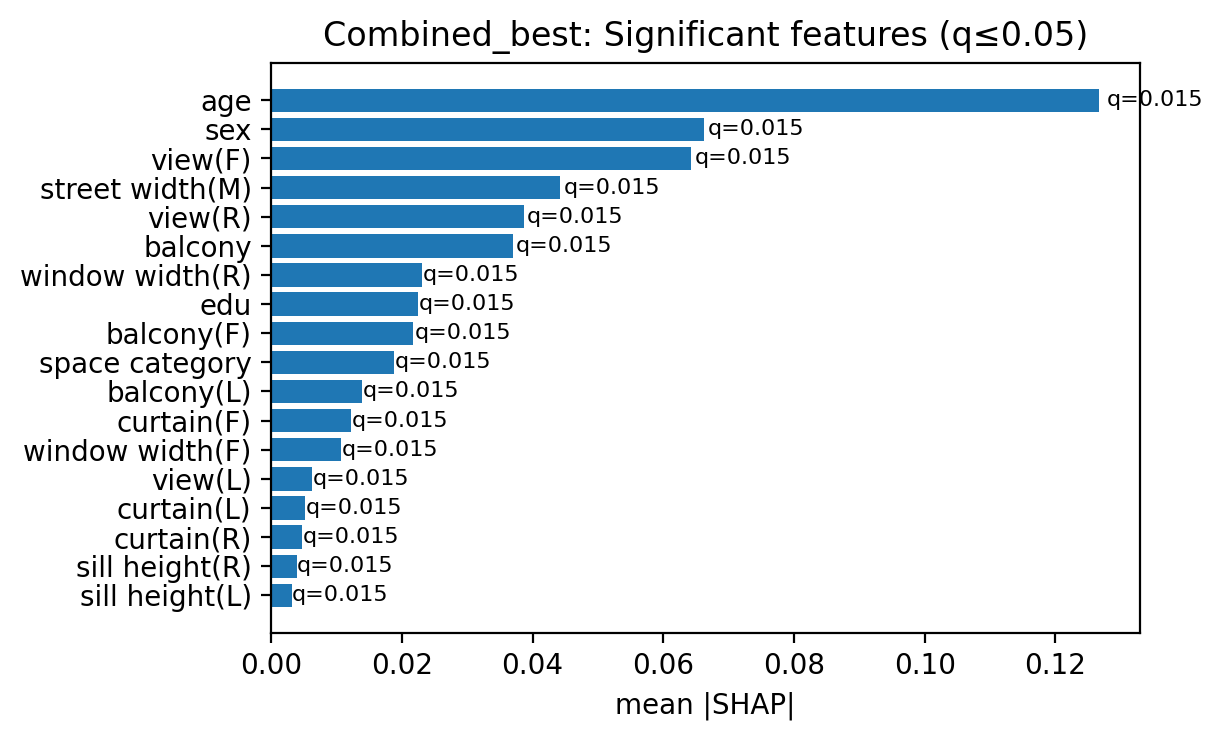

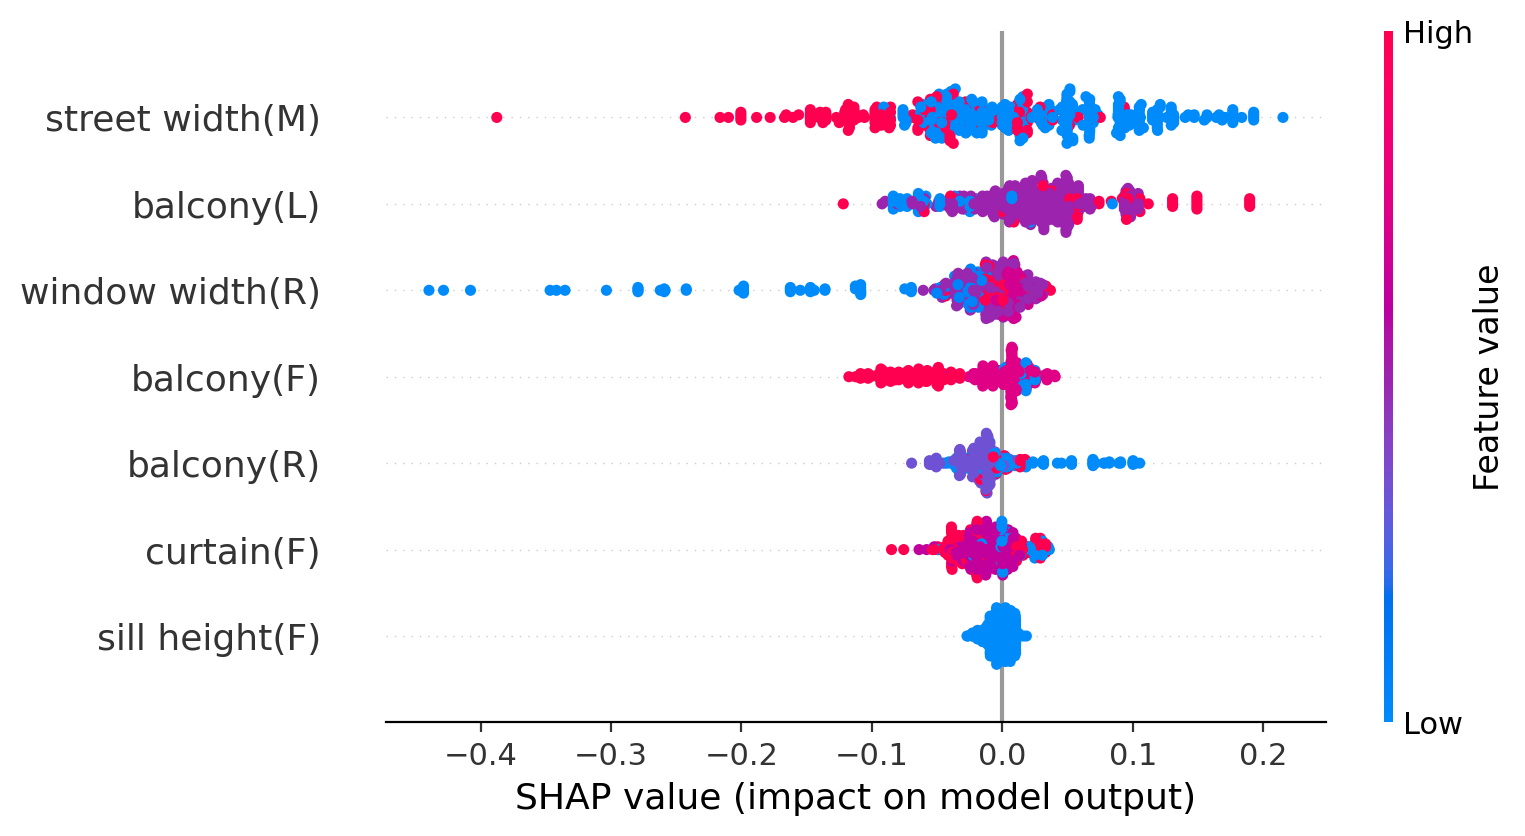

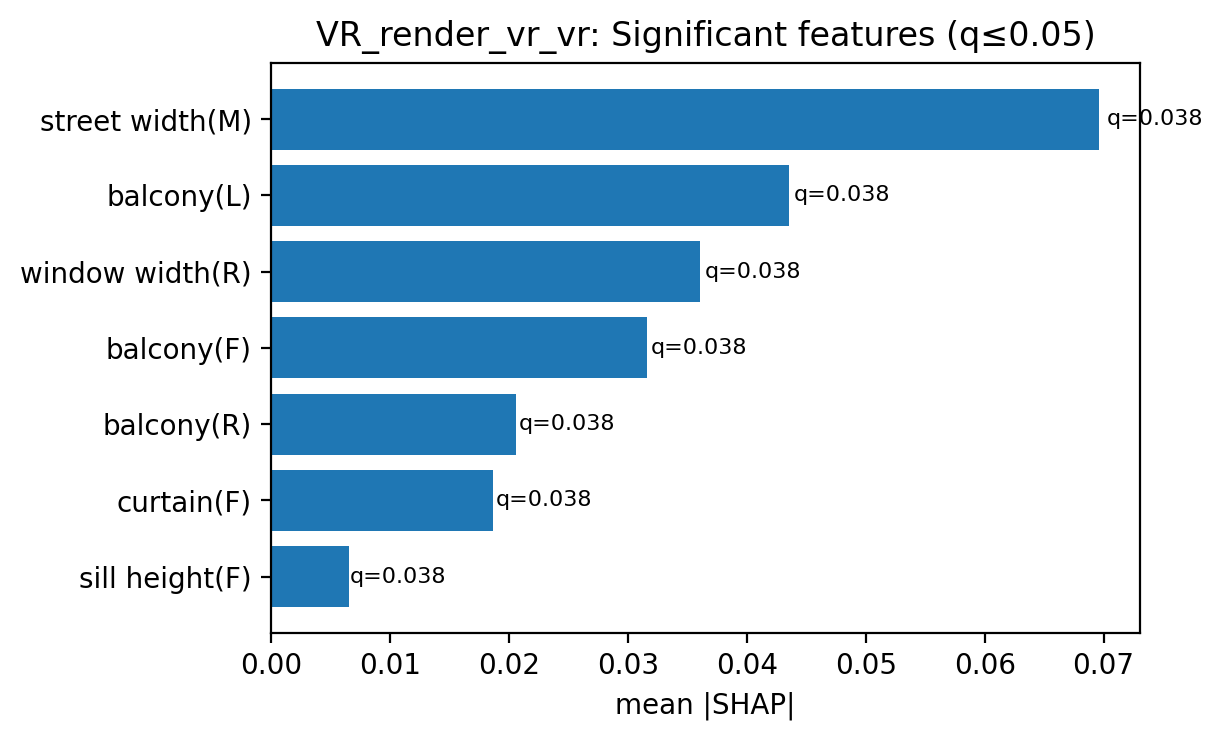

In [16]:

# =========================
# Stage 14 — SHAP significant-only summary (no recompute; paper-ready)
# =========================
begin_stage(
    "SHAP significant-only summary",
    "Use BH–FDR significant features to produce compact tables & plots; reuses cached SHAP."
)

def shap_summary_significant(
    estimator, X_all: pd.DataFrame, sig_df: pd.DataFrame, tag: str,
    q_thresh=0.05, min_feats=5, max_feats=20, n_rows=2000, random_state=42
):
    if sig_df is None:
        stage_note(f"[SHAP][{tag}] No significance table — skipping significant-only summary.")
        return None

    need_cols = {"Feature","SHAP_mean_abs_obs","q_value"}
    if not need_cols.issubset(sig_df.columns):
        raise ValueError("sig_df must contain columns: ['Feature','SHAP_mean_abs_obs','q_value'].")

    # 1) Pick features
    sig_df = sig_df.copy()
    sig = (sig_df.loc[sig_df["q_value"] <= q_thresh]
                  .sort_values("SHAP_mean_abs_obs", ascending=False))
    if len(sig) == 0:
        sig = sig_df.sort_values("SHAP_mean_abs_obs", ascending=False).head(min_feats)

    feats = [f for f in sig["Feature"].tolist() if f in X_all.columns][:max_feats]
    if len(feats) == 0:
        raise ValueError("No overlapping feature names between significance table and X_all.")

    # 2) Pull SHAP from cache; compute only if missing
    cached = shap_cache_get(tag)
    if cached is None:
        stage_note(f"[SHAP][{tag}] Cache miss → computing once and caching.")
        X_use_full = X_all.astype(np.float32, copy=False)
        if _is_tree_regressor(estimator):
            reg = _tree_regressor_from(estimator)
            sv_full = _fast_tree_shap_values(reg, X_use_full, use_pred_contribs=True)
        elif _is_linear(estimator):
            base = _tree_regressor_from(estimator) if _is_linear(estimator) else estimator
            try:
                expl = shap.LinearExplainer(base, X_use_full, feature_dependence="independent")
            except TypeError:
                expl = shap.LinearExplainer(base, X_use_full)
            sv_full = expl.shap_values(X_use_full)
        else:
            X_bound = _safe_sample_df(X_use_full, min(2000, len(X_use_full)), random_state)
            bg      = _safe_sample_df(X_bound, min(200, len(X_bound)), random_state)
            expl    = shap.KernelExplainer(lambda z: estimator.predict(pd.DataFrame(z, columns=X_bound.columns)), bg)
            sv_full = expl.shap_values(X_bound, nsamples=min(100 * X_bound.shape[1], 2000))
            X_use_full = X_bound
        shap_cache_put(tag, X_use_full, sv_full)
        cached = shap_cache_get(tag)

    X_cache = cached["X"]; sv_cache = cached["sv"]

    # Align columns to X_all if order differs
    if list(X_cache.columns) != list(X_all.columns):
        sv_df = pd.DataFrame(sv_cache, columns=X_cache.columns)
        sv_df = sv_df.reindex(columns=X_all.columns)
        sv_cache = sv_df.to_numpy()
        X_cache  = X_all.copy() if len(X_cache)==len(X_all) else X_cache.reindex(columns=X_all.columns)

    # 3) Restrict to significant features
    sv_sig = pd.DataFrame(sv_cache, columns=X_all.columns)[feats].to_numpy()
    X_sig  = X_cache[feats] if X_cache is not X_all else X_all[feats]

    # 4) Sample rows for plotting speed
    n = len(X_sig)
    if (n_rows is not None) and (n > n_rows):
        idx = np.random.default_rng(random_state).choice(n, size=n_rows, replace=False)
        sv_plot = sv_sig[idx]
        X_plot  = X_sig.iloc[idx].reset_index(drop=True)
    else:
        sv_plot = sv_sig
        X_plot  = X_sig.reset_index(drop=True)

    # 5) Compact table (significant only; computed on plotted rows)
    mean_abs_plot = np.abs(sv_plot).mean(axis=0)
    tbl = (pd.DataFrame({"Feature": feats, "mean_abs_SHAP": mean_abs_plot})
             .merge(sig_df[["Feature","q_value","SHAP_mean_abs_obs"]], on="Feature", how="left")
             .sort_values("mean_abs_SHAP", ascending=False))

    save_and_show_table(
        tbl.assign(mean_abs_SHAP=lambda d: d.mean_abs_SHAP.round(4),
                   SHAP_mean_abs_obs=lambda d: d.SHAP_mean_abs_obs.round(4),
                   q_value=lambda d: d.q_value.round(4)),
        f"Significant SHAP features (q≤{q_thresh}) — {tag}",
        f"tab:shap_sig_only_{_slug(tag)}",
        f"shap_sig_only_{_slug(tag)}",
        why="Features surviving BH–FDR with observed mean|SHAP|; lower q indicates stronger evidence."
    )

    # 6) Summary plot (significant only)
    plt.close('all'); plt.figure(figsize=(6.2, 4.2))
    shap.summary_plot(sv_plot, X_plot, show=False, plot_type="dot",
                      max_display=min(len(feats), max_feats))
    fig = plt.gcf(); plt.tight_layout()
    save_and_tex(
        fig,
        f"{_slug(tag)}_shap_summary_sig_only",
        f"{tag}: SHAP summary (significant only, q≤{q_thresh}; n={len(X_plot)})",
        dpi=200, bbox_inches="tight"
    )
    plt.close(fig)

    # 7) Paper-friendly bar chart (mean|SHAP| with q-value labels)
    #    Horizontal bars sorted by mean|SHAP|
    order = np.argsort(mean_abs_plot)[::-1]
    feats_sorted = np.array(feats)[order]
    vals_sorted  = mean_abs_plot[order]
    q_map = dict(sig_df[["Feature","q_value"]].values)
    q_sorted = [q_map.get(f, np.nan) for f in feats_sorted]

    plt.close('all')
    fig, ax = plt.subplots(figsize=(6.2, 3.8), dpi=200)
    y = np.arange(len(feats_sorted))
    ax.barh(y, vals_sorted)
    ax.set_yticks(y)
    ax.set_yticklabels(feats_sorted)
    ax.invert_yaxis()
    ax.set_xlabel("mean |SHAP|")
    ax.set_title(f"{tag}: Significant features (q≤{q_thresh})")

    # annotate q-values on bars
    for i, (v, qv) in enumerate(zip(vals_sorted, q_sorted)):
        ax.text(v * 1.01, i, f"q={qv:.3f}" if np.isfinite(qv) else "q=NA", va='center', fontsize=8)

    plt.tight_layout()
    save_and_tex(
        fig,
        f"{_slug(tag)}_shap_sig_bar",
        f"{tag}: Significant features — mean|SHAP| with q-values",
        dpi=200, bbox_inches="tight"
    )
    plt.close(fig)

    return tbl

# ---- Build (possibly augmented) design matrices to match cached tags ----
# (X_render_all, X_vr_all, X_comb_all defined earlier; X_vr_for_transfer holds teacher_pred if needed)

# ---- Make significant-only outputs (no recompute thanks to cache) ----
_ = shap_summary_significant(est_r_best, X_render_all,   df_sig_render,   tag="Render_best")
_ = shap_summary_significant(est_v_best, X_vr_all,       df_sig_vr,       tag="VR_best")
_ = shap_summary_significant(est_c_best, X_comb_all,     df_sig_combined, tag="Combined_best")
_ = shap_summary_significant(BEST_TRANSFER_MODEL, X_vr_for_transfer, df_sig_transfer, tag=tag_transfer)


## Stage 15 — Actionable deltas from centered ALE (near-median slope × 1 SD)

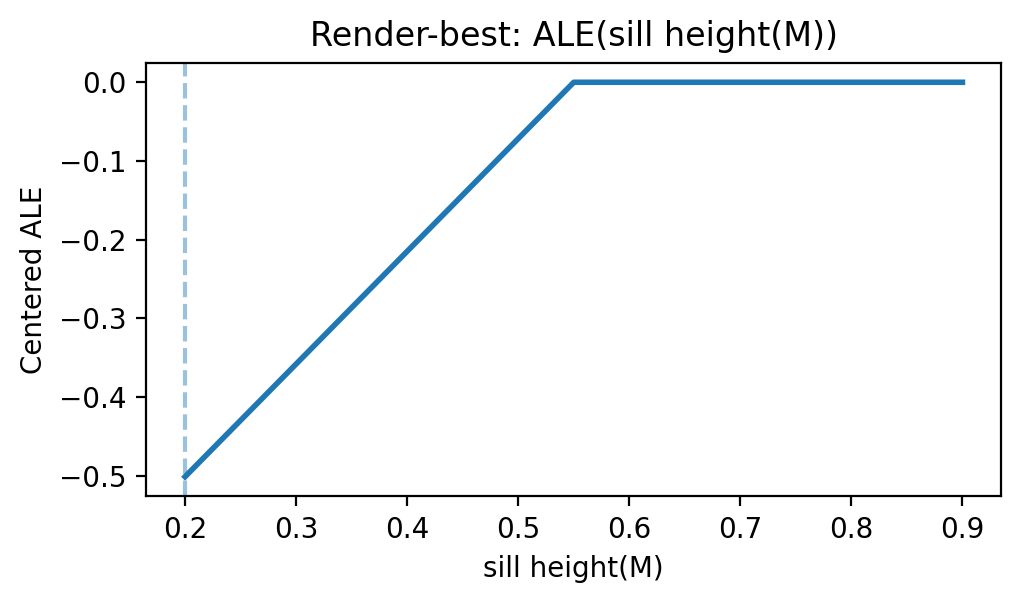

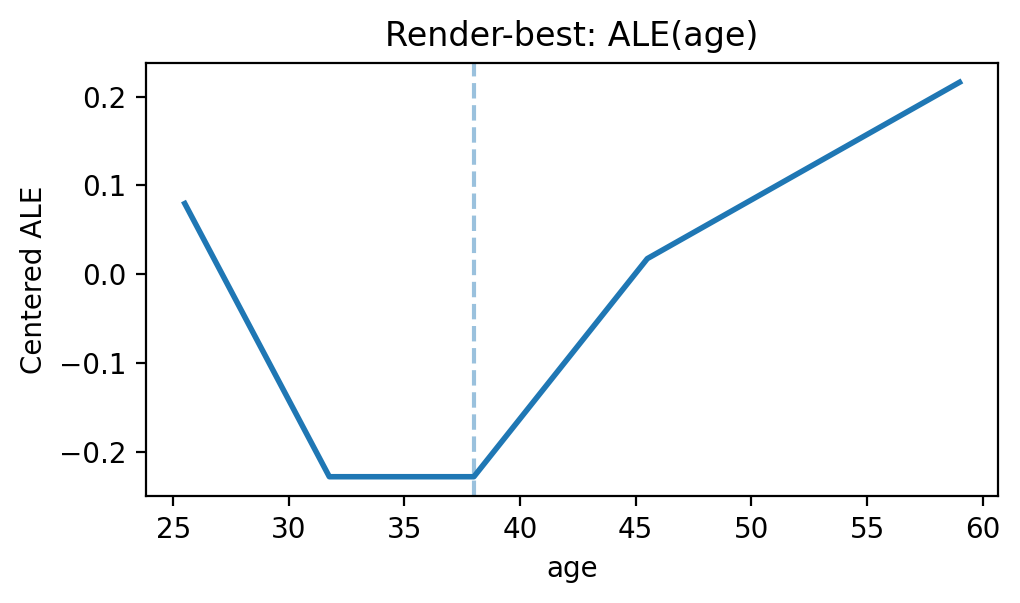

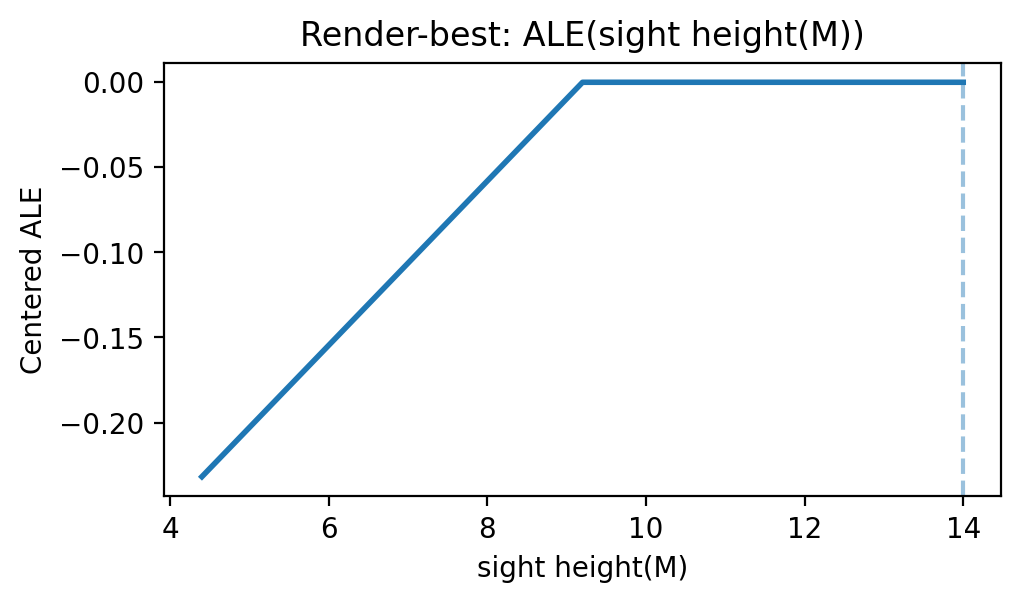

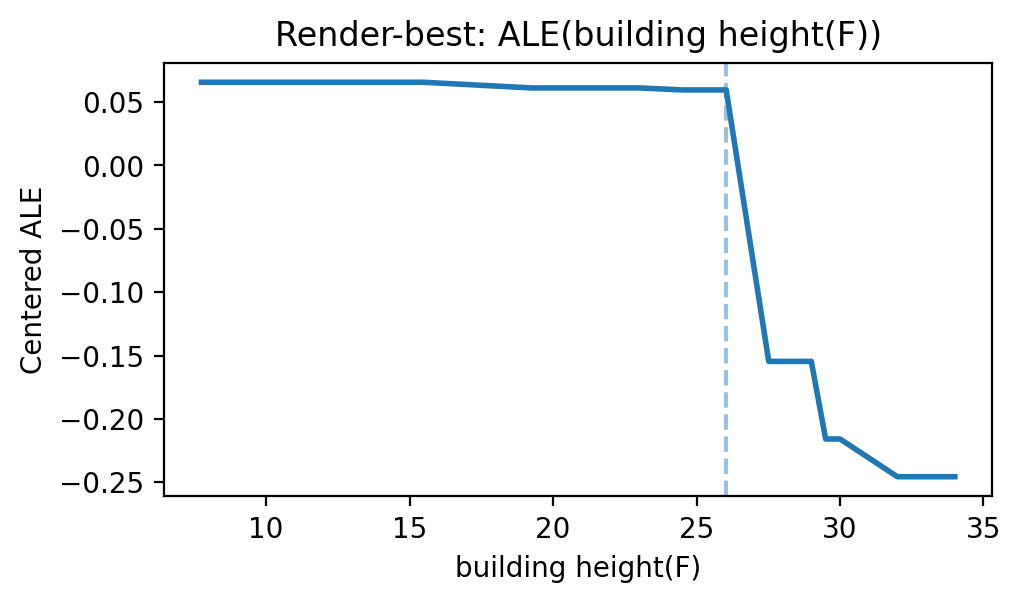

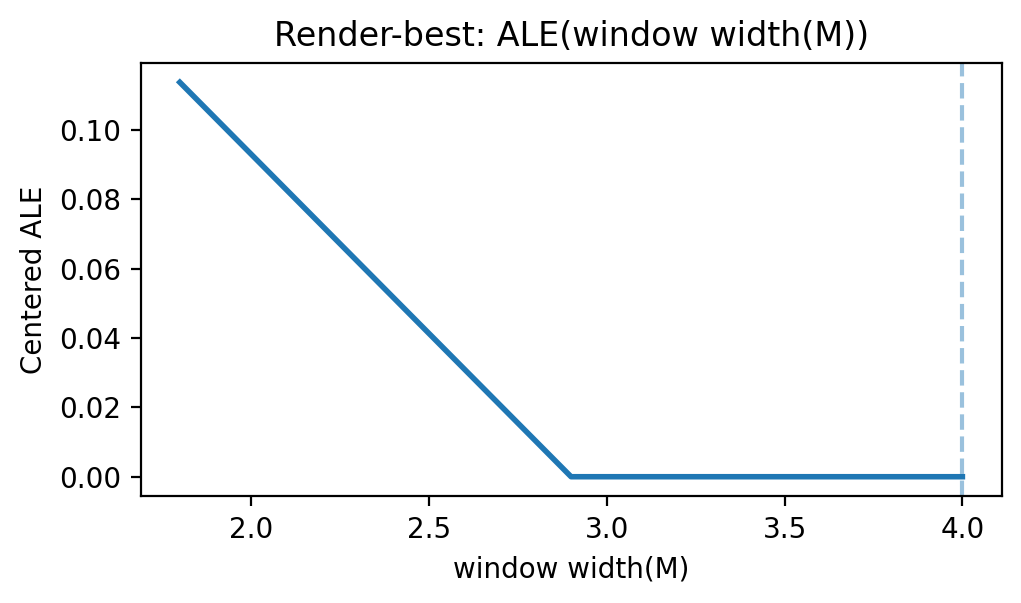

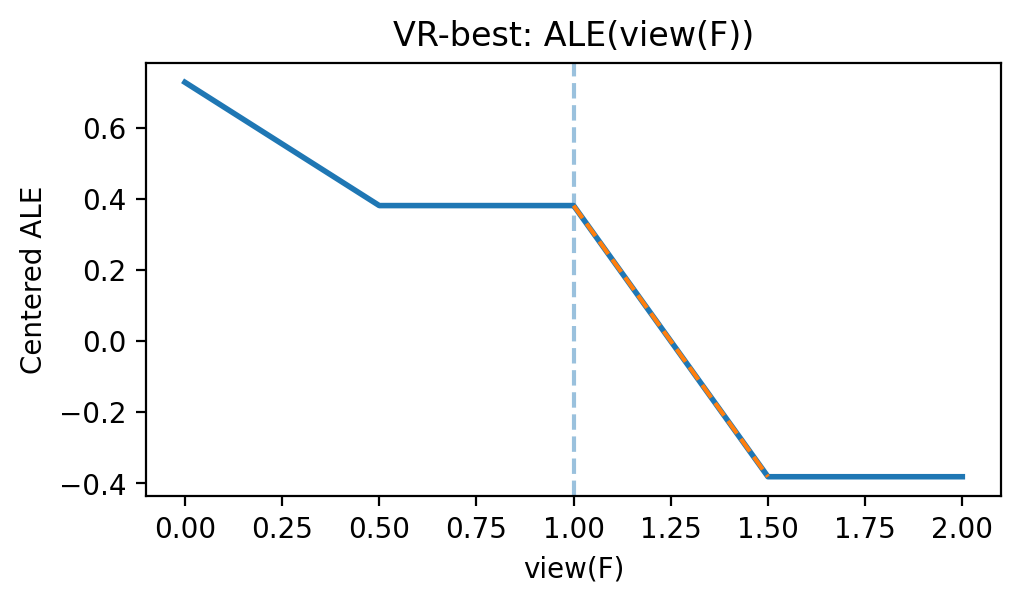

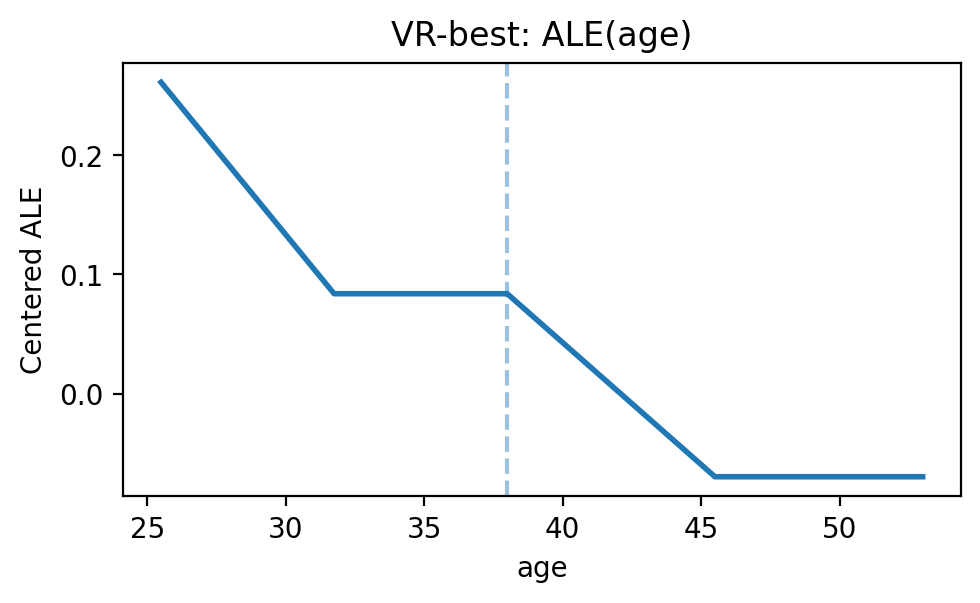

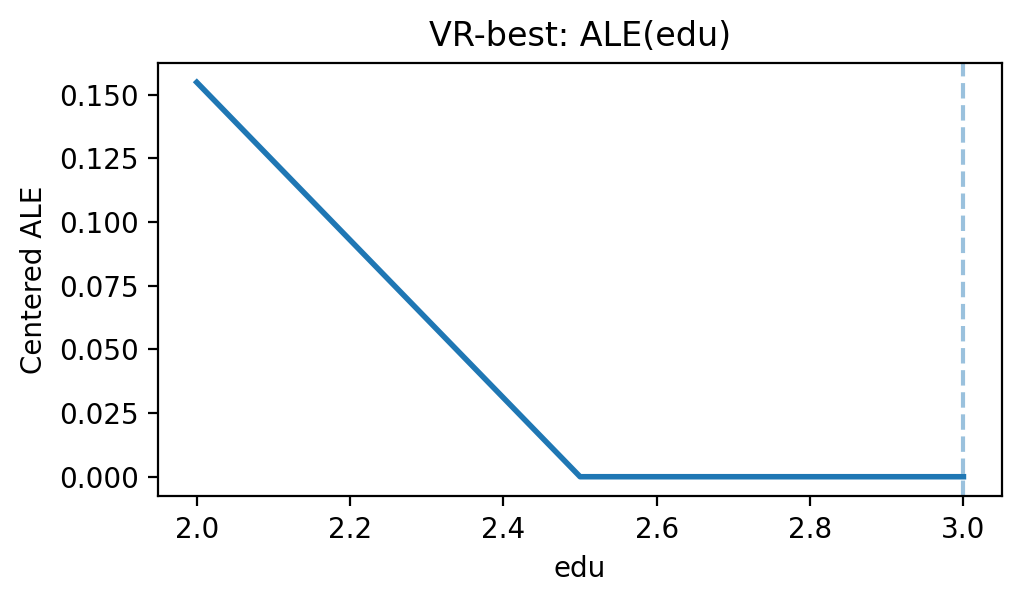

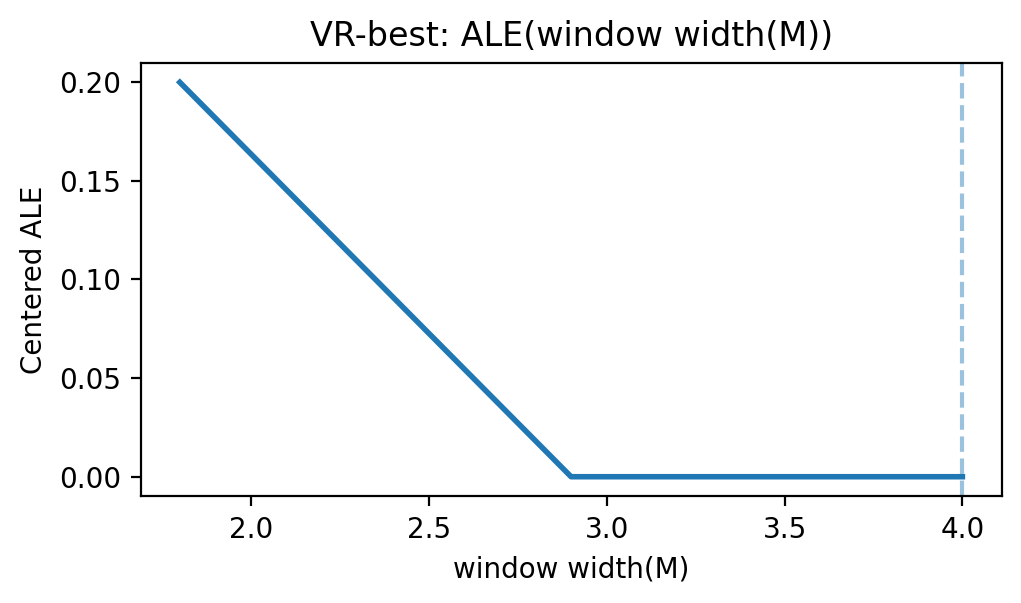

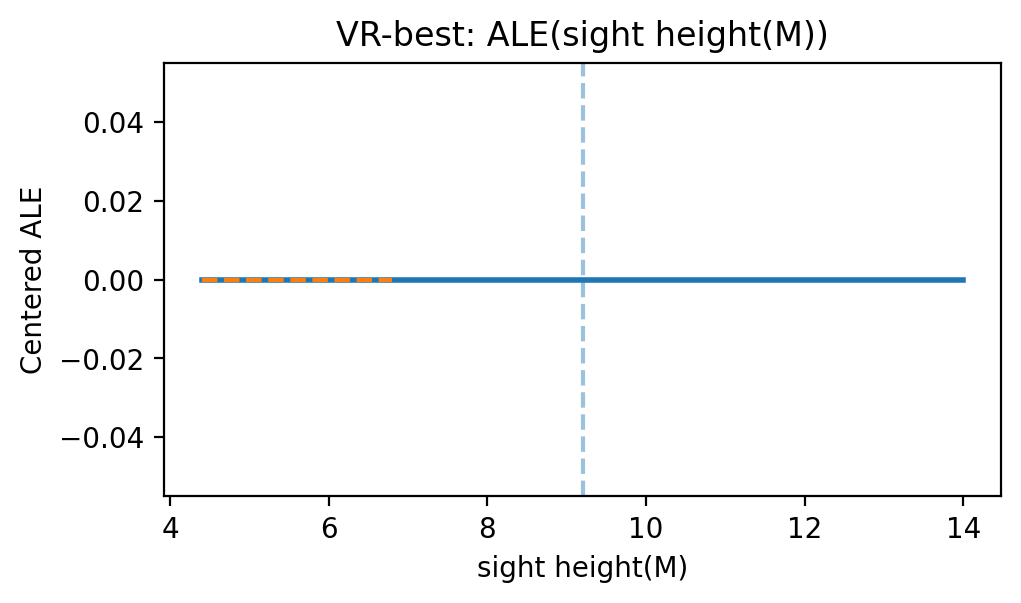

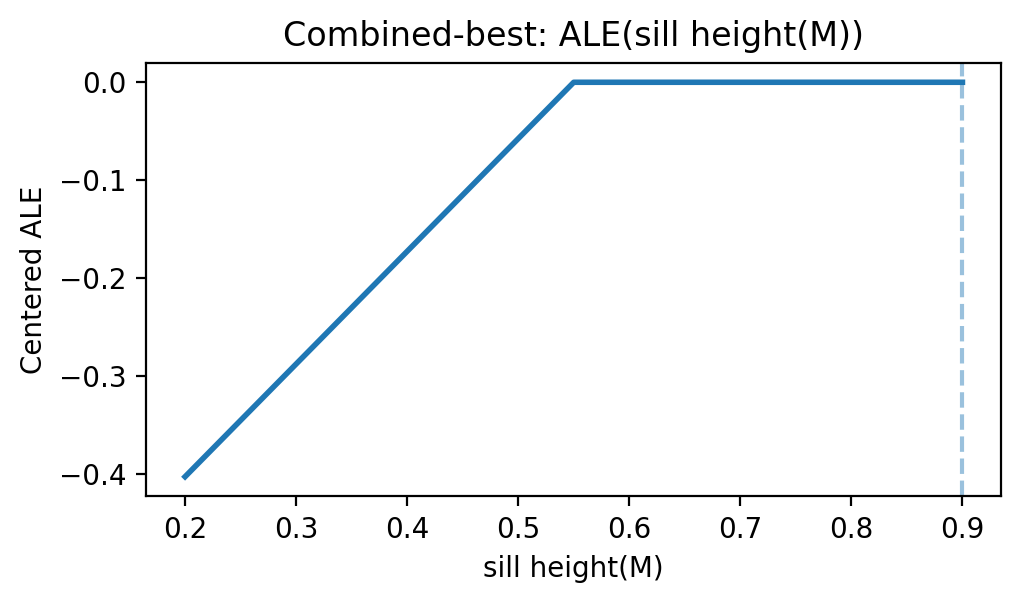

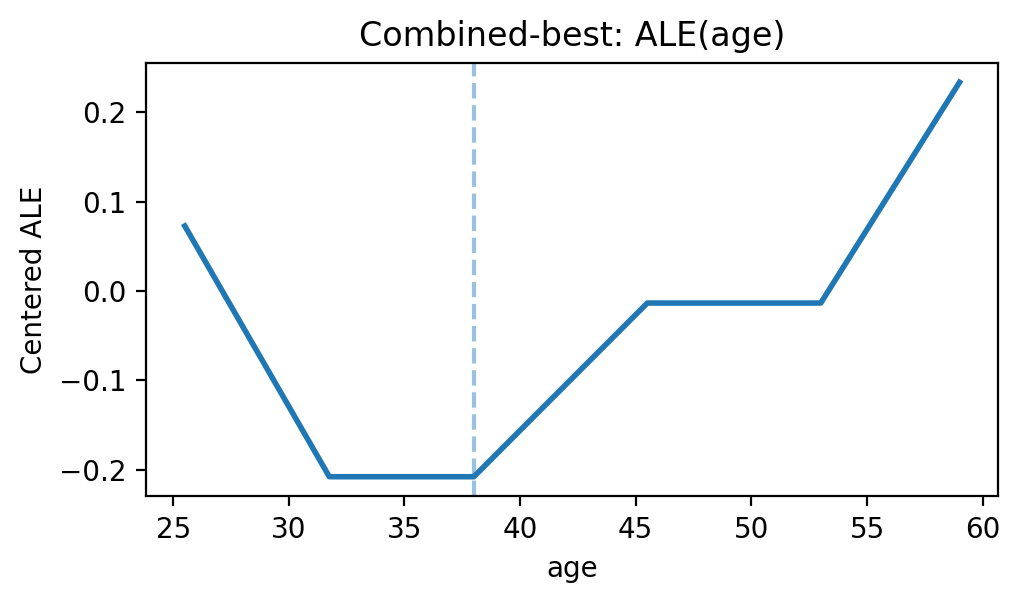

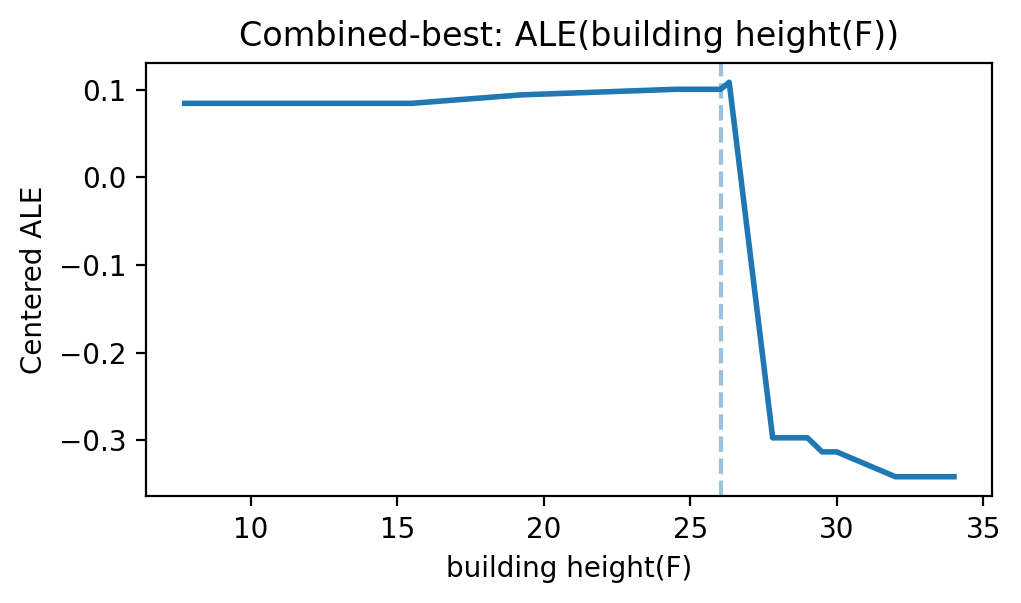

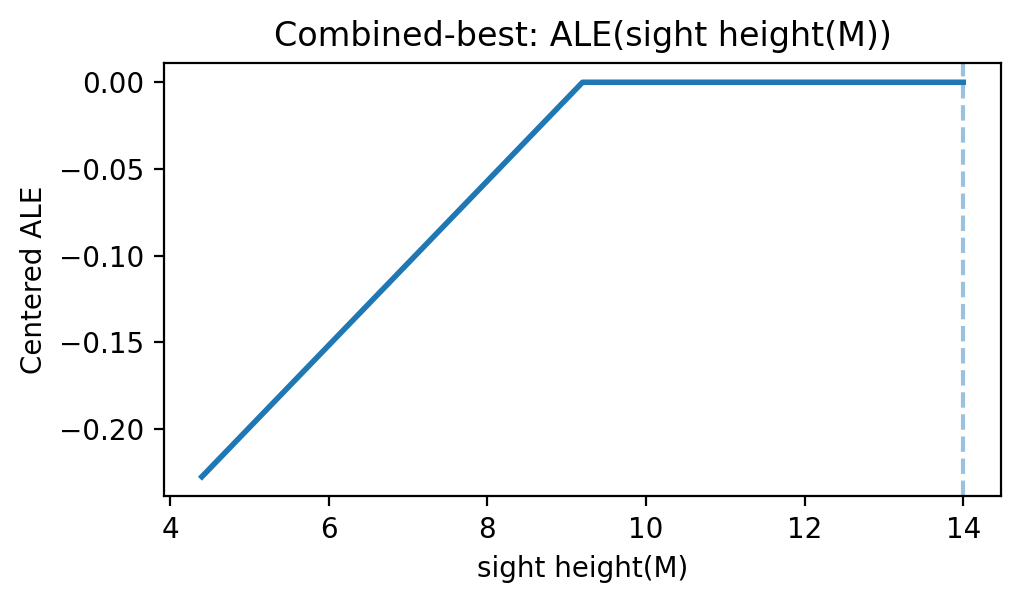

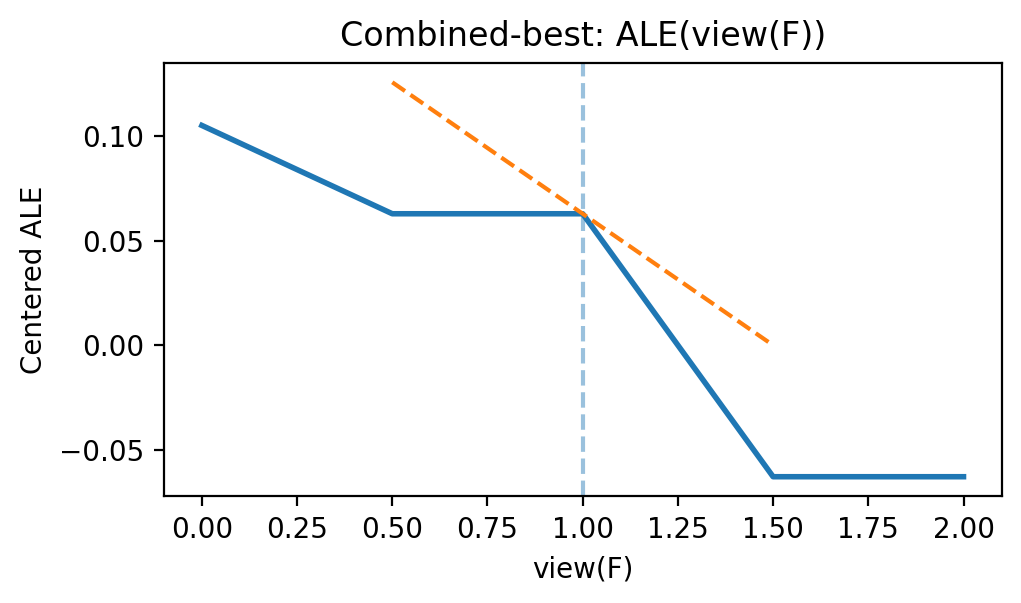

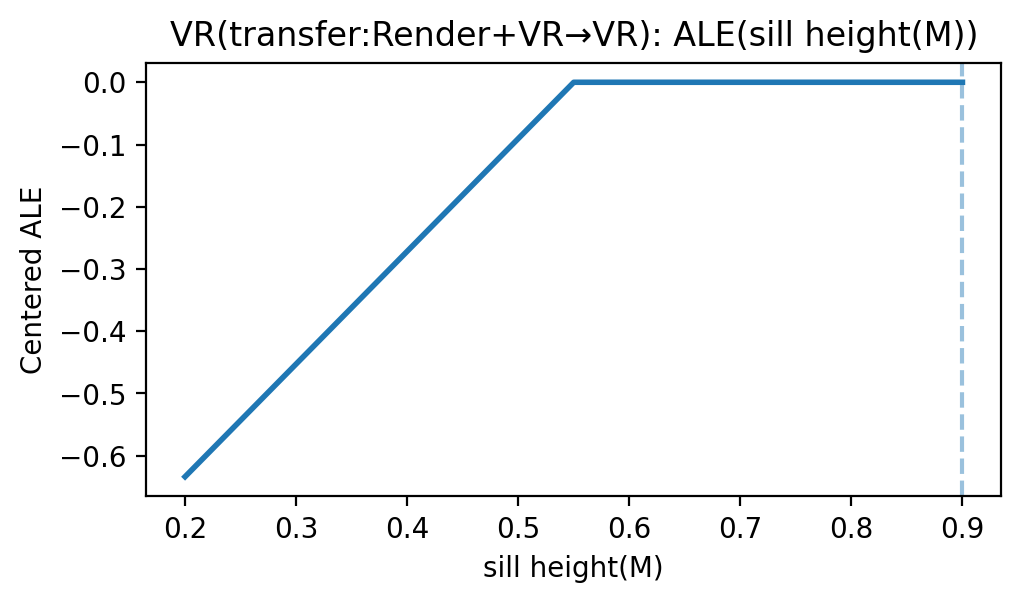

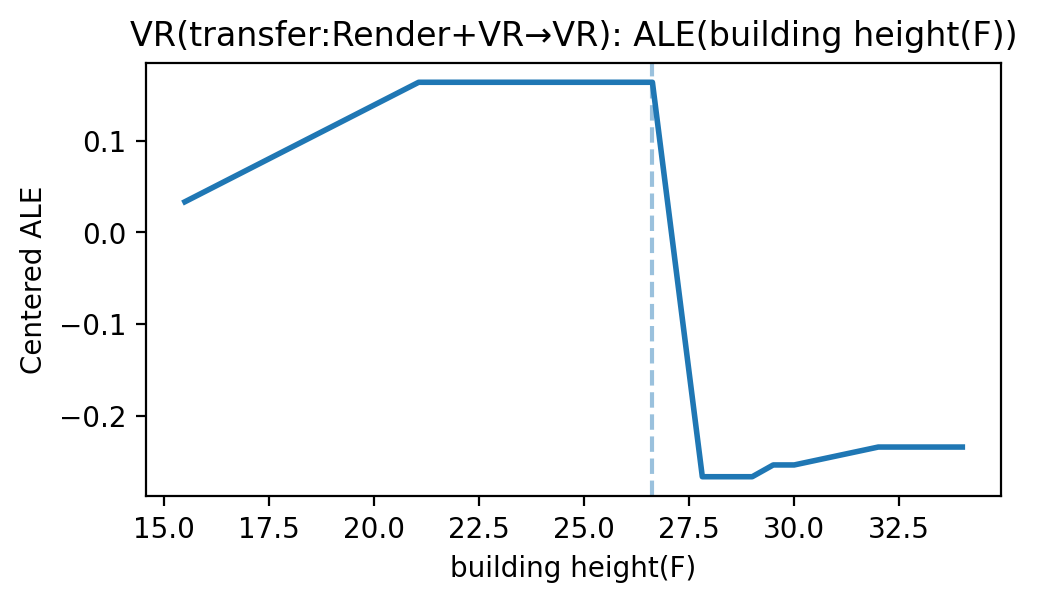

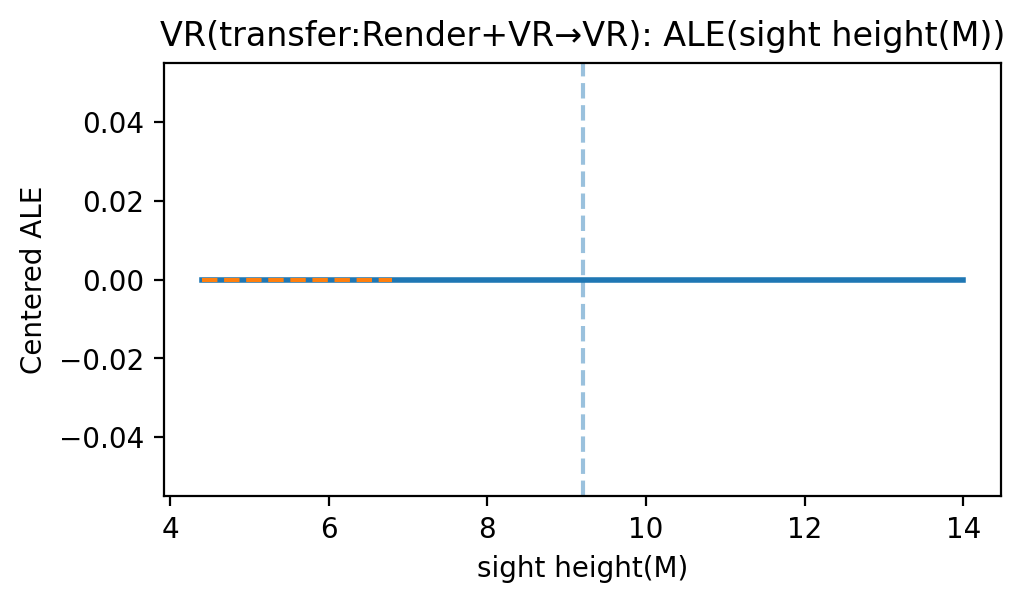

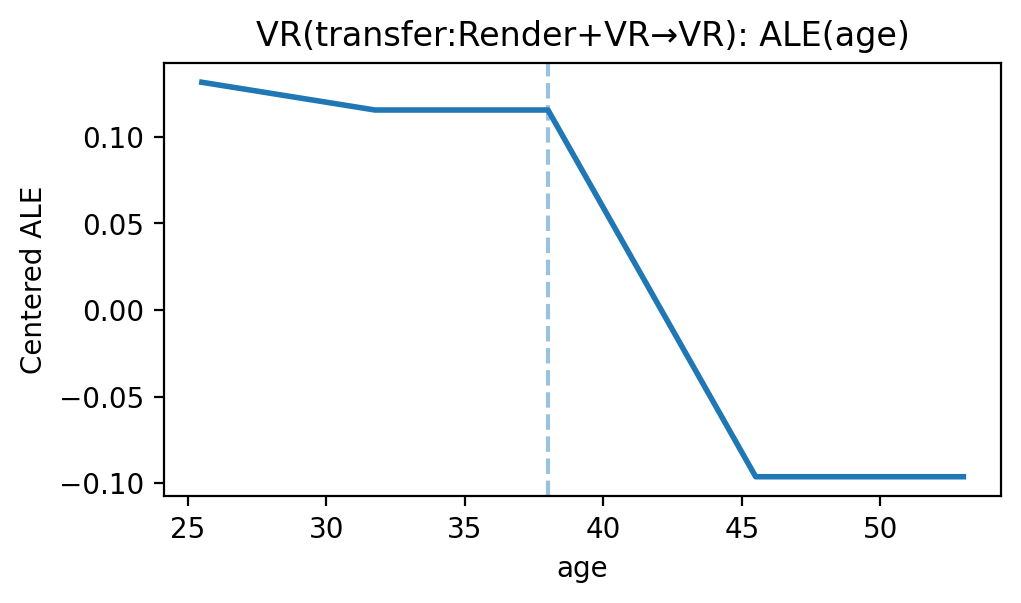

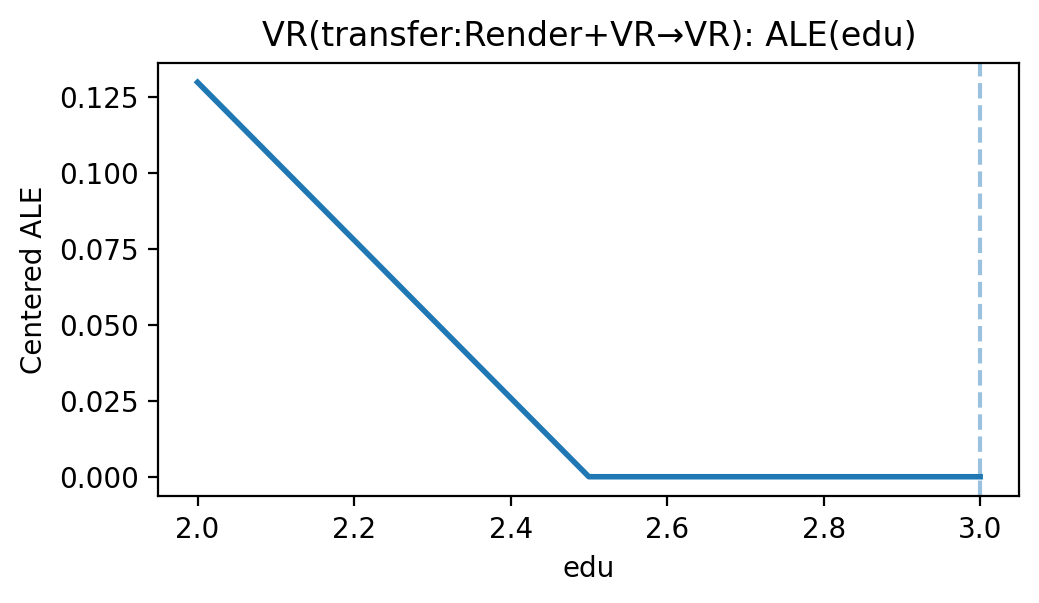

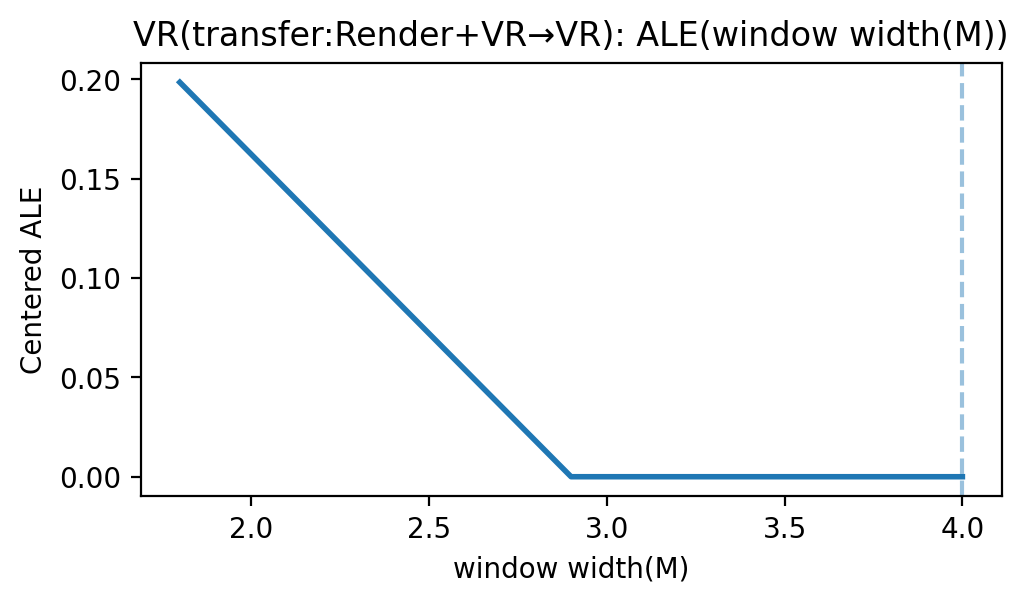

In [17]:
# =========================
# Stage 15 — Actionable deltas from centered ALE (near-median slope × 1 SD)
# =========================
begin_stage(
    "Actionable deltas from centered ALE",
    "Centered 1D ALE; approximate local slope near median × 1 SD → design-card deltas."
)

def simple_ale_1d(model, X: pd.DataFrame, feat: str, bins: int = 20):
    """
    1D ALE for feature `feat`:
      - Partition by empirical quantiles (bins)
      - For each interval [a,b): keep rows in that bin, predict Δy when setting feat to a→b
      - Accumulate, then center (weighted by bin width)
    Returns (centers, centered_ALE) with length = bins.
    """
    x = X[feat].to_numpy()
    if not np.issubdtype(x.dtype, np.number):
        raise ValueError(f"Feature '{feat}' is not numeric.")
    if np.nanstd(x) == 0:
        return np.array([np.nan]), np.array([0.0])

    qs = np.quantile(x, np.linspace(0, 1, bins + 1))
    # Lock ends to the observed min/max (guards against tiny tails)
    qs[0], qs[-1] = np.nanmin(x), np.nanmax(x)
    centers = 0.5 * (qs[:-1] + qs[1:])

    effects = []
    for a, b in zip(qs[:-1], qs[1:]):
        mask = (x >= a) & (x < b)
        if not np.any(mask):
            effects.append(0.0)
            continue
        Xa = X.copy()
        Xb = X.copy()
        Xa.loc[mask, feat] = a
        Xb.loc[mask, feat] = b
        ya = model.predict(Xa.loc[mask])
        yb = model.predict(Xb.loc[mask])
        effects.append(float(np.mean(yb - ya)))

    ale = np.cumsum(effects)
    # Center ALE by weighted average using bin widths
    widths = np.diff(qs)
    try:
        center_val = np.average(ale, weights=widths)
    except Exception:
        center_val = float(np.mean(ale))
    ale_centered = ale - center_val
    return centers, ale_centered

def design_cards_from_ale(model, X: pd.DataFrame, top_feats, tag: str = "DATA",
                          bins: int = 20, local_pts: int = 5):
    """
    For each feature:
      - Compute centered 1D ALE.
      - Fit a 1st-order poly near the median (local window ~ `local_pts` points).
      - Design delta = slope × 1 SD of that feature.
      - Save a small ALE curve and a table of suggested deltas.
    """
    rows = []
    for feat in top_feats:
        try:
            if feat not in X.columns:
                stage_note(f"[ALE][SKIP] {tag}: '{feat}' not in X.")
                continue
            sd = float(np.nanstd(X[feat].to_numpy()))
            if not np.isfinite(sd) or sd <= 1e-9:
                stage_note(f"[ALE][SKIP] {tag}: '{feat}' has near-zero variance.")
                continue

            xgrid, ale = simple_ale_1d(model, X, feat, bins=bins)
            if len(xgrid) < 3 or np.all(~np.isfinite(ale)):
                stage_note(f"[ALE][SKIP] {tag}: '{feat}' insufficient ALE points.")
                continue

            # Find indices closest to the median x and take a small neighborhood
            xmed = float(np.nanmedian(X[feat].to_numpy()))
            mid_idx = int(np.argmin(np.abs(xgrid - xmed)))
            # pick local_pts nearest to mid (cap within [0, len(xgrid)))
            order = np.argsort(np.abs(xgrid - xgrid[mid_idx]))[:max(3, local_pts)]
            order = np.sort(order)
            coef = float(np.polyfit(xgrid[order], ale[order], 1)[0])

            delta_x = sd
            delta_y = coef * delta_x
            rows.append({
                "Feature": feat,
                "UnitDelta": "+1 SD",
                "DeltaPrivacy≈": round(delta_y, 3),
                "Note": "ALE slope near median × 1 SD"
            })

            # --- Plot ALE curve ---
            plt.close('all')
            fig = plt.figure(figsize=(5.2, 3.1), dpi=180)
            plt.plot(xgrid, ale, lw=2)
            plt.axvline(xmed, ls="--", alpha=.45)
            # draw local linear approx
            xs = np.array([xgrid[order].min(), xgrid[order].max()])
            ys = np.polyval([coef, np.interp(xgrid[mid_idx], xgrid, ale) - coef * xgrid[mid_idx]], xs)
            plt.plot(xs, ys, ls="--", lw=1.5)
            plt.title(f"{tag}: ALE({feat})")
            plt.xlabel(feat); plt.ylabel("Centered ALE")
            plt.tight_layout()
            save_and_tex(
                fig,
                f"{_slug(tag)}_ale_{_slug(feat)}",
                f"{tag}: ALE for {feat}. Centered accumulated local effects; near-median slope used for Design Card.",
                dpi=200, bbox_inches="tight"
            )
            plt.close(fig)

        except Exception as e:
            stage_note(f"[ALE][WARN] {tag}: {feat} failed: {e}")

    df = pd.DataFrame(rows)
    if not df.empty:
        save_and_show_table(
            df,
            f"Design Cards — actionable deltas from ALE (near-median slopes) — {tag}",
            f"tab:design_{_slug(tag)}", f"design_cards_{_slug(tag)}",
            why="Local sensitivity around the typical setting; a +1 SD change estimates Δ privacy score."
        )
    return df

# ---- Helper to load top-6 features from saved SHAP tables (fallback to in-memory lists) ----
def _top6_from_csv(stem):
    csv = CSV_SUB / f"shap_imp_{stem}.csv"
    if csv.exists():
        try:
            return list(pd.read_csv(csv).head(6)["Feature"])
        except Exception:
            pass
    return []

# Gather top-6 per domain (falls back to top_r/v/c/t computed earlier)
top6_r = _top6_from_csv("render_best")          or (top_r[:6] if "top_r" in globals() else [])
top6_v = _top6_from_csv("vr_best")              or (top_v[:6] if "top_v" in globals() else [])
top6_c = _top6_from_csv("combined_best")        or (top_c[:6] if "top_c" in globals() else [])

# Transfer: build stem from BEST_TRANSFER_TAG
transfer_slug = _slug(BEST_TRANSFER_TAG.replace("transfer:", "")) if "BEST_TRANSFER_TAG" in globals() else "transfer"
top6_t = _top6_from_csv(f"vr_{transfer_slug}") or (top_t[:6] if "top_t" in globals() else [])

# ---- Prepare inputs and run ALE design cards ----
# For transfer TeacherFeature, augment X with teacher_pred so features match the model
def _maybe_augment_teacher(X: pd.DataFrame) -> pd.DataFrame:
    Xo = X.copy()
    if "TeacherFeature" in str(globals().get("BEST_TRANSFER_TAG", "")):
        X_r, y_r = train_render.drop(columns=[TARGET]), train_render[TARGET]
        _teacher = XGBRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=5,
            subsample=0.9, colsample_bytree=0.8, random_state=42,
            tree_method="hist", eval_metric="rmse", n_jobs=-1
        ).fit(X_r, y_r)
        Xo["teacher_pred"] = _teacher.predict(Xo)
    return Xo

# Build full design matrices (in case this stage runs standalone)
if "X_render_all" not in globals():
    X_render_all = pd.concat([train_render, test_render], ignore_index=True).drop(columns=[TARGET])
if "X_vr_all" not in globals():
    X_vr_all     = pd.concat([train_vr,     test_vr    ], ignore_index=True).drop(columns=[TARGET])
if "X_comb_all" not in globals():
    X_comb_all   = pd.concat([train_combined, test_combined], ignore_index=True).drop(columns=[TARGET])

# Execute per domain
_ = design_cards_from_ale(est_r_best,          X_render_all,               top6_r, tag="Render-best")
_ = design_cards_from_ale(est_v_best,          X_vr_all,                   top6_v, tag="VR-best")
_ = design_cards_from_ale(est_c_best,          X_comb_all,                 top6_c, tag="Combined-best")
_ = design_cards_from_ale(BEST_TRANSFER_MODEL, _maybe_augment_teacher(X_vr_all), top6_t, tag=f"VR({BEST_TRANSFER_TAG})")



## Stage 16 — Ablation (drop feature groups)

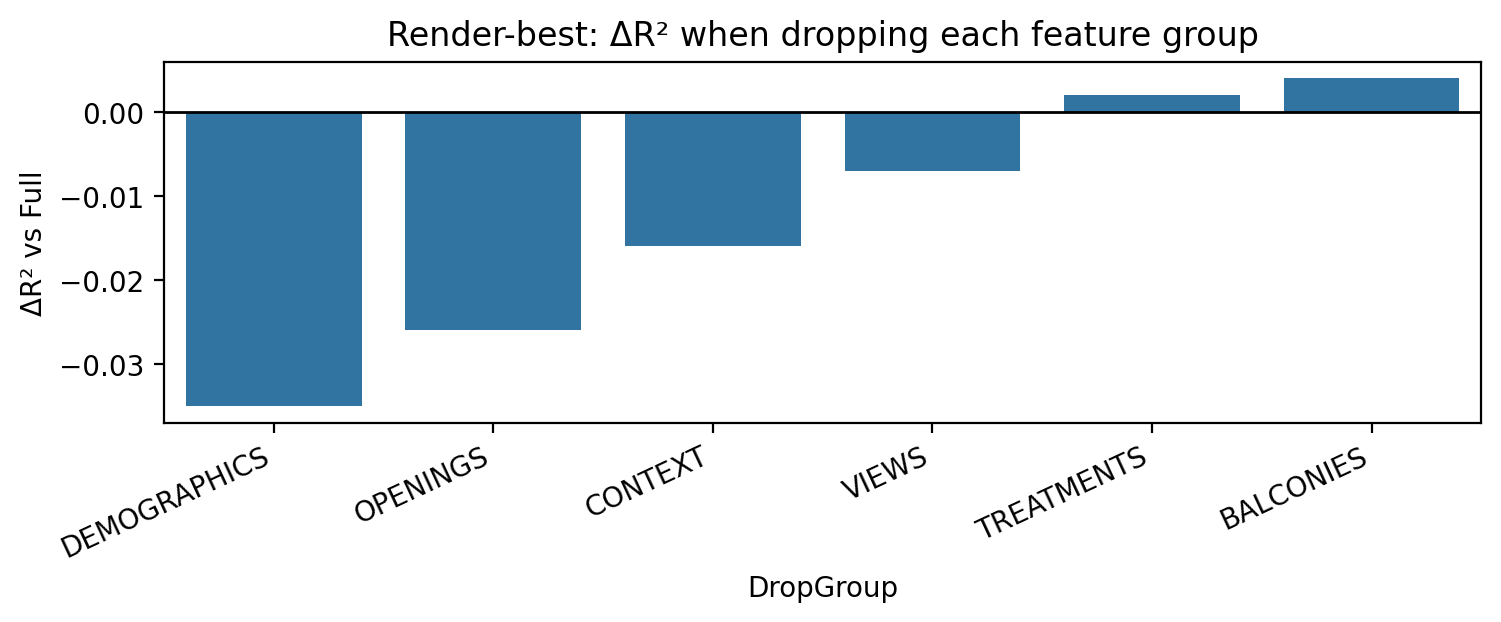

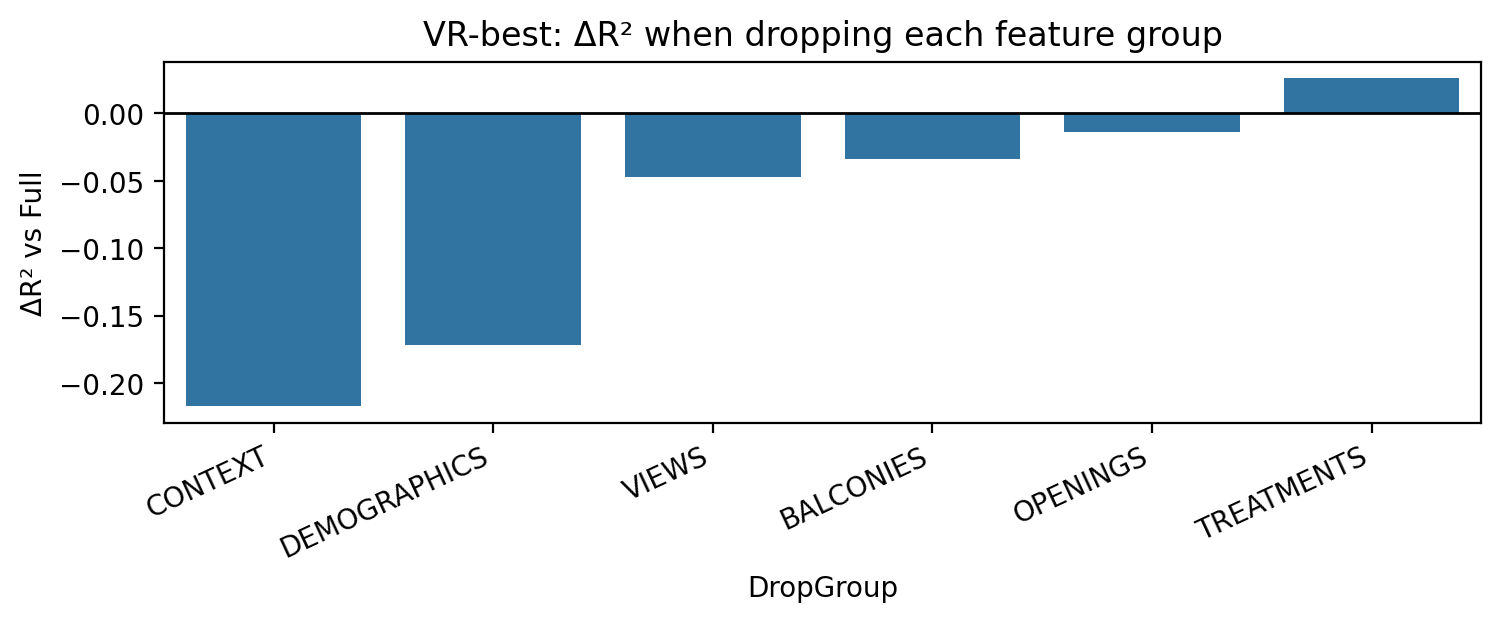

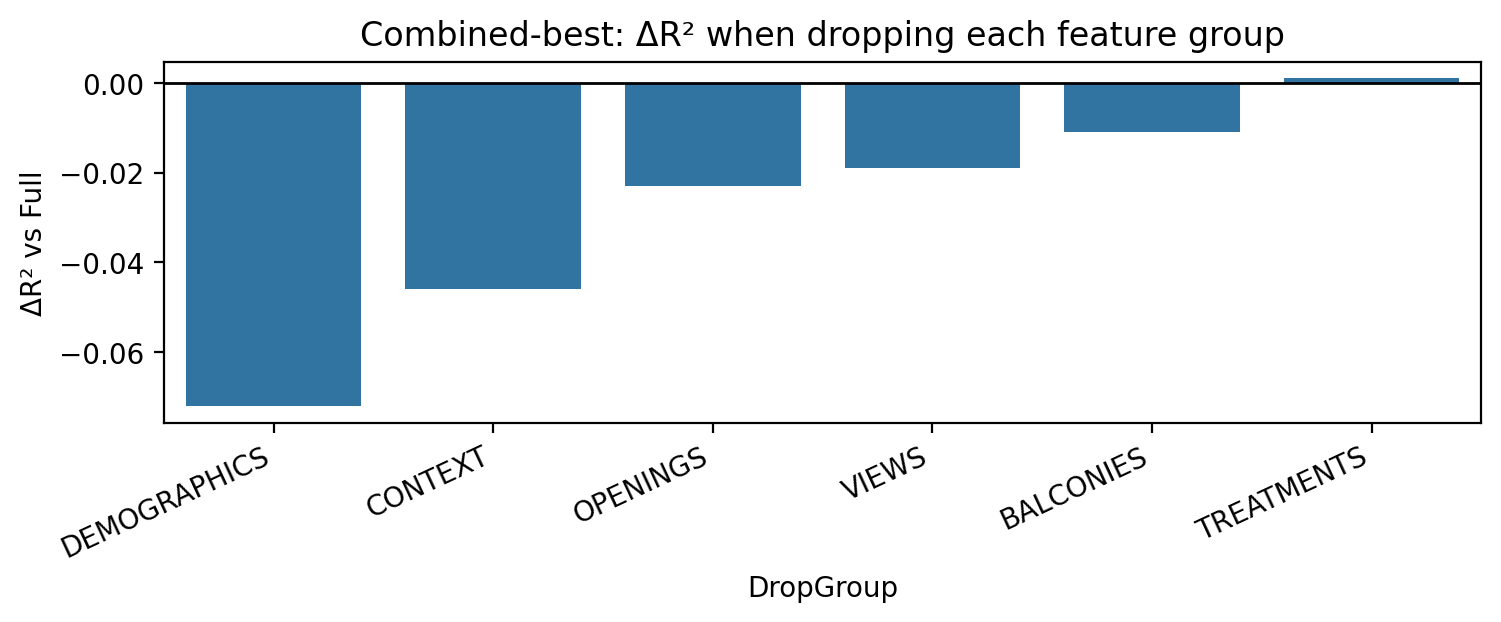

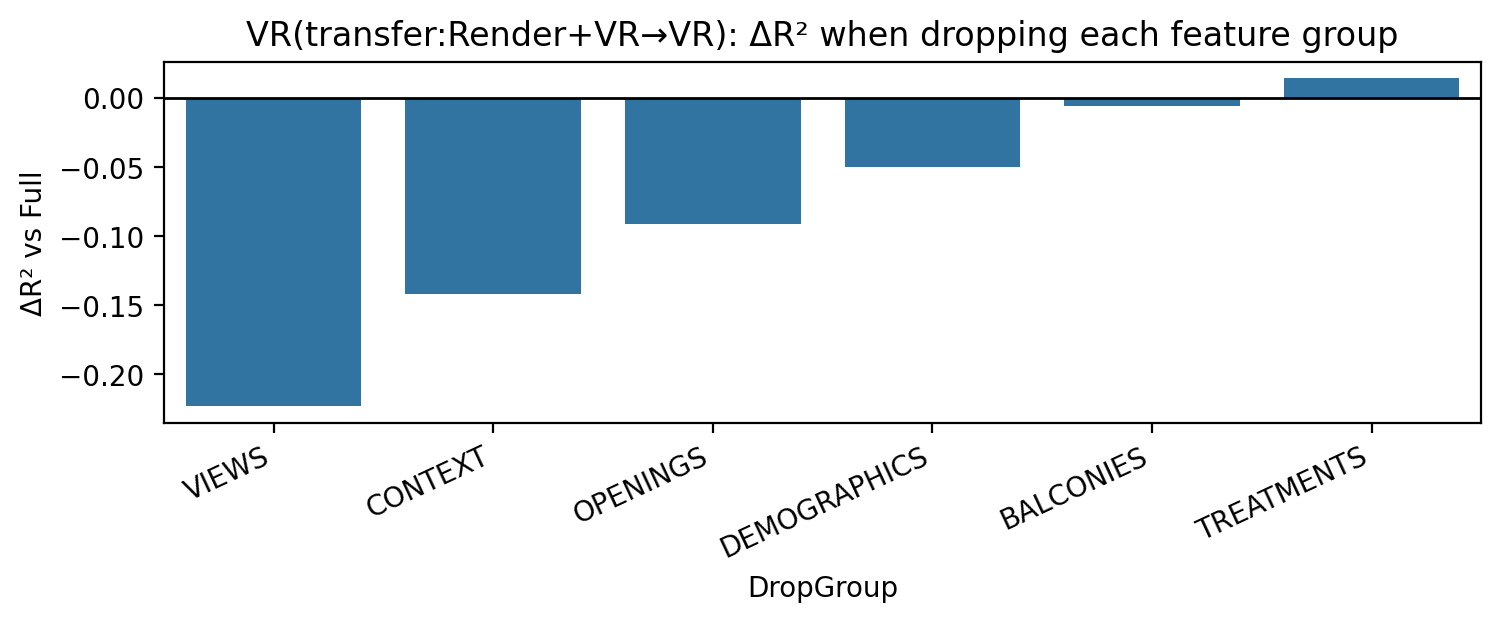

In [18]:
# =========================
# Stage 16 — Ablation (drop feature groups)
# =========================
begin_stage(
    "Ablation (drop feature groups)",
    "Change in test performance when removing feature groups; importance via ΔR² vs Full."
)

from sklearn.base import clone

# Default groups (tweak as needed)
FEAT_GROUPS = {
    "DEMOGRAPHICS": ['sex','age','edu','space category'],
    "OPENINGS": ['window width(M)','window width(L)','window width(F)','window width(R)',
                 'sill height(M)','sill height(L)','sill height(F)','sill height(R)'],
    "CONTEXT": ['building height(L)','building height(F)','building height(R)','street width(M)','sight height(M)'],
    "TREATMENTS": ['curtain(L)','curtain(F)','curtain(R)'],
    "BALCONIES": ['balcony','balcony(L)','balcony(F)','balcony(R)'],
    "VIEWS": ['view(L)','view(F)','view(R)'],
}

def _maybe_add_transfer_group(groups: dict, X_columns) -> dict:
    """
    If the current design matrix contains the teacher feature, include a group so we can ablate it.
    """
    g = dict(groups)  # shallow copy
    if "teacher_pred" in X_columns and "TRANSFER_FEATURE" not in g:
        g["TRANSFER_FEATURE"] = ["teacher_pred"]
    return g

def _maybe_augment_teacher_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    If BEST_TRANSFER_MODEL is the TeacherFeature variant, augment df with teacher_pred so the
    feature space matches the model trained earlier.
    """
    if "TeacherFeature" in str(globals().get("BEST_TRANSFER_TAG", "")):
        X_r, y_r = train_render.drop(columns=[TARGET]), train_render[TARGET]
        _teacher = XGBRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=5,
            subsample=0.9, colsample_bytree=0.8, random_state=42,
            tree_method="hist", eval_metric="rmse", n_jobs=-1
        ).fit(X_r, y_r)
        X_aug = df.drop(columns=[TARGET]).copy()
        X_aug["teacher_pred"] = _teacher.predict(X_aug)
        df_aug = pd.concat([X_aug, df[[TARGET]].reset_index(drop=True)], axis=1)
        return df_aug
    return df

def ablation_table(best_estimator, train_df, test_df, tag="DATA", feat_groups=None):
    """
    For each group, drop its columns, refit a fresh clone, and evaluate on the same test split.
    Importance = ΔR² vs Full (more negative = more important).
    """
    results = []

    # If transfer model uses teacher feature, ensure DF is augmented
    train_df_local = train_df.copy()
    test_df_local  = test_df.copy()
    if best_estimator is BEST_TRANSFER_MODEL and "TeacherFeature" in str(globals().get("BEST_TRANSFER_TAG", "")):
        train_df_local = _maybe_augment_teacher_df(train_df_local)
        test_df_local  = _maybe_augment_teacher_df(test_df_local)

    # Prepare matrices
    Xtr_full, ytr = train_df_local.drop(columns=[TARGET]), train_df_local[TARGET]
    Xte_full, yte = test_df_local.drop(columns=[TARGET]),  test_df_local[TARGET]

    # Add transfer-feature group if present
    fg = _maybe_add_transfer_group(feat_groups or FEAT_GROUPS, Xtr_full.columns)

    # Full reference (fresh clone)
    model_full = clone(best_estimator)
    model_full.fit(Xtr_full, ytr)
    yhat_full = model_full.predict(Xte_full)
    base_rmse = RMSE(yte, yhat_full)
    base_mae  = mean_absolute_error(yte, yhat_full)
    base_r2   = r2_score(yte, yhat_full)

    results.append({"DropGroup":"NONE (Full)", "RMSE":base_rmse, "MAE":base_mae, "R2":base_r2})

    # Per-group ablation
    for gname, cols in fg.items():
        drop_cols = [c for c in cols if c in Xtr_full.columns]
        if not drop_cols:
            stage_note(f"[{tag}] Skipping group '{gname}' (no matching columns).")
            continue
        keep_cols = [c for c in Xtr_full.columns if c not in drop_cols]
        if not keep_cols:
            stage_note(f"[{tag}] Skipping group '{gname}' (would drop all predictors).")
            continue

        Xtr_g = Xtr_full[keep_cols]
        Xte_g = Xte_full[keep_cols]

        est_g = clone(best_estimator)
        est_g.fit(Xtr_g, ytr)
        yhat_g = est_g.predict(Xte_g)

        results.append({
            "DropGroup": gname,
            "RMSE": RMSE(yte, yhat_g),
            "MAE":  mean_absolute_error(yte, yhat_g),
            "R2":   r2_score(yte, yhat_g)
        })

    # Table: add ΔR² vs Full and sort
    df_ab = pd.DataFrame(results)
    base_val = float(df_ab.loc[df_ab.DropGroup=="NONE (Full)","R2"].values[0])
    df_ab["Delta_R2_vs_Full"] = df_ab["R2"] - base_val
    df_ab = df_ab.assign(
        RMSE=lambda d: d.RMSE.round(3),
        MAE=lambda d:  d.MAE.round(3),
        R2=lambda d:   d.R2.round(3),
        Delta_R2_vs_Full=lambda d: d.Delta_R2_vs_Full.round(3)
    )

    # Save + inline preview
    save_and_show_table(
        df_ab.sort_values(["DropGroup"]),  # keep Full first in CSV; plot will sort by Δ
        f"Ablation (drop feature groups) — {tag}",
        f"tab:ablate_{_slug(tag)}",
        f"ablation_{_slug(tag)}",
        why="ΔR² vs Full shows contribution of each group (more negative = more important)."
    )

    # Plot ΔR² (excluding the Full row), sorted ascending so most important (most negative) on left
    try:
        df_plot = df_ab[df_ab.DropGroup!="NONE (Full)"].copy()
        df_plot.sort_values("Delta_R2_vs_Full", inplace=True)
        fig = plt.figure(figsize=(7.6, 3.2), dpi=180)
        sns.barplot(x="DropGroup", y="Delta_R2_vs_Full", data=df_plot)
        plt.axhline(0, color="k", lw=1)
        plt.xticks(rotation=25, ha="right")
        plt.ylabel("ΔR² vs Full")
        plt.title(f"{tag}: ΔR² when dropping each feature group")
        plt.tight_layout()
        save_and_tex(
            fig,
            f"{_slug(tag)}_ablation_deltaR2",
            f"{tag}: Change in test R² when removing a feature group; negative bars indicate important groups.",
            dpi=200, bbox_inches="tight"
        )
        plt.close(fig)
    except Exception as e:
        stage_note(f"{tag}: ablation plot skipped ({e})")

    return df_ab

# ---- Run across domains ----
_ = ablation_table(est_r_best,          train_render,   test_render,   tag="Render-best")
_ = ablation_table(est_v_best,          train_vr,       test_vr,       tag="VR-best")
_ = ablation_table(est_c_best,          train_combined, test_combined, tag="Combined-best")
_ = ablation_table(BEST_TRANSFER_MODEL, train_vr,       test_vr,       tag=f"VR({BEST_TRANSFER_TAG})")


## Stage 17 — Bootstrap 95% CI for test R² (group-aware)

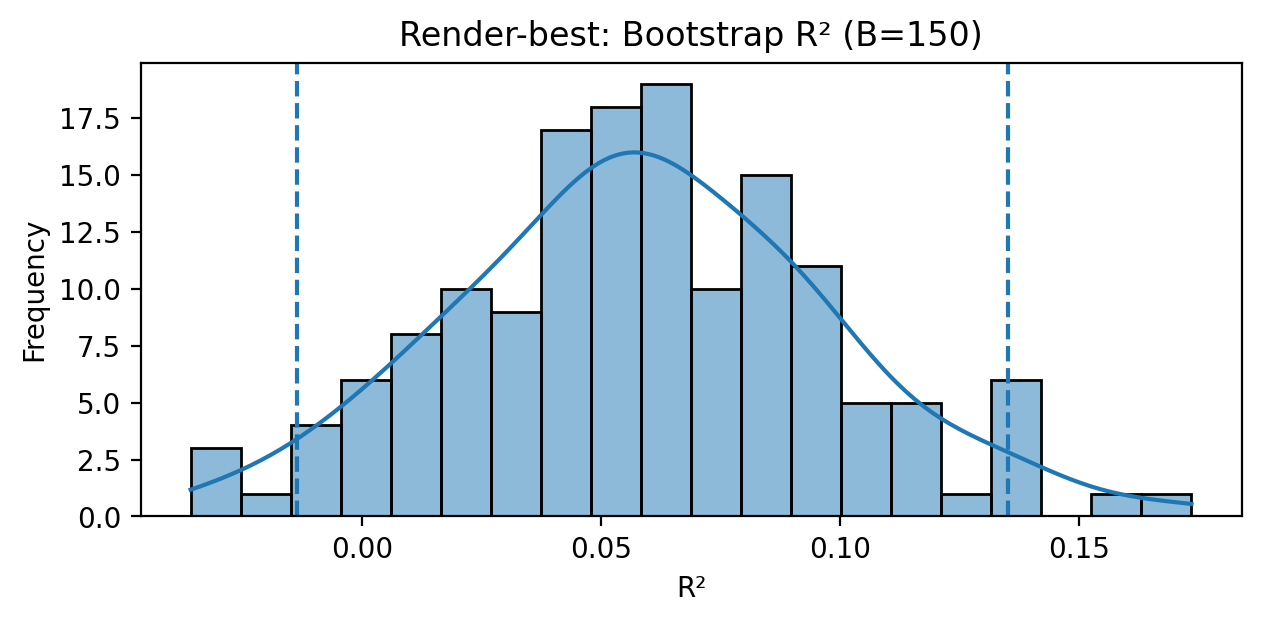

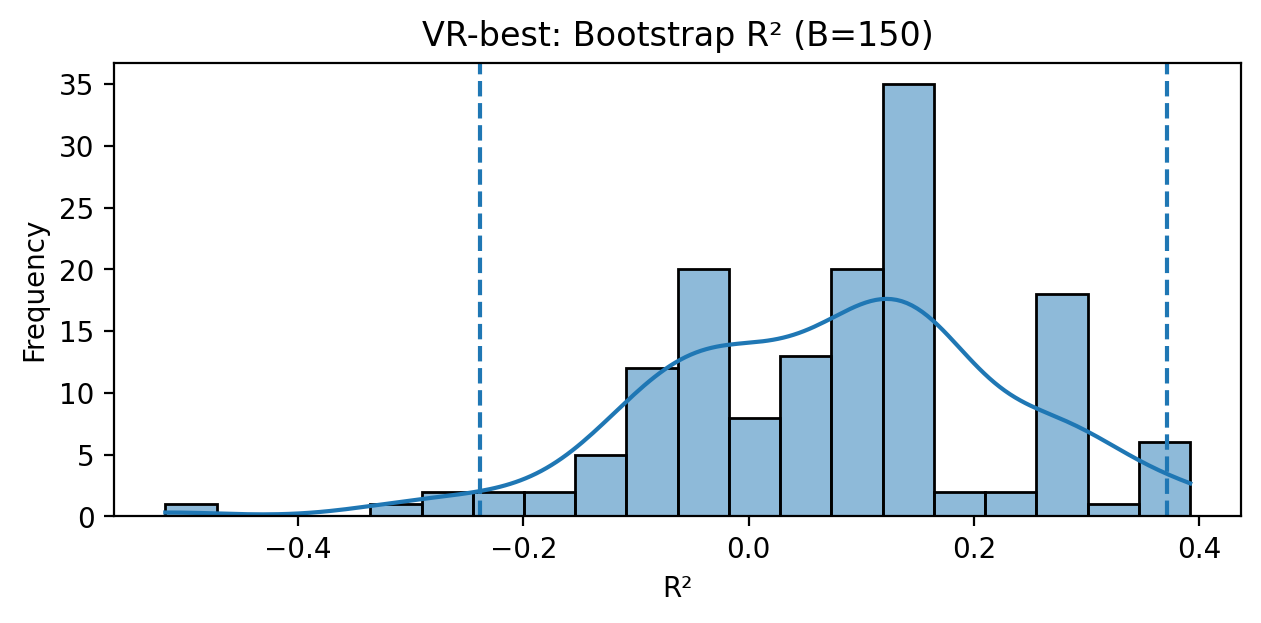

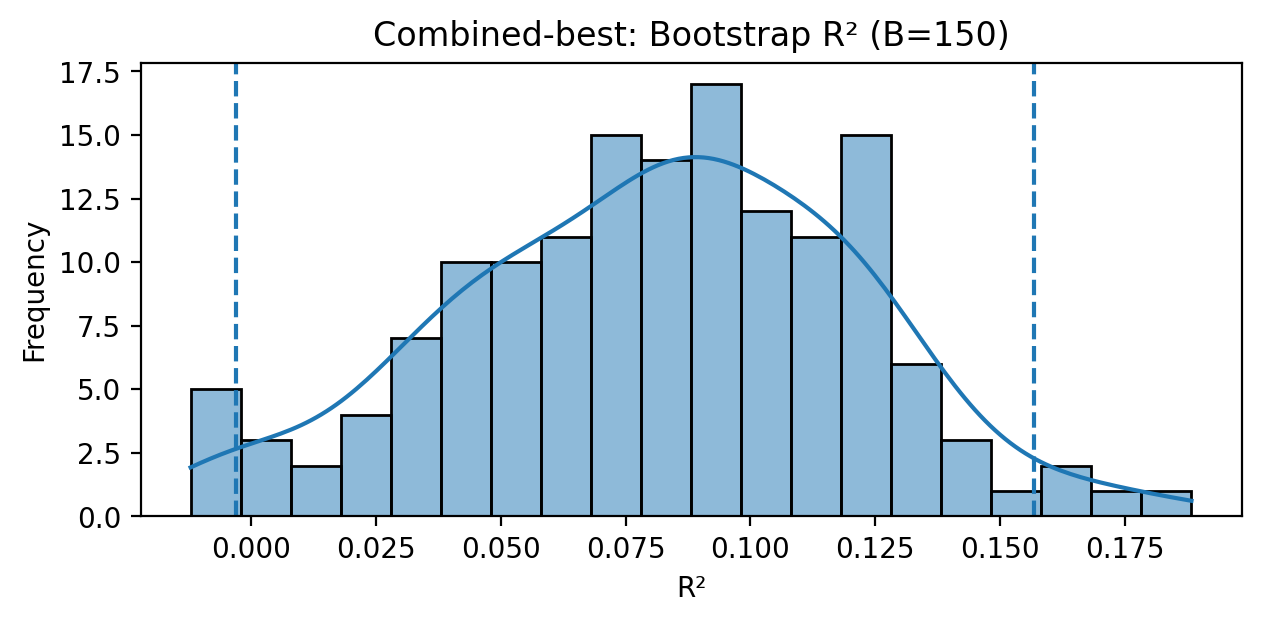

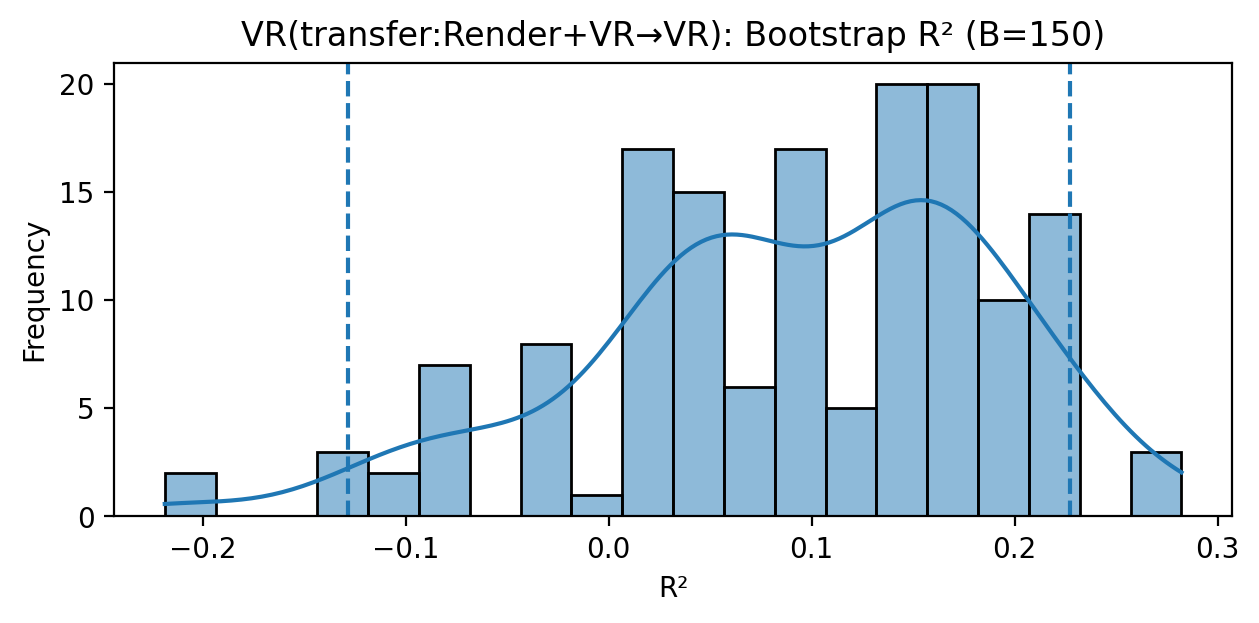

In [19]:
# =========================
# Stage 17 — Bootstrap 95% CI for test R² (group-aware)
# =========================
begin_stage(
    "Bootstrap 95% CI for test R² (group-aware)",
    "Resample test *groups* with replacement to reflect scenario-level variability."
)

from sklearn.base import clone

def _groups_hash(df, cols):
    cols = [c for c in cols if c in df.columns]
    if not cols:
        # fallback: each row its own "group"
        return pd.Series(np.arange(len(df)), index=df.index).astype(str)
    return df[cols].astype(str).agg('_'.join, axis=1)

def _maybe_augment_teacher_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    If BEST_TRANSFER_MODEL is the TeacherFeature variant, augment df with teacher_pred so the
    feature space matches that model.
    """
    if "TeacherFeature" in str(globals().get("BEST_TRANSFER_TAG", "")):
        X_r, y_r = train_render.drop(columns=[TARGET]), train_render[TARGET]
        _teacher = XGBRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=5,
            subsample=0.9, colsample_bytree=0.8, random_state=42,
            tree_method="hist", eval_metric="rmse", n_jobs=-1
        ).fit(X_r, y_r)
        X_aug = df.drop(columns=[TARGET]).copy()
        X_aug["teacher_pred"] = _teacher.predict(X_aug)
        return pd.concat([X_aug, df[[TARGET]].reset_index(drop=True)], axis=1)
    return df

def bootstrap_r2_ci(best_estimator, train_df, test_df, B=150, tag="DATA",
                    random_state=42, use_teacher_feature=False):
    """
    Group-aware bootstrap over test groups:
      - Fit on full train once
      - Predict on full test once
      - Resample *groups* with replacement, recompute R² per bootstrap sample
      - Return mean R² and (2.5%, 97.5%) CI
    If `use_teacher_feature=True`, rebuilds teacher_pred in train/test before fitting.
    """
    rng = np.random.default_rng(random_state)

    # Optional teacher feature augmentation
    tr_local = _maybe_augment_teacher_df(train_df) if use_teacher_feature else train_df
    te_local = _maybe_augment_teacher_df(test_df)  if use_teacher_feature else test_df

    # Fit once on train
    Xtr, ytr = tr_local.drop(columns=[TARGET]), tr_local[TARGET]
    est = clone(best_estimator).fit(Xtr, ytr)

    # Predict once on test
    Xte, yte = te_local.drop(columns=[TARGET]), te_local[TARGET]
    yhat_full = est.predict(Xte)

    # Build group index on the test split
    ghash = _groups_hash(te_local, GROUP_COLS)
    uniq = ghash.unique()
    group_index = {g: np.flatnonzero(ghash.values == g) for g in uniq}

    # If grouping is degenerate, fall back to row bootstrap
    use_row_boot = len(uniq) <= 1
    if use_row_boot:
        stage_note(f"[BOOT][INFO] {tag}: only {len(uniq)} test group(s) — falling back to row bootstrap.")

    r2s = []
    for b in range(int(B)):
        if use_row_boot:
            idx = rng.integers(0, len(Xte), size=len(Xte))
        else:
            draw = rng.choice(uniq, size=len(uniq), replace=True)
            idx = np.concatenate([group_index[g] for g in draw]) if len(draw) else np.array([], dtype=int)
        if idx.size == 0:
            continue
        r2s.append(r2_score(yte.iloc[idx], np.asarray(yhat_full)[idx]))
        if (b+1) % max(1, B//5) == 0:
            stage_note(f"[BOOT] {tag}: {b+1}/{B} samples…")

    r2s = np.asarray(r2s, dtype=float)
    if r2s.size == 0:
        stage_note(f"[BOOT][WARN] {tag}: no bootstrap samples produced.")
        return np.nan, (np.nan, np.nan)

    mean_r2 = float(np.nanmean(r2s))
    lo, hi  = np.nanpercentile(r2s, [2.5, 97.5])

    # Save table + inline preview
    df_ci = pd.DataFrame({
        "Dataset": [tag], "B": [B],
        "R2_mean": [round(mean_r2, 3)],
        "R2_2.5%": [round(float(lo), 3)],
        "R2_97.5%": [round(float(hi), 3)],
        "ResampleUnit": ["row" if use_row_boot else "group"]
    })
    save_and_show_table(
        df_ci,
        f"Bootstrap 95% CI for test R² — {tag}",
        f"tab:bootr2_{_slug(tag)}",
        f"bootr2_{_slug(tag)}",
        why="Scenario-level variability on test via group-aware bootstrap (row bootstrap fallback if only 1 group)."
    )

    # Histogram
    plt.close('all')
    fig = plt.figure(figsize=(6.4, 3.2), dpi=180)
    sns.histplot(r2s, bins=20, kde=True)
    plt.axvline(lo, ls="--"); plt.axvline(hi, ls="--")
    plt.xlabel("R²"); plt.ylabel("Frequency")
    plt.title(f"{tag}: Bootstrap R² (B={B})")
    plt.tight_layout()
    save_and_tex(
        fig,
        f"{_slug(tag)}_bootstrap_r2",
        f"{tag}: Distribution of test R² under {'row' if use_row_boot else 'group'}-aware bootstrap. 95% CI ≈ [{lo:.3f}, {hi:.3f}].",
        dpi=200, bbox_inches="tight"
    )
    plt.close(fig)

    return mean_r2, (lo, hi)

# ---- Run for each domain ----
_ = bootstrap_r2_ci(est_r_best,          train_render,   test_render,   tag="Render-best")
_ = bootstrap_r2_ci(est_v_best,          train_vr,       test_vr,       tag="VR-best")
_ = bootstrap_r2_ci(est_c_best,          train_combined, test_combined, tag="Combined-best")
_ = bootstrap_r2_ci(BEST_TRANSFER_MODEL, train_vr,       test_vr,
                    tag=f"VR({BEST_TRANSFER_TAG})",
                    use_teacher_feature=("TeacherFeature" in str(BEST_TRANSFER_TAG)))


## Stage 18 — Uncertainty via split-conformal (90%)

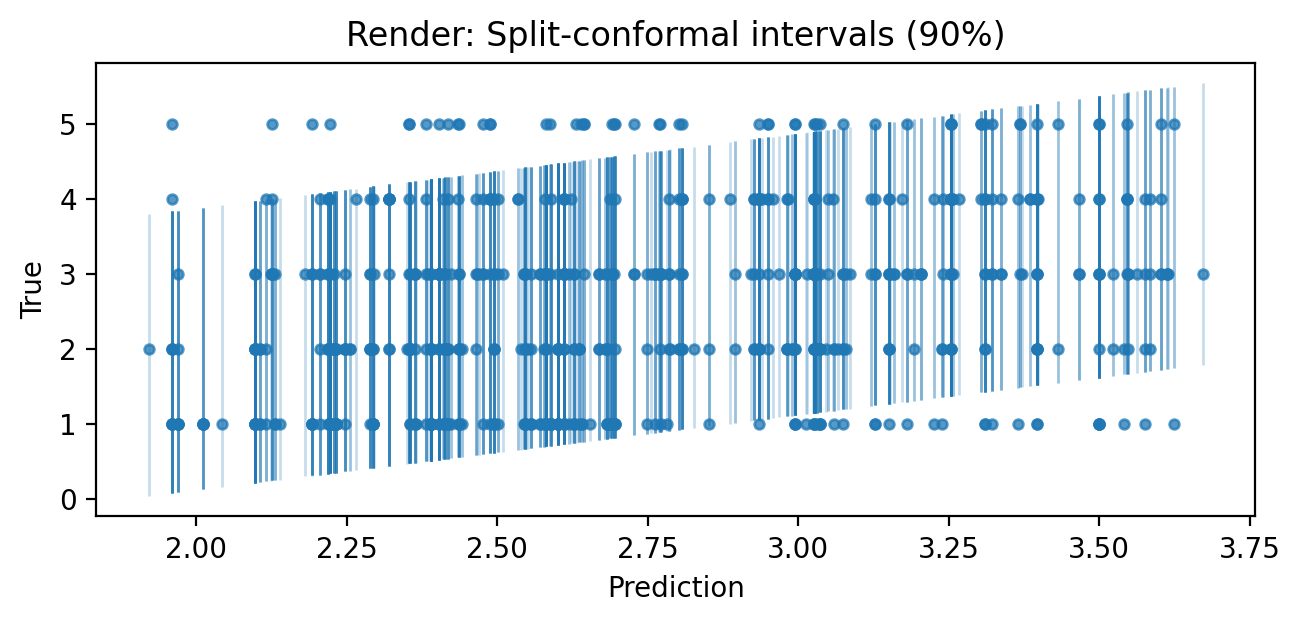

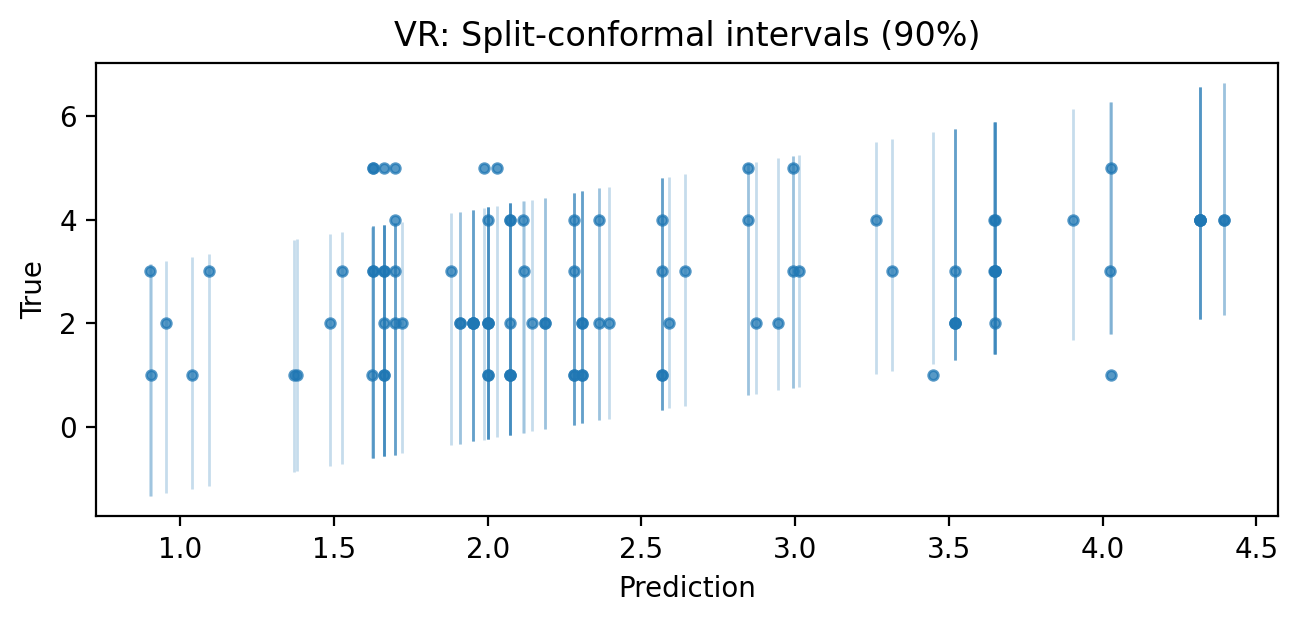

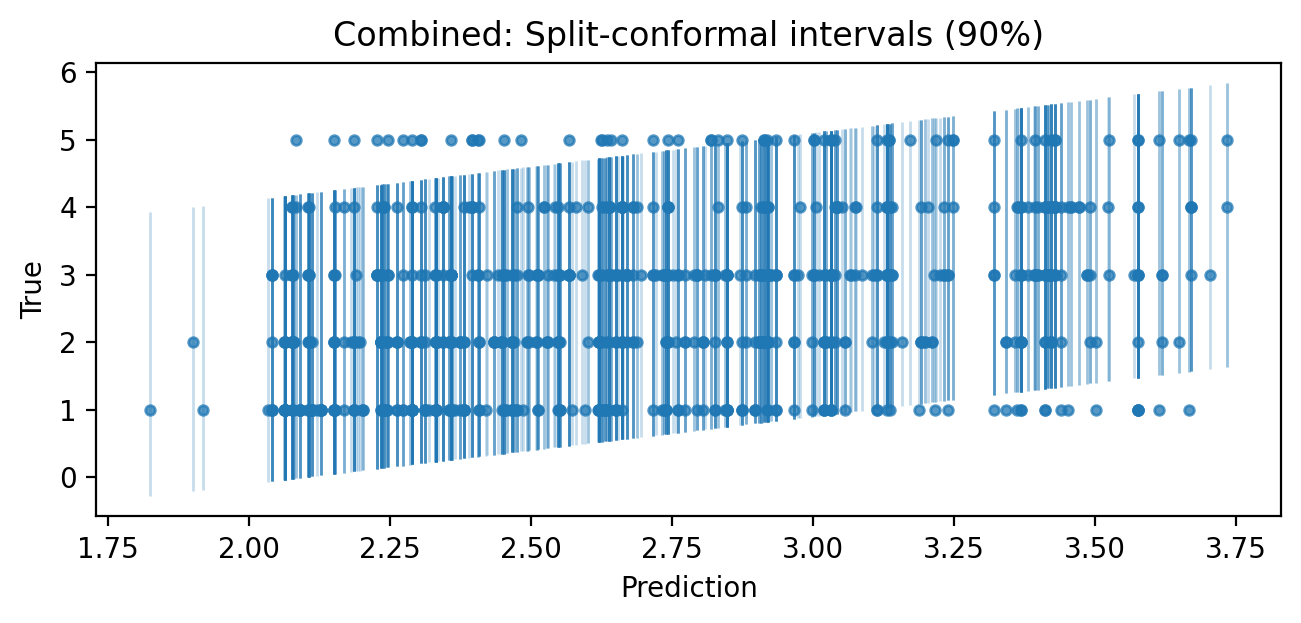

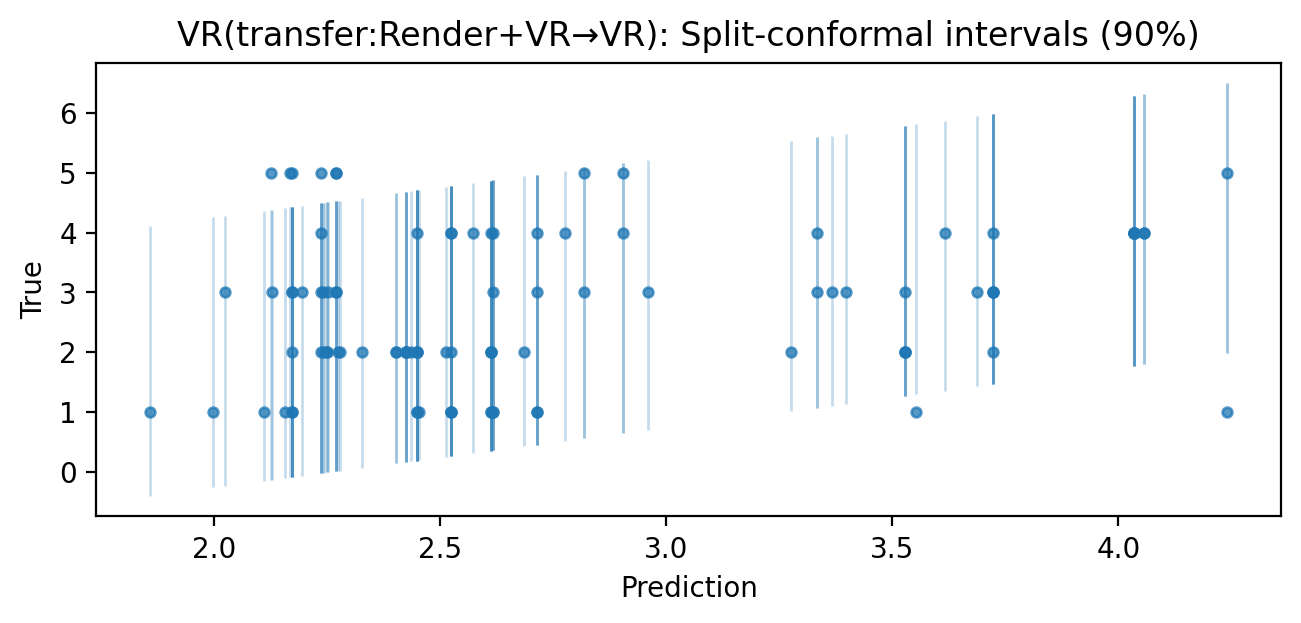

In [20]:
# =========================
# Stage 18 — Uncertainty via split-conformal (90%)
# =========================
begin_stage(
    "Uncertainty via split-conformal (90%)",
    "Empirical coverage and width for each domain/model; group-aware calibration split."
)

from math import ceil
from sklearn.base import clone

def _groups_hash(df, cols):
    cols = [c for c in cols if c in df.columns]
    if not cols:
        return pd.Series(np.arange(len(df)), index=df.index).astype(str)
    return df[cols].astype(str).agg('_'.join, axis=1)

def _group_aware_split(df, cal_frac=0.2, seed=42):
    """
    Split df into (train_part, cal_part) by GROUP_COLS so no scenario leakage.
    Falls back to random row split if groups are degenerate.
    """
    ghash = _groups_hash(df, GROUP_COLS)
    uniq = ghash.unique()
    rng = np.random.default_rng(seed)
    if len(uniq) <= 1:
        # Fallback: row split
        msk = rng.random(len(df)) >= cal_frac
        return df.loc[msk].reset_index(drop=True), df.loc[~msk].reset_index(drop=True)
    # Sample groups for calibration
    n_cal_g = max(1, int(round(len(uniq) * cal_frac)))
    cal_g = set(rng.choice(uniq, size=n_cal_g, replace=False))
    cal_idx = ghash.isin(cal_g)
    tr_df = df.loc[~cal_idx].reset_index(drop=True)
    cal_df = df.loc[cal_idx].reset_index(drop=True)
    if len(cal_df) == 0 or len(tr_df) == 0:  # safety fallback
        msk = rng.random(len(df)) >= cal_frac
        return df.loc[msk].reset_index(drop=True), df.loc[~msk].reset_index(drop=True)
    return tr_df, cal_df

def _maybe_augment_teacher_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    If BEST_TRANSFER_MODEL is the TeacherFeature variant, add teacher_pred so
    feature space matches the trained model.
    """
    if "TeacherFeature" in str(globals().get("BEST_TRANSFER_TAG", "")):
        X_r, y_r = train_render.drop(columns=[TARGET]), train_render[TARGET]
        _teacher = XGBRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=5,
            subsample=0.9, colsample_bytree=0.8, random_state=42,
            tree_method="hist", eval_metric="rmse", n_jobs=-1
        ).fit(X_r, y_r)
        X_aug = df.drop(columns=[TARGET]).copy()
        X_aug["teacher_pred"] = _teacher.predict(X_aug)
        return pd.concat([X_aug, df[[TARGET]].reset_index(drop=True)], axis=1)
    return df

def _split_conformal_qhat(residuals: np.ndarray, alpha: float) -> float:
    """
    Finite-sample split-conformal quantile:
      q_hat = quantile at index k = ceil((n+1)*(1-alpha)) with denominator n.
    """
    res = np.asarray(residuals, dtype=float)
    res = res[~np.isnan(res)]
    n = res.size
    if n == 0:
        return np.nan
    k = int(ceil((n + 1) * (1 - alpha)))
    k = min(max(1, k), n)  # clamp to [1, n]
    # kth order statistic (1-indexed -> 0-indexed)
    return float(np.partition(res, k - 1)[k - 1])

def conformal_intervals(best_estimator, train_df, test_df, miscov=0.1, tag="DATA",
                        group_aware=True, seed=42, use_teacher_feature=False, preview_n=50):
    """
    Split-conformal prediction intervals on test_df:
      1) Split train_df into (train_part, calibration_part) — group-aware by default
      2) Fit on train_part, compute |residuals| on calibration_part
      3) q_hat = finite-sample conformal quantile for (1-miscov)
      4) Predict on test_df, PI = [yhat - q_hat, yhat + q_hat]
      5) Report coverage, mean width; save preview + plot
    """
    # Teacher feature augmentation if needed
    tr_all = _maybe_augment_teacher_df(train_df) if use_teacher_feature else train_df
    te_all = _maybe_augment_teacher_df(test_df)  if use_teacher_feature else test_df

    # Group-aware split for calibration
    if group_aware:
        tr_part, cal_part = _group_aware_split(tr_all, cal_frac=0.2, seed=seed)
    else:
        tr_part, cal_part = train_test_split(tr_all, test_size=0.2, random_state=seed)

    Xtr, ytr   = tr_part.drop(columns=[TARGET]), tr_part[TARGET]
    Xcal, ycal = cal_part.drop(columns=[TARGET]), cal_part[TARGET]
    Xte,  yte  = te_all.drop(columns=[TARGET]),  te_all[TARGET]

    m = clone(best_estimator).fit(Xtr, ytr)
    cal_res = np.abs(ycal - m.predict(Xcal))

    # finite-sample qhat for alpha = miscov
    q_hat = _split_conformal_qhat(cal_res, alpha=miscov)

    yhat = m.predict(Xte)
    lo, hi = yhat - q_hat, yhat + q_hat

    cover = float(np.mean((yte.values >= lo) & (yte.values <= hi)))
    width = float(np.mean(hi - lo))
    stage_note(f"{tag}: coverage≈{cover:.3f}, width≈{width:.3f}, q̂≈{q_hat:.3f} (α={miscov:.2f})")

    # Preview table
    df_prev = (pd.DataFrame({"y_true": yte, "y_pred": yhat, "PI_lo": lo, "PI_hi": hi})
                 .head(preview_n).round(3))
    save_and_show_table(
        df_prev,
        f"Conformal preview (first {min(preview_n, len(df_prev))}) — {tag}",
        f"tab:conf_{_slug(tag)}",
        f"conformal_{_slug(tag)}",
        why=f"Split-conformal PIs at {(1-miscov):.0%} coverage; q̂ from calibration set (finite-sample)."
    )

    # Plot: prediction vs true with vertical PI whiskers
    plt.close('all')
    fig = plt.figure(figsize=(6.6, 3.2), dpi=180)
    plt.scatter(yhat, yte, s=12, alpha=.75)
    for xi, l, h in zip(yhat, lo, hi):
        plt.vlines(xi, l, h, alpha=.25, linewidth=1)
    plt.xlabel("Prediction"); plt.ylabel("True")
    plt.title(f"{tag}: Split-conformal intervals ({(1-miscov):.0%})")
    plt.tight_layout()
    save_and_tex(
        fig,
        f"{_slug(tag)}_conformal",
        f"{tag}: Split-conformal PIs (nominal {(1-miscov):.0%}); finite-sample q̂ from calibration residuals.",
        dpi=200, bbox_inches="tight"
    )
    plt.close(fig)

    return {"tag": tag, "alpha": miscov, "coverage": cover, "width": width, "qhat": q_hat}

# ---- Run per domain/model and summarize ----
rows = []
rows.append(conformal_intervals(est_r_best,          train_render,   test_render,   miscov=0.10, tag="Render",   use_teacher_feature=False))
rows.append(conformal_intervals(est_v_best,          train_vr,       test_vr,       miscov=0.10, tag="VR",       use_teacher_feature=False))
rows.append(conformal_intervals(est_c_best,          train_combined, test_combined, miscov=0.10, tag="Combined", use_teacher_feature=False))
rows.append(conformal_intervals(BEST_TRANSFER_MODEL, train_vr,       test_vr,       miscov=0.10,
                                tag=f"VR({BEST_TRANSFER_TAG})",
                                use_teacher_feature=("TeacherFeature" in str(BEST_TRANSFER_TAG))))

df_conf_summary = (pd.DataFrame(rows)
    .assign(coverage=lambda d: d.coverage.round(3),
            width=lambda d: d.width.round(3),
            qhat=lambda d: d.qhat.round(3))
    .rename(columns={"alpha":"miscov"}))

save_and_show_table(
    df_conf_summary[["tag","miscov","coverage","width","qhat"]],
    "Split-conformal coverage & width summary (90%)",
    "tab:conf_summary_90",
    "conformal_summary_90",
    why="Empirical test coverage and mean PI width per domain/model; calibration split is group-aware."
)


## Stage 19 — Cross-modality generalization (Train→Test)

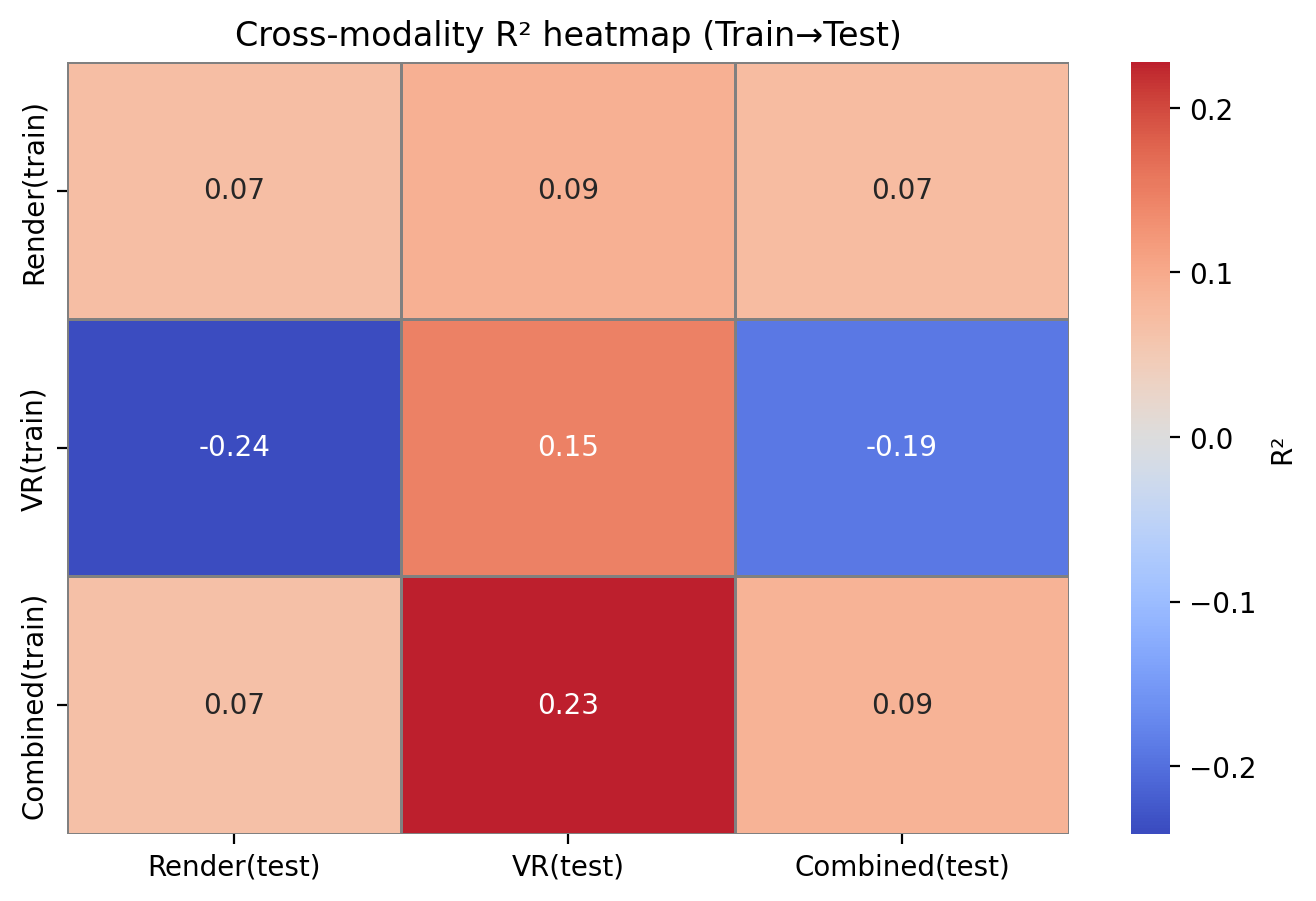

In [21]:
# =========================
# Stage 19 — Cross-modality generalization (Train→Test)
# =========================
begin_stage(
    "Cross-modality generalization (Train→Test)",
    "Train on {Render|VR|Combined}, test on {Render|VR|Combined} using the best estimators."
)

from sklearn.base import clone

def _align_design_matrices(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Ensure X_train and X_test have identical columns/order.
    If test is missing a train column, fill with train's mean/mode.
    """
    Xtr = train_df.drop(columns=[TARGET]).copy()
    Xte = test_df.drop(columns=[TARGET]).copy()

    for c in Xtr.columns:
        if c not in Xte.columns:
            if pd.api.types.is_numeric_dtype(Xtr[c]):
                Xte[c] = float(Xtr[c].mean())
            else:
                mode = Xtr[c].mode()
                Xte[c] = (mode.iloc[0] if not mode.empty else 0)

    # Extra columns present in test but not train are dropped
    Xte = Xte[Xtr.columns]
    ytr = train_df[TARGET].copy()
    yte = test_df[TARGET].copy()
    return Xtr, ytr, Xte, yte

def fit_and_score(est, train_df, test_df, tag_train, tag_test):
    Xtr, ytr, Xte, yte = _align_design_matrices(train_df, test_df)
    m = clone(est).fit(Xtr, ytr)
    yhat = m.predict(Xte)
    return {
        "Train": tag_train,
        "Test":  tag_test,
        "RMSE":  RMSE(yte, yhat),
        "MAE":   mean_absolute_error(yte, yhat),
        "R2":    r2_score(yte, yhat),
    }

rows = []
rows += [fit_and_score(est_r_best, train_render,   test_render,   "Render(train)",   "Render(test)")]
rows += [fit_and_score(est_r_best, train_render,   test_vr,       "Render(train)",   "VR(test)")]
rows += [fit_and_score(est_r_best, train_render,   test_combined, "Render(train)",   "Combined(test)")]
rows += [fit_and_score(est_v_best, train_vr,       test_render,   "VR(train)",       "Render(test)")]
rows += [fit_and_score(est_v_best, train_vr,       test_vr,       "VR(train)",       "VR(test)")]
rows += [fit_and_score(est_v_best, train_vr,       test_combined, "VR(train)",       "Combined(test)")]
rows += [fit_and_score(est_c_best, train_combined, test_render,   "Combined(train)", "Render(test)")]
rows += [fit_and_score(est_c_best, train_combined, test_vr,       "Combined(train)", "VR(test)")]
rows += [fit_and_score(est_c_best, train_combined, test_combined, "Combined(train)", "Combined(test)")]

df_cross = pd.DataFrame(rows)
df_cross = df_cross.assign(
    RMSE=lambda d: d.RMSE.round(3),
    MAE=lambda d:  d.MAE.round(3),
    R2=lambda d:   d.R2.round(3)
)

save_and_show_table(
    df_cross,
    "Cross-modality generalization (Train→Test)",
    "tab:cross",
    "cross_modality",
    why="How well each domain-best estimator extrapolates across domains; main metric is R²."
)

# --- Heatmap of R² ---
plt.close('all')
order_rows = ["Render(train)", "VR(train)", "Combined(train)"]
order_cols = ["Render(test)", "VR(test)", "Combined(test)"]

pv = df_cross.pivot(index="Train", columns="Test", values="R2")
# reindex to consistent order (ignore if missing)
pv = pv.reindex(index=[r for r in order_rows if r in pv.index],
                columns=[c for c in order_cols if c in pv.columns])

fig = plt.figure(figsize=(6.8, 4.6), dpi=180)
ax = sns.heatmap(pv, annot=True, fmt=".2f", cmap="coolwarm", center=0.0,
                 linewidths=0.4, linecolor="gray", cbar_kws={"label": "R²"})
ax.set_xlabel(""); ax.set_ylabel("")
ax.set_title("Cross-modality R² heatmap (Train→Test)")
plt.tight_layout()
save_and_tex(
    fig,
    "cross_modality_heatmap",
    "Cross-modality generalization R² heatmap (train→test).",
    dpi=200, bbox_inches="tight"
)
plt.close(fig)


## Stage 20 — Error analysis (top under/over-predictions)

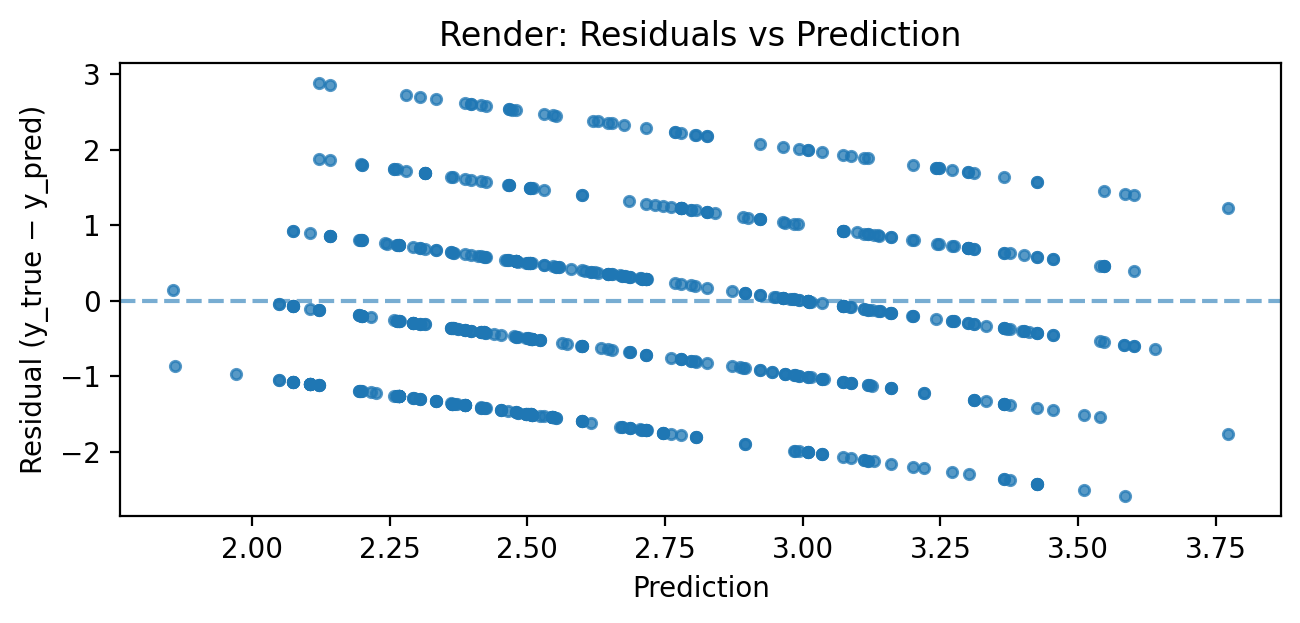

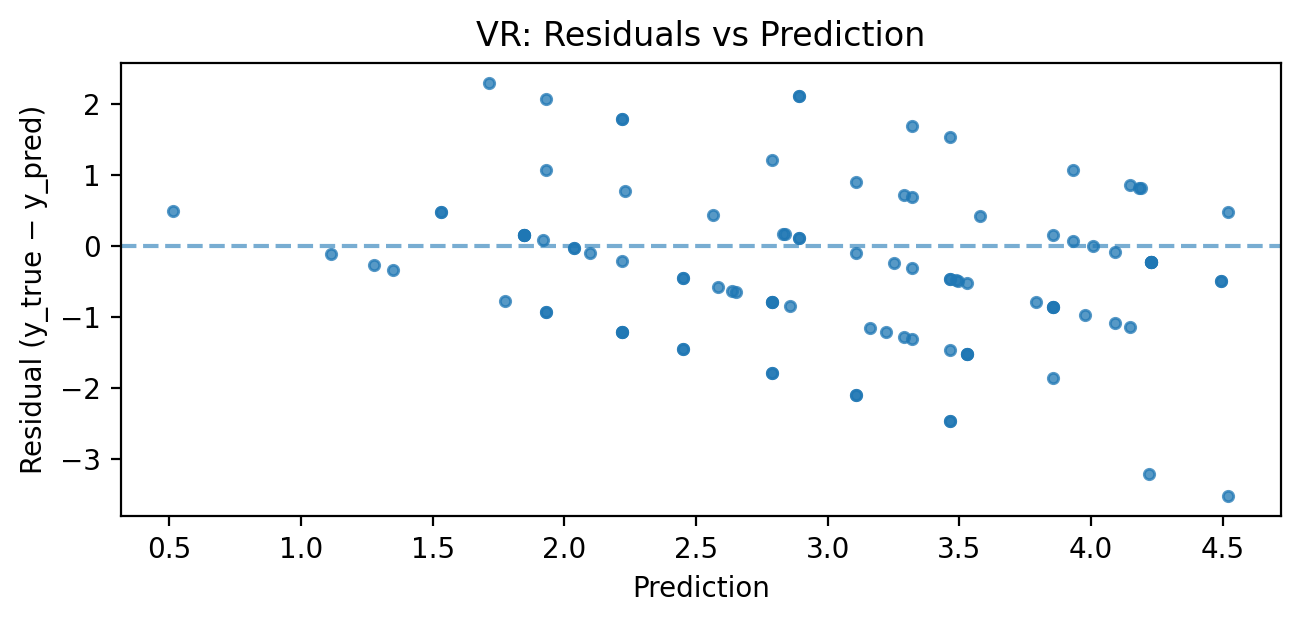

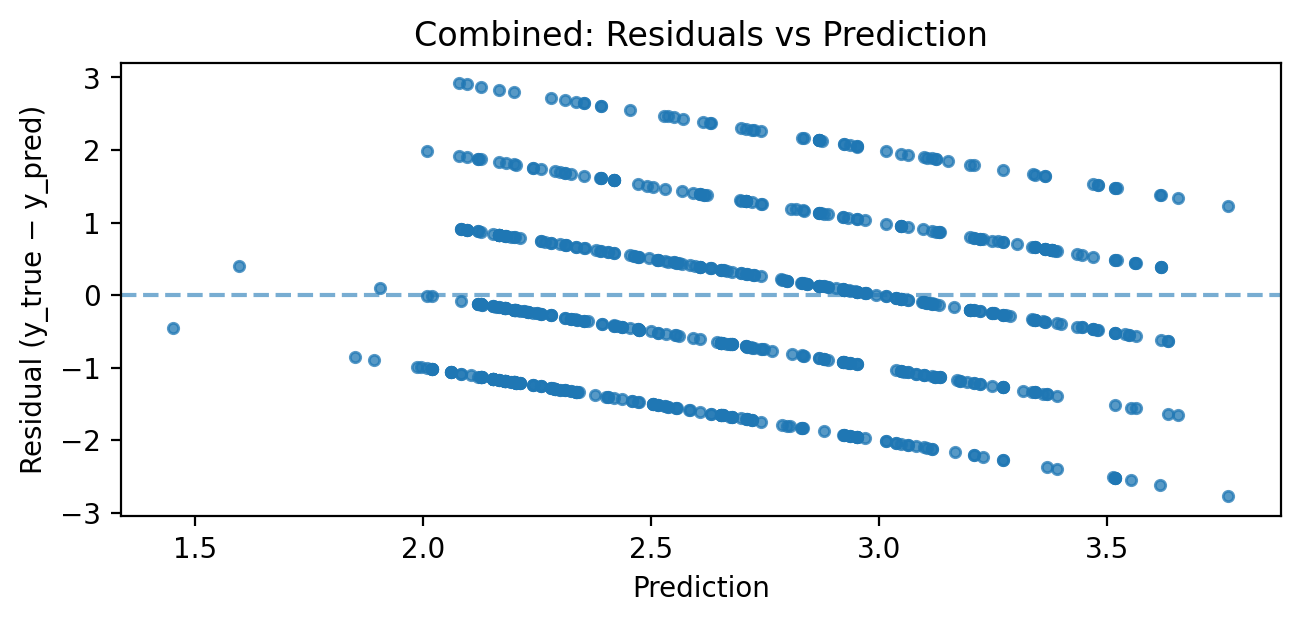

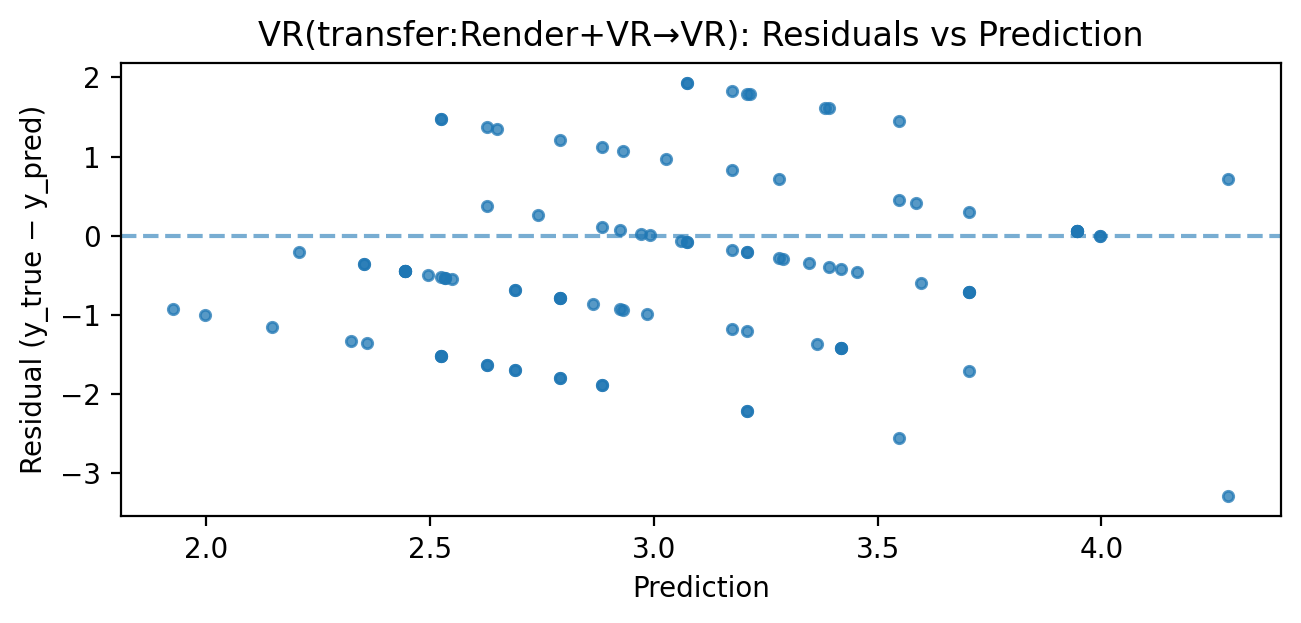

In [ ]:
# =========================
# Stage 20 — Error analysis (top under/over-predictions)
# =========================
begin_stage(
    "Error analysis (top under/over-predictions)",
    "Scenarios where the model misses most; inspect residual structure."
)

from sklearn.base import clone

def _maybe_augment_teacher_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    If BEST_TRANSFER_MODEL is the TeacherFeature variant, add teacher_pred so
    the feature space matches the trained model.
    """
    if "TeacherFeature" in str(globals().get("BEST_TRANSFER_TAG", "")):
        X_r, y_r = train_render.drop(columns=[TARGET]), train_render[TARGET]
        _teacher = XGBRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=5,
            subsample=0.9, colsample_bytree=0.8, random_state=42,
            tree_method="hist", eval_metric="rmse", n_jobs=-1
        ).fit(X_r, y_r)
        X_aug = df.drop(columns=[TARGET]).copy()
        X_aug["teacher_pred"] = _teacher.predict(X_aug)
        return pd.concat([X_aug, df[[TARGET]].reset_index(drop=True)], axis=1)
    return df

def _align_design_matrices(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Ensure X_train and X_test have identical columns/order.
    If test is missing a train column, fill with train's mean/mode.
    Extra columns in test are dropped.
    """
    Xtr = train_df.drop(columns=[TARGET]).copy()
    Xte = test_df.drop(columns=[TARGET]).copy()

    for c in Xtr.columns:
        if c not in Xte.columns:
            if pd.api.types.is_numeric_dtype(Xtr[c]):
                Xte[c] = float(Xtr[c].mean())
            else:
                mode = Xtr[c].mode()
                Xte[c] = (mode.iloc[0] if not mode.empty else 0)
    Xte = Xte[Xtr.columns]
    ytr = train_df[TARGET].copy()
    yte = test_df[TARGET].copy()
    return Xtr, ytr, Xte, yte

def error_table(best_estimator, train_df, test_df, tag="DATA", k=10):
    """
    Fit best_estimator on train_df, score on test_df, and list top-K under/over predictions.
    Residual = y_true - y_pred (positive = under-prediction).
    Saves two tables and a residuals vs prediction plot.
    """
    # TeacherFeature augmentation if needed (only for transfer model)
    tr_local = train_df
    te_local = test_df
    if (best_estimator is BEST_TRANSFER_MODEL) and ("TeacherFeature" in str(globals().get("BEST_TRANSFER_TAG", ""))):
        tr_local = _maybe_augment_teacher_df(tr_local)
        te_local = _maybe_augment_teacher_df(te_local)

    # Align matrices and fit
    Xtr, ytr, Xte, yte = _align_design_matrices(tr_local, te_local)
    m = clone(best_estimator).fit(Xtr, ytr)
    yhat = m.predict(Xte)
    resid = pd.Series(yte.values - yhat, index=yte.index, name="residual")

    # Build error dataframe (use te_local so any context columns are present)
    df_err = te_local.copy().assign(y_true=yte.values, y_pred=yhat, residual=resid.values)

    # Compact context columns if available
    summary_cols = [c for c in [
        'space category','view(L)','view(F)','view(R)','street width(M)',
        'building height(F)','window width(M)'
    ] if c in df_err.columns]

    under = df_err.sort_values('residual', ascending=False).head(k)
    over  = df_err.sort_values('residual', ascending=True ).head(k)

    # Save tables (inline + LaTeX/CSV)
    cols_under = (summary_cols + ['y_true','y_pred','residual']) if summary_cols else ['y_true','y_pred','residual']
    save_and_show_table(
        under[cols_under].reset_index(drop=True).round(3),
        f"Top {k} under-predictions — {tag}",
        f"tab:err_under_{_slug(tag)}",
        f"errors_under_{_slug(tag)}",
        why="Residual = y_true − y_pred; large positive = model under-predicted."
    )

    cols_over = (summary_cols + ['y_true','y_pred','residual']) if summary_cols else ['y_true','y_pred','residual']
    save_and_show_table(
        over[cols_over].reset_index(drop=True).round(3),
        f"Top {k} over-predictions — {tag}",
        f"tab:err_over_{_slug(tag)}",
        f"errors_over_{_slug(tag)}",
        why="Residual = y_true − y_pred; large negative = model over-predicted."
    )

    # Residuals vs prediction plot
    plt.close('all')
    fig = plt.figure(figsize=(6.6, 3.2), dpi=180)
    plt.scatter(yhat, resid, s=14, alpha=.75)
    plt.axhline(0, ls="--", alpha=.6)
    plt.xlabel("Prediction"); plt.ylabel("Residual (y_true − y_pred)")
    plt.title(f"{tag}: Residuals vs Prediction")
    plt.tight_layout()
    save_and_tex(
        fig,
        f"{_slug(tag)}_residuals_vs_pred",
        f"{tag}: Residuals vs predictions; structure may suggest missing variables or heteroskedasticity.",
        dpi=200, bbox_inches="tight"
    )
    plt.close(fig)

    return {"RMSE": RMSE(yte, yhat), "MAE": mean_absolute_error(yte, yhat), "R2": r2_score(yte, yhat)}

# ---- Run for each domain ----
_ = error_table(est_r_best,          train_render,   test_render,   tag="Render",   k=10)
_ = error_table(est_v_best,          train_vr,       test_vr,       tag="VR",       k=10)
_ = error_table(est_c_best,          train_combined, test_combined, tag="Combined", k=10)
_ = error_table(BEST_TRANSFER_MODEL, train_vr,       test_vr,       tag=f"VR({BEST_TRANSFER_TAG})", k=10)

